# Load Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.nn.functional import relu
from scipy.io import loadmat
import os
from skimage import io
from PIL import Image
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pickle
from ConvLSTM_pytorch import convlstm_wdo as convlstm
import operator
from random import sample
from utils_v4 import *

# Load Data

In [2]:
#selected subset of dates. 
val_dates = ['171021','171023','180711','180714']
test_dates = ['171020','171022','180712', '180713']
bad_dates = ['180326', '180328', '171019', '180715', '180716', '180717']
#load_path = '/home/bijanadmin/Desktop/Goose_data/data_Goose_1st_2/'
load_path = '/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/'
# save_path = '/mnt/pesaranlab/People/Capstone_students/Yue/model/model_Goose_1st_2_upsample'
# model_saving_path = '/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/LR_models'
model_saving_path = '/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models'





## Load data helper functions

In [3]:
def create_files_new(load_path, bad_dates, T_length=10, proceed=1): 
    sleep_files = os.listdir(load_path+'sleep/')
    move_files = os.listdir(load_path+'move/')
    all_files = sleep_files+move_files
    
    dic = {}
    for f in all_files:
        mvmt_type = f.split('_')[-1].split('.')[0]
        date = f.split('_')[0]
        rec = f.split('_')[1].split('_')[0]
        time = float(f.split('_')[3][4:])
        if date in bad_dates:
            continue
        if mvmt_type == 'sleep':
            label = 1
        else:
            label = 0
        if date in dic:
            if rec in dic[date]:
                dic[date][rec].append([f, label, mvmt_type, date, rec, time])
            else:
                dic[date][rec] = [[f, label, mvmt_type, date, rec, time]]
        else:
            dic[date] = {rec: [[f, label, mvmt_type, date, rec, time]]}
        
    for d in dic:
        for r in dic[d]:
            dic[d][r] = sorted(dic[d][r], key=operator.itemgetter(3, 4, 5))
    
    move_data, sleep_data = [], []
    for d in dic:
        for r in dic[d]:
            sleep_grouped, move_grouped = create_files_new_helper(dic[d][r], T_length=T_length, proceed=proceed)
            sleep_data.append(sleep_grouped)
            move_data.append(move_grouped)
    
    return move_data, sleep_data

In [4]:
def create_files_new_helper(L, T_length, proceed):
    L_labels = np.array([L[i][1] for i in range(len(L))])
    L_times = np.array([L[i][-1] for i in range(len(L))])
    
    L_new_sleep, L_new_move = [], []
    start = 0
    while start <= len(L)-T_length:
        end = start + T_length
        #pdb.pm()
        if sum(L_times[start+1:end]-L_times[start:end-1]-time_window) != 0:
            start += 1
            continue
        if sum(L_labels[start:end]) == T_length:
            L_new_sleep.append(L[start:end])
        elif sum(L_labels[start:end]) == 0:
            L_new_move.append(L[start:end])
        start += proceed
    return L_new_sleep, L_new_move

In [5]:
def upsample(train_files):
    train_sleep = [i for i in train_files if i[0][1] == 1]
    train_move = [i for i in train_files if i[0][1] == 0]
    diff = abs(len(train_sleep)-len(train_move))
    train_new = []
    d = 0
    while d < diff:
        if len(train_sleep) > len(train_move):
            ind = random.randint(0, len(train_move)-1)
            x = train_move[ind]
            d += 1
        else:
            ind = random.randint(0, len(train_sleep)-1)
            x = train_sleep[ind]
            d += 1
        train_new.append(x)   
    train_files = train_sleep+train_move+train_new
    return train_files

In [6]:
class SpectrogramDatasetAtt(Dataset):
    def __init__(self, files, load_path, T_length, all_label=False, CH=None):
        self.CH = CH
        self.files = files
        self.load_path = load_path
        self.T_length = T_length
        self.all_label = all_label
  
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        group = self.files[idx]
        specs, labels, dates, recs, times = [], [], [], [], []
        for i in range(len(group)):
            f, label, mvmt_type, date, rec, time = group[i]
            spec = torch.from_numpy(np.load(self.load_path+mvmt_type+'/'+f))
            if self.CH is not None:
                spec = torch.transpose(spec[self.CH,:,:].unsqueeze(0), 2, 1)
            else:
                spec = torch.transpose(spec, 2, 1)
            specs.append(spec)
            labels.append(torch.Tensor([label]))
            dates.append(date)
            recs.append(rec)
            times.append(time)
            if i == (self.T_length-1)/2:
                label_mid = torch.Tensor([label])
                date_mid = date
                rec_mid = rec
                time_mid = time
        if self.all_label:
            return specs, labels, dates, recs, times
        else:
            return specs, label_mid, date_mid, rec_mid, time_mid

## T-length = 3

In [7]:
time_window = 10
## Load files
move_files, sleep_files = create_files_new(load_path, bad_dates, T_length=3, proceed=1)# proceed = 1
train_files, val_files, test_files = [], [], []

## Put files in val, test, and train
for f in move_files+sleep_files:
    if f:
        if f[0][1][3] in val_dates:
            val_files.extend(f)
        elif f[0][1][3] in test_dates:
            test_files.extend(f)
        else:
            train_files.extend(f)           

In [8]:
## Randomly shuffle inside train, val, and test
random.shuffle(train_files)
random.shuffle(val_files)
random.shuffle(test_files)

In [9]:
## Upsample train
train_files = upsample(train_files)

In [10]:
## Balance val 
sleep_files = []
move_files = []
for t in range(len(val_files)):
    if 'sleep' in val_files[t][0]:
        sleep_files.append(val_files[t])
    if 'move' in val_files[t][0]:
        move_files.append(val_files[t])

sleep_sample = sample(sleep_files, len(move_files))
val_2_files = sleep_sample+move_files

In [11]:
len(train_files), len(val_files), len(test_files)

(53026, 4692, 4855)

In [12]:
## Load files to dataloader

# train_dataset = SpectrogramDatasetAtt(files=train_files, load_path=load_path, T_length=3, all_label=True)
# valid_dataset = SpectrogramDatasetAtt(files=val_2_files, load_path=load_path, T_length=3, all_label=True)
# test_dataset = SpectrogramDatasetAtt(files=test_files, load_path=load_path, T_length=3, all_label=True)

train_dataset = SpectrogramDatasetAtt(files=train_files, load_path=load_path, T_length=3, all_label=True)
valid_dataset = SpectrogramDatasetAtt(files=val_files, load_path=load_path, T_length=3, all_label=True)
test_dataset = SpectrogramDatasetAtt(files=test_files, load_path=load_path, T_length=3, all_label=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle = True)
val_loader = DataLoader(dataset=valid_dataset, batch_size=128, shuffle = False)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle = False)

## convLSTM

In [13]:
## Define Model
class convLSTM(nn.Module):
    def __init__(self, input_dim = 1, layers = 1, hidden_dim = 10, frequencies = 100,timewindow = 10, output_size=1, batch_size=128, dropout = 0):
        super(convLSTM, self).__init__()
        
        self.input_dim = input_dim
        self.output_size = output_size
        self.batch_size = batch_size
        self.n_layers = layers
        self.hidden_dim = hidden_dim
        self.freqs = frequencies
        self.timewindow = timewindow
        self.dropout = dropout
        
        # Define the lstm layer
        self.convLSTM = convlstm.ConvLSTM(input_dim=self.input_dim,
                 hidden_dim=self.hidden_dim,
                 kernel_size=(3, 3),
                 num_layers=self.n_layers,
                 batch_first=False,
                 bias=True,
                 return_all_layers=False, 
                 dropout = self.dropout)
        # Define the fully-connected layer
#         self.fc = nn.Linear(self.n_layers*self.hidden_dim, output_size)
        self.fc = nn.Linear(self.hidden_dim*self.freqs*self.timewindow, output_size)

    def forward(self, input_seq):
        
        # convLSTM
        _, last_states = self.convLSTM(input_seq)
        last_states = last_states[0][0]
        last_states = last_states.reshape(last_states.shape[0], -1)
        fc = self.fc(last_states)        

        return fc

### Training functions

In [14]:
def get_accuracy(model, loader, device='cuda', collect_result = False):
    """
    Function that calculate the accuracy of the model. 
    """
    correct = 0
    total = 0
    pred, labs = [],[]
    with torch.no_grad():
        for data, labels, _, _, _ in loader:
            # Labels
            labels = torch.stack(labels)
            labels = labels[0]
            labels = labels.to(device).float()
            # Data
            data = torch.tensor(np.stack(data)).to(device).float() 
            data = data.to(device).float()
            # Feed data to model
            outputs = model(data)            
            outputs = torch.tensor(outputs).to(device)
            # Predictions
            predictions = (outputs > 0.5) * 1.0
            predictions = predictions.flatten().detach().cpu().numpy()
            labels = labels.flatten().cpu().numpy()
            # Calculate Accuracy
            total += len(labels)
            correct += (predictions == labels).sum()
            
            if collect_result:
                pred.append(predictions)
                labs.append(labels)
            
    accuracy = correct / total
    if collect_result:
        return accuracy, pred, labs
    return accuracy

In [15]:
def train(model, optimizer, criterion, loader, device='cuda'):
    """
    Function that train the model. 
    """
    model.train()
    epoch_losses = 0
    epoch_lens = 0
    parameter_history = []
    # criterion = nn.BCELoss()
    for batch_idx, (data, labels, _, _, _) in enumerate(loader):
        # Get Label
        labels = torch.stack(labels)
        labels = labels[0]
        labels = torch.flatten(labels).to(device).float()
        labels = labels.to(device).float()
#         print(batch_idx)
        
        # Get data
        data = torch.tensor(np.stack(data)).to(device).float() 
        data = data.to(device).float()

        # Zero out grad
        optimizer.zero_grad()

        # Data in model
        outputs = model(data)
#         outputs = torch.tensor(outputs,requires_grad = True).to(device)
        outputs = torch.squeeze(outputs)

        # Get loss
        loss = criterion(torch.sigmoid(outputs), labels)
#         print(loss)
        epoch_losses += loss
        epoch_lens += 1

        parameter_history.append(list(model.parameters())[0])
        loss.backward() # error?
        optimizer.step()

    epoch_accs = get_accuracy(model, loader, device=device, collect_result = False)
    return epoch_losses/epoch_lens, epoch_accs, parameter_history

def evaluate(model, optimizer, criterion, loader, device='cuda', collect_result = False):
    model.eval()
    epoch_losses = 0
    epoch_lens = 0
    
    with torch.no_grad():
        for batch_idx, (data, labels, _, _, _) in enumerate(loader):
            labels = torch.stack(labels)
            labels = labels[0]
            labels = labels.to(device).float()
            labels = torch.flatten(labels).to(device).float()
            data = torch.tensor(np.stack(data)).to(device).float() 
            data = data.to(device).float()
            outputs = model(data)
#             outputs = torch.tensor(outputs).to(device)
            outputs = torch.squeeze(outputs)
            loss = criterion(torch.sigmoid(outputs), labels)
            epoch_losses += loss
            epoch_lens += 1
    
    if collect_result:
        epoch_accs, pred, labs = get_accuracy(model, loader, device = device, collect_result = True)
        return epoch_losses/epoch_lens,epoch_accs, pred, labs
    else:
        epoch_accs = get_accuracy(model, loader, device=device, collect_result = collect_result)
    return epoch_losses/epoch_lens, epoch_accs

### Training

In [16]:
device = torch.device('cuda')

tol = 0.01
learning_rate = 0.01
num_epochs = 51
alpha = 0
model_type = 'convLSTM'
loss_type = 'bce'
reg_type = 'none'
alpha = 0
timewindow = 10
ch = 'all'
dropout = [0.1,0.3,0.5]
hidden_dim = [10,15,48,56]
# verbose = False
criterion = nn.BCELoss() # BCE loss
T_length = 3


convLSTM(
  (convLSTM): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(72, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (dropout): Dropout2d(p=0.1, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=10000, out_features=1, bias=True)
)


<ipython-input-14-894d578093d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = torch.tensor(outputs).to(device)


0
Train loss for epoch 0: 0.29372546076774597
Val loss for epoch 0: 1.747702956199646
Train loss for epoch 1: 0.13938796520233154
Val loss for epoch 1: 9.071076393127441
Train loss for epoch 2: 0.11761346459388733
Val loss for epoch 2: 14.707575798034668
Train loss for epoch 3: 0.18839040398597717
Val loss for epoch 3: 10.111310958862305
Train loss for epoch 4: 0.14153817296028137
Val loss for epoch 4: 20.122549057006836
Train loss for epoch 5: 0.16407635807991028
Val loss for epoch 5: 28.20774269104004
Train loss for epoch 6: 0.12343088537454605
Val loss for epoch 6: 28.612506866455078
Train loss for epoch 7: 0.13215197622776031
Val loss for epoch 7: 29.24250602722168
Train loss for epoch 8: 0.14537867903709412
Val loss for epoch 8: 23.588336944580078
Train loss for epoch 9: 0.12432596832513809
Val loss for epoch 9: 26.975446701049805
Train loss for epoch 10: 0.114947609603405
Val loss for epoch 10: 26.3763370513916
Train loss for epoch 11: 0.14802607893943787
Val loss for epoch 11: 3

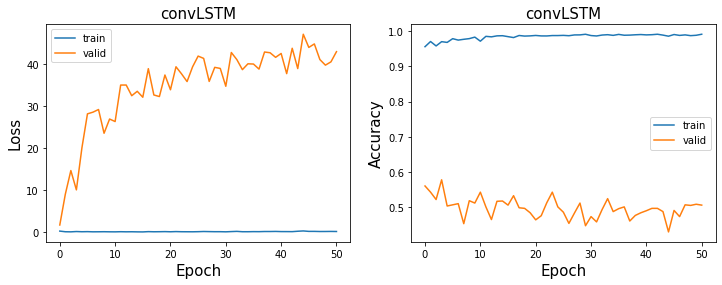

convLSTM(
  (convLSTM): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(72, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (dropout): Dropout2d(p=0.3, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=10000, out_features=1, bias=True)
)
0
Train loss for epoch 0: 0.3245333731174469
Val loss for epoch 0: 4.423112392425537
Train loss for epoch 1: 0.251860111951828
Val loss for epoch 1: 7.221077919006348
Train loss for epoch 2: 0.2728758156299591
Val loss for epoch 2: 9.710478782653809
Train loss for epoch 3: 0.2681322693824768
Val loss for epoch 3: 9.827730178833008
Train loss for epoch 4: 0.2222229391336441
Val loss for epoch 4: 21.40639877319336
Train loss for epoch 5: 0.23145410418510437
Val loss for epoch 5: 17.02259635925293
Train loss for epoch 6: 0.23075784742832184
Val loss for epoch 6: 18.56173324584961
Train loss for epoch 7: 0.23861901462078094
Val loss for epoch 7: 18.723188400268555
Train loss for epoch 8: 0.238

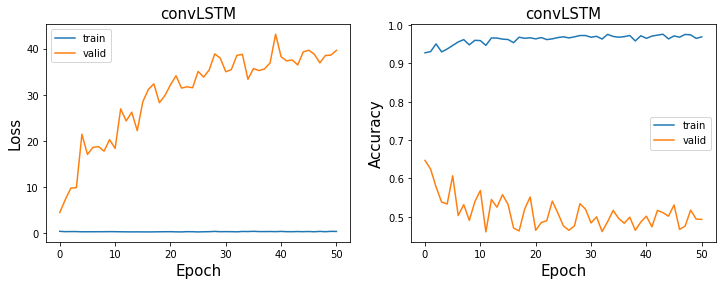

convLSTM(
  (convLSTM): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(72, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (dropout): Dropout2d(p=0.5, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=10000, out_features=1, bias=True)
)
0
Train loss for epoch 0: 0.40194782614707947
Val loss for epoch 0: 6.819953918457031
Train loss for epoch 1: 0.3097969591617584
Val loss for epoch 1: 18.54712677001953
Train loss for epoch 2: 0.30737563967704773
Val loss for epoch 2: 13.383627891540527
Train loss for epoch 3: 0.273956298828125
Val loss for epoch 3: 11.439658164978027
Train loss for epoch 4: 0.286609947681427
Val loss for epoch 4: 19.245956420898438
Train loss for epoch 5: 0.2606039345264435
Val loss for epoch 5: 15.5474271774292
Train loss for epoch 6: 0.2726020812988281
Val loss for epoch 6: 21.621379852294922
Train loss for epoch 7: 0.28221607208251953
Val loss for epoch 7: 22.736846923828125
Train loss for epoch 8: 0.2

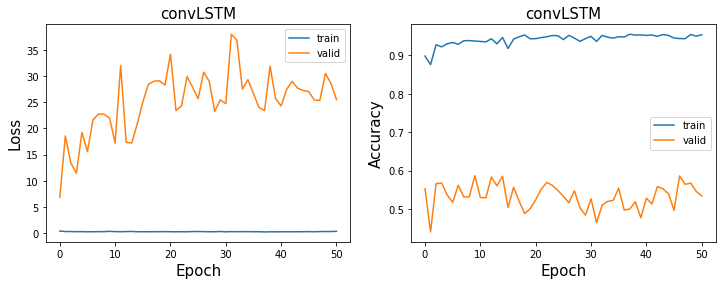

convLSTM(
  (convLSTM): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(77, 60, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (dropout): Dropout2d(p=0.1, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=15000, out_features=1, bias=True)
)
0
Train loss for epoch 0: 0.6588776111602783
Val loss for epoch 0: 3.468764543533325
Train loss for epoch 1: 0.16833437979221344
Val loss for epoch 1: 10.368414878845215
Train loss for epoch 2: 0.15112777054309845
Val loss for epoch 2: 15.8484468460083
Train loss for epoch 3: 0.1399156004190445
Val loss for epoch 3: 21.276945114135742
Train loss for epoch 4: 0.14919385313987732
Val loss for epoch 4: 20.27541732788086
Train loss for epoch 5: 0.2546033263206482
Val loss for epoch 5: 25.444561004638672
Train loss for epoch 6: 0.28544020652770996
Val loss for epoch 6: 29.68581199645996
Train loss for epoch 7: 0.27332088351249695
Val loss for epoch 7: 28.59425163269043
Train loss for epoch 8: 0

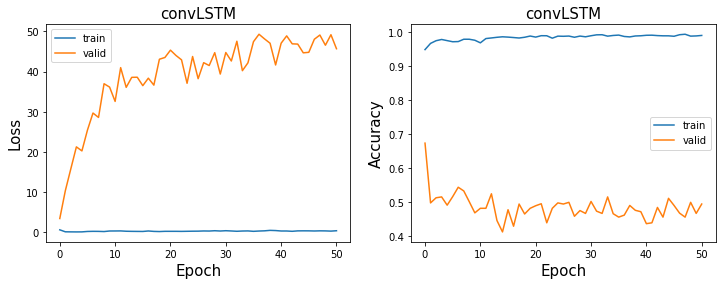

convLSTM(
  (convLSTM): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(77, 60, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (dropout): Dropout2d(p=0.3, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=15000, out_features=1, bias=True)
)
0
Train loss for epoch 0: 0.5719612836837769
Val loss for epoch 0: 7.315860748291016
Train loss for epoch 1: 0.26249581575393677
Val loss for epoch 1: 10.25148868560791
Train loss for epoch 2: 0.23153093457221985
Val loss for epoch 2: 13.000772476196289
Train loss for epoch 3: 0.25129562616348267
Val loss for epoch 3: 21.71803855895996
Train loss for epoch 4: 0.28717735409736633
Val loss for epoch 4: 28.01930046081543
Train loss for epoch 5: 0.31043824553489685
Val loss for epoch 5: 25.519554138183594
Train loss for epoch 6: 0.3332710862159729
Val loss for epoch 6: 28.082807540893555
Train loss for epoch 7: 0.333753764629364
Val loss for epoch 7: 26.63718032836914
Train loss for epoch 8: 0

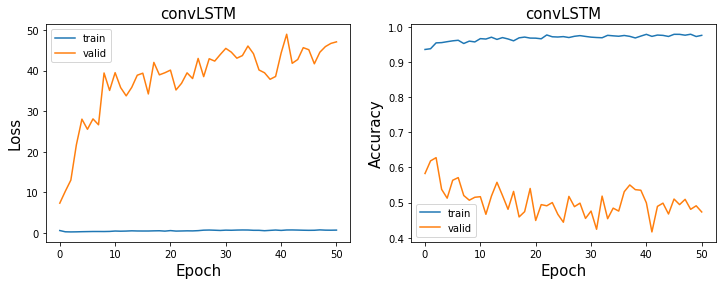

convLSTM(
  (convLSTM): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(77, 60, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (dropout): Dropout2d(p=0.5, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=15000, out_features=1, bias=True)
)
0
Train loss for epoch 0: 0.4718393087387085
Val loss for epoch 0: 10.9092378616333
Train loss for epoch 1: 0.34957677125930786
Val loss for epoch 1: 15.90435791015625
Train loss for epoch 2: 0.3646658658981323
Val loss for epoch 2: 18.955968856811523
Train loss for epoch 3: 0.38995471596717834
Val loss for epoch 3: 16.999855041503906
Train loss for epoch 4: 0.44355759024620056
Val loss for epoch 4: 20.8571834564209
Train loss for epoch 5: 0.42056623101234436
Val loss for epoch 5: 19.87824058532715
Train loss for epoch 6: 0.40450623631477356
Val loss for epoch 6: 32.67211151123047
Train loss for epoch 7: 0.38683900237083435
Val loss for epoch 7: 20.456192016601562
Train loss for epoch 8: 0

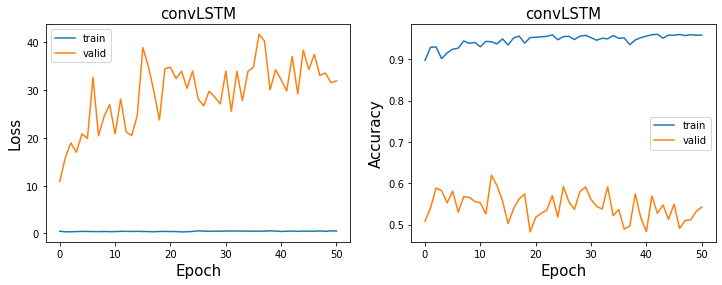

convLSTM(
  (convLSTM): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(110, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (dropout): Dropout2d(p=0.1, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=48000, out_features=1, bias=True)
)
0
Train loss for epoch 0: 8.866947174072266
Val loss for epoch 0: 29.978307723999023
Train loss for epoch 1: 5.059108734130859
Val loss for epoch 1: 31.65537452697754
Train loss for epoch 2: 4.17287540435791
Val loss for epoch 2: 32.620479583740234
3
Train loss for epoch 3: 3.4758522510528564
Val loss for epoch 3: 27.98142433166504
Train loss for epoch 4: 3.4256577491760254
Val loss for epoch 4: 38.076759338378906
Train loss for epoch 5: 3.4674253463745117
Val loss for epoch 5: 41.146461486816406
6
Train loss for epoch 6: 3.2653136253356934
Val loss for epoch 6: 25.59412384033203
Train loss for epoch 7: 3.319436550140381
Val loss for epoch 7: 36.07704544067383
Train loss for epoch 8: 2.8

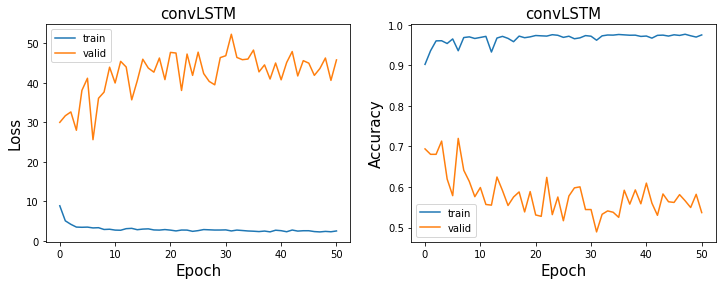

convLSTM(
  (convLSTM): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(110, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (dropout): Dropout2d(p=0.3, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=48000, out_features=1, bias=True)
)
0
Train loss for epoch 0: 4.002078056335449
Val loss for epoch 0: 33.52950668334961
1
Train loss for epoch 1: 3.024904489517212
Val loss for epoch 1: 27.787891387939453
Train loss for epoch 2: 3.0755112171173096
Val loss for epoch 2: 37.39435958862305
Train loss for epoch 3: 3.160061836242676
Val loss for epoch 3: 37.09513473510742
Train loss for epoch 4: 2.8842694759368896
Val loss for epoch 4: 38.55412673950195
Train loss for epoch 5: 2.869769811630249
Val loss for epoch 5: 39.225257873535156
Train loss for epoch 6: 2.8666512966156006
Val loss for epoch 6: 43.86440658569336
Train loss for epoch 7: 3.091799020767212
Val loss for epoch 7: 41.57474899291992
Train loss for epoch 8: 2.86603

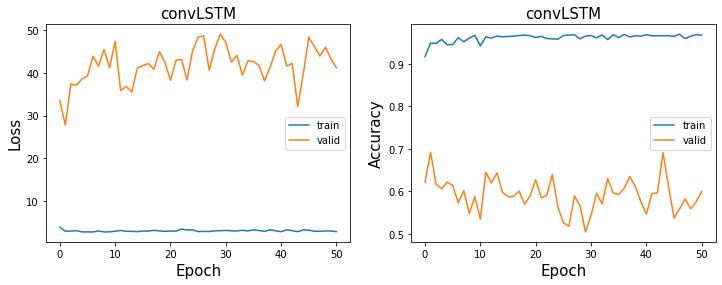

convLSTM(
  (convLSTM): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(110, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (dropout): Dropout2d(p=0.5, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=48000, out_features=1, bias=True)
)
0
Train loss for epoch 0: 2.6797585487365723
Val loss for epoch 0: 38.224761962890625
Train loss for epoch 1: 2.2478396892547607
Val loss for epoch 1: 39.33974838256836
Train loss for epoch 2: 2.306701183319092
Val loss for epoch 2: 44.621028900146484
Train loss for epoch 3: 2.5585153102874756
Val loss for epoch 3: 39.57903289794922
4
Train loss for epoch 4: 2.7695045471191406
Val loss for epoch 4: 34.631195068359375
Train loss for epoch 5: 2.936215877532959
Val loss for epoch 5: 41.7230339050293
Train loss for epoch 6: 2.862877368927002
Val loss for epoch 6: 44.72979736328125
Train loss for epoch 7: 3.042875289916992
Val loss for epoch 7: 45.77299118041992
Train loss for epoch 8: 2.9593

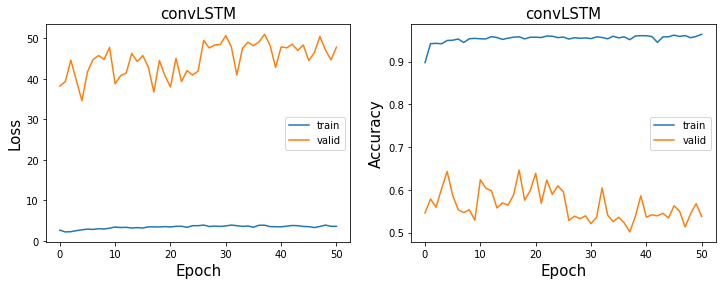

convLSTM(
  (convLSTM): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(118, 224, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (dropout): Dropout2d(p=0.1, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=56000, out_features=1, bias=True)
)
0
Train loss for epoch 0: 5.10282039642334
Val loss for epoch 0: 32.793209075927734
Train loss for epoch 1: 3.9149770736694336
Val loss for epoch 1: 36.76339340209961
Train loss for epoch 2: 3.5737128257751465
Val loss for epoch 2: 35.56591033935547
Train loss for epoch 3: 4.249037265777588
Val loss for epoch 3: 36.63349533081055
4
Train loss for epoch 4: 3.696021556854248
Val loss for epoch 4: 26.588403701782227
Train loss for epoch 5: 3.2973480224609375
Val loss for epoch 5: 30.836441040039062
Train loss for epoch 6: 3.1990396976470947
Val loss for epoch 6: 43.30625534057617
Train loss for epoch 7: 3.350679874420166
Val loss for epoch 7: 41.65922164916992
Train loss for epoch 8: 3.4585

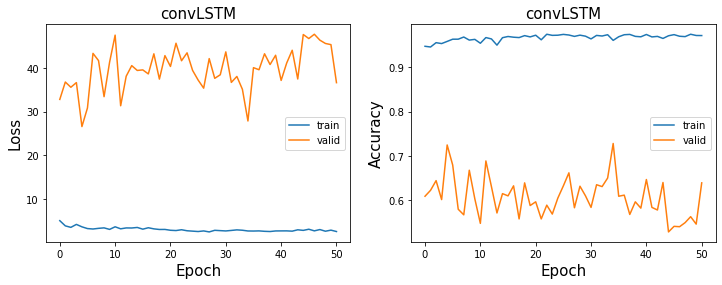

convLSTM(
  (convLSTM): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(118, 224, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (dropout): Dropout2d(p=0.3, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=56000, out_features=1, bias=True)
)
0
Train loss for epoch 0: 5.860099792480469
Val loss for epoch 0: 24.886478424072266
Train loss for epoch 1: 4.299139976501465
Val loss for epoch 1: 46.357688903808594
Train loss for epoch 2: 3.7708282470703125
Val loss for epoch 2: 42.83541488647461
Train loss for epoch 3: 3.527928352355957
Val loss for epoch 3: 41.168548583984375
Train loss for epoch 4: 3.502690553665161
Val loss for epoch 4: 37.16264724731445
Train loss for epoch 5: 3.472698450088501
Val loss for epoch 5: 39.55144500732422
Train loss for epoch 6: 3.525738000869751
Val loss for epoch 6: 39.402801513671875
Train loss for epoch 7: 3.5043628215789795
Val loss for epoch 7: 48.75166702270508
Train loss for epoch 8: 3.203992

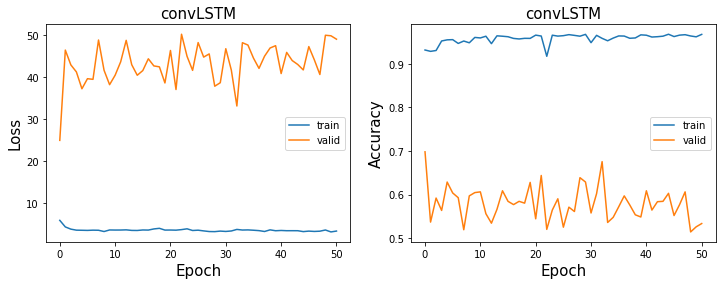

convLSTM(
  (convLSTM): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(118, 224, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (dropout): Dropout2d(p=0.5, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=56000, out_features=1, bias=True)
)
0
Train loss for epoch 0: 3.2133398056030273
Val loss for epoch 0: 34.396881103515625
Train loss for epoch 1: 3.181670904159546
Val loss for epoch 1: 35.72878646850586
2
Train loss for epoch 2: 3.2137298583984375
Val loss for epoch 2: 33.9541130065918
Train loss for epoch 3: 3.391860246658325
Val loss for epoch 3: 45.58972930908203
4
Train loss for epoch 4: 3.413831949234009
Val loss for epoch 4: 31.79288673400879
Train loss for epoch 5: 3.2222213745117188
Val loss for epoch 5: 36.77737045288086
Train loss for epoch 6: 3.4085164070129395
Val loss for epoch 6: 41.10810470581055
Train loss for epoch 7: 3.6601345539093018
Val loss for epoch 7: 42.7288818359375
Train loss for epoch 8: 3.6951

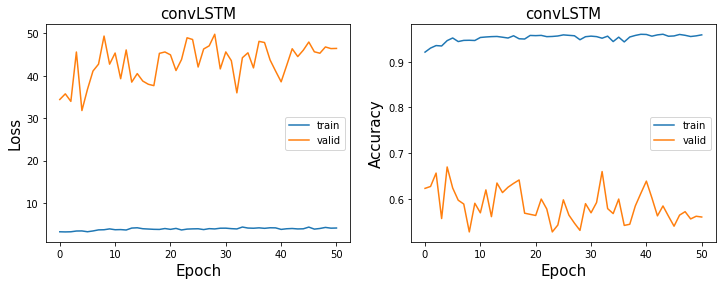

In [17]:
for i in hidden_dim:
    for d in dropout:
        model = convLSTM(input_dim = 62, hidden_dim = i, dropout = d).to(device)
        print(model)
        optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
        criterion = nn.BCELoss() # BCE loss
        train_losses, train_accs, val_losses, val_accs, parameter_history = [], [], [], [],[]

        for epoch in range(num_epochs):
            train_loss, train_acc, parameter_history = train(model, optimizer, criterion, train_loader,  device='cuda')
            val_loss, val_acc = evaluate(model, optimizer, criterion, val_loader, device='cuda')
            train_losses.append(train_loss)
            train_accs.append(train_acc)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            if epoch == 0:
                torch.save(model.state_dict(), '{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_TLEN{}_DO{}_HD{}_EPOCH{}_balanced.pt'.format(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow,T_length, d, i,epoch))
            if val_loss <= min(val_losses):
                best_epoch = epoch
                print(epoch)
                print('Train loss for epoch {}: {}'.format(epoch, train_loss))
                print('Val loss for epoch {}: {}'.format(epoch, val_loss))
                torch.save(model.state_dict(), '{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_TLEN{}_DO{}_HD{}_EPOCH{}_balanced.pt'.format(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow,T_length,d, i,epoch))
        #     elif verbose:
            else:
                print('Train loss for epoch {}: {}'.format(epoch, train_loss))
                print('Val loss for epoch {}: {}'.format(epoch, val_loss))

        #     if epoch == num_epochs-1:
        #         torch.save(model.state_dict(), '{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_EPOCH{}.pt'.format(model_saving_path, model_type, CH, loss_type, reg_type, alpha, timewindow, epoch))
        train_result_filename =  '{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_TLEN{}_DO{}_HD{}_EPOCH{}_balanced_trainresult.pt'.format(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow,T_length, d, i,epoch)
        train_result = {'model_type': model_type, 'train_losses' : train_losses, 'val_losses' : val_losses, 'train_accs': train_accs, 'val_accs': val_accs}
        pickle.dump( train_result, open( train_result_filename, "wb" ) )
        plot_loss_acc(train_losses, val_losses, train_accs, val_accs, model_type)

### Balanced Result

In [17]:
results = []
for h in hidden_dim:
    for d in dropout:
        model_convLSTM = os.listdir(model_saving_path)

        best_result = 0
        reg_alpha = 'REG'+reg_type+str(alpha)+'_'
        dropout_type = 'DO'+str(d)
        hidden_type = 'HD'+str(h)
        t_len = 'TLEN'+str(T_length)
        for i, s in enumerate(model_convLSTM):
            if 'convLSTM_CHall_' in s and reg_alpha in s and dropout_type in s and 'trainresult' not in s and hidden_type in s and t_len in s and 'valcm' not in s and 'testcm' not in s and 'balanced' in s:
                model_name = model_convLSTM[i].split('_')
                epoch_name = [ind for ind,item in enumerate(np.array(model_name)) if "EPOCH" in item]
                res = [int(i) for i in model_name[epoch_name[0]] if i.isdigit()]
                if len(res) > 1:
                    epoch_result = res[0]*10+res[1]
                else:
                    epoch_result = res[0]
                if epoch_result>best_result and epoch_result != 50:
                    best_result = epoch_result

        results.append([h,d,best_result])

results = pd.DataFrame(np.array(results), columns=['hidden','dropout', 'epoch'])
best_results = results.groupby(['hidden','dropout']).max('epoch')
print(best_results)


                epoch
hidden dropout       
10.0   0.1        0.0
       0.3        0.0
       0.5        0.0
15.0   0.1        0.0
       0.3        0.0
       0.5        0.0
48.0   0.1        6.0
       0.3        1.0
       0.5        4.0
56.0   0.1        4.0
       0.3        0.0
       0.5        4.0


In [18]:
def plot_train_result_file(model_saving_path, model_type, num_channel, loss_type, reg_type, alpha, timewindow, T_length, dropout, hidden, best_epoch):
    fb = '{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_TLEN{}_DO{}_HD{}_EPOCH50_balanced_trainresult.pt'.format(model_saving_path, model_type, num_channel, loss_type, reg_type, alpha, timewindow, T_length, dropout, hidden)
    file = open(fb,'rb')
    train_result = pickle.load(file)
    train_losses = train_result['train_losses']
    val_losses = train_result['val_losses']
    train_accs = train_result['train_accs']
    val_accs = train_result['val_accs']
    model_type = train_result['model_type']
    print('best epoch training accuracy: ', train_accs[best_epoch])
    plot_loss_acc(train_losses, val_losses, train_accs, val_accs, model_type)
    

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN3_DO0.1_HD10_EPOCH0_balanced.pt
best epoch training accuracy:  0.9557764115716818


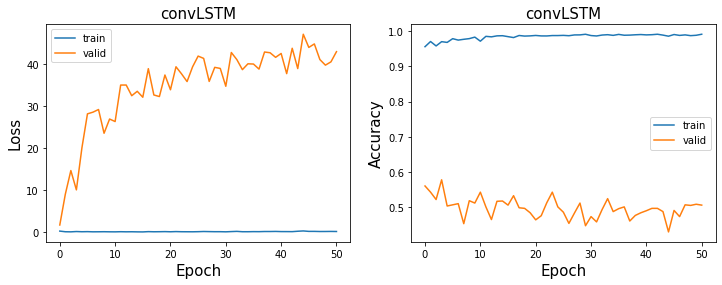

<ipython-input-14-894d578093d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = torch.tensor(outputs).to(device)


validation loss:1.7287451028823853 accuracy:0.5735785953177257
test loss:0.9437992572784424 accuracy:0.7324407826982492
0.8403708
/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN3_DO0.1_HD10_balanced_valcm.pt


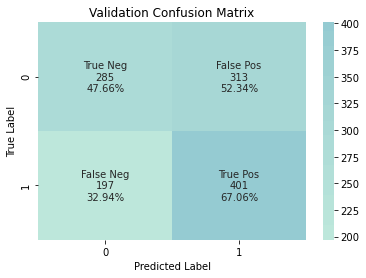

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN3_DO0.1_HD10_balanced_testcm.pt


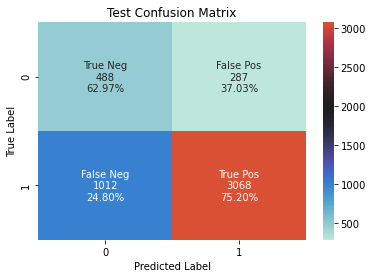

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN3_DO0.3_HD10_EPOCH0_balanced.pt
best epoch training accuracy:  0.9276015539546637


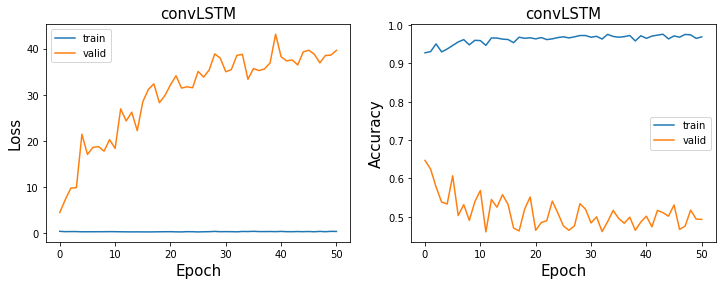

validation loss:4.517236232757568 accuracy:0.6413043478260869
test loss:0.659366250038147 accuracy:0.8677651905252317
0.8403708
/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN3_DO0.3_HD10_balanced_valcm.pt


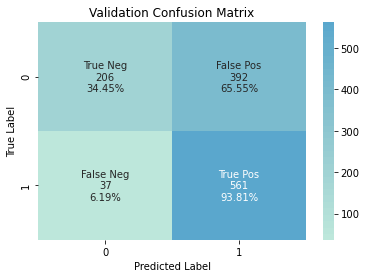

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN3_DO0.3_HD10_balanced_testcm.pt


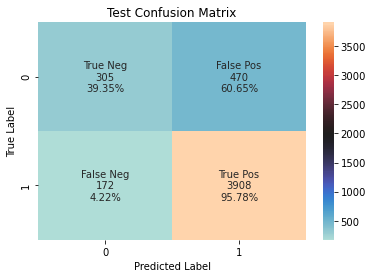

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN3_DO0.5_HD10_EPOCH0_balanced.pt
best epoch training accuracy:  0.8980500132010711


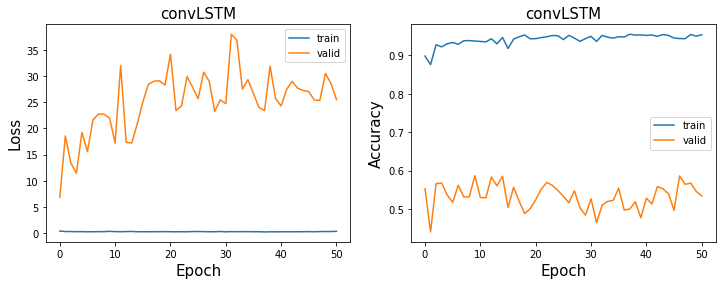

validation loss:6.961560249328613 accuracy:0.5493311036789298
test loss:1.34407639503479 accuracy:0.8376930998970133
0.8403708
/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN3_DO0.5_HD10_balanced_valcm.pt


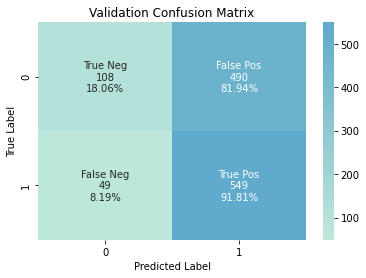

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN3_DO0.5_HD10_balanced_testcm.pt


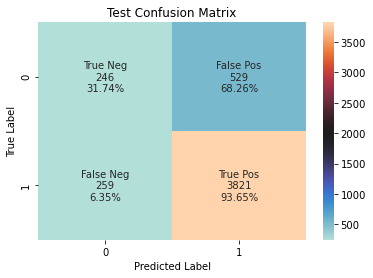

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN3_DO0.1_HD15_EPOCH0_balanced.pt
best epoch training accuracy:  0.9479500622336212


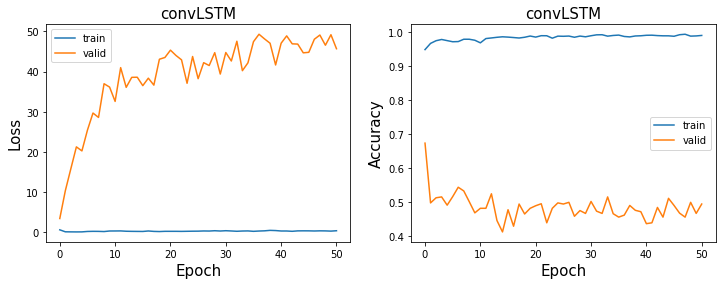

validation loss:3.467235565185547 accuracy:0.6680602006688964
test loss:0.5935251116752625 accuracy:0.8650875386199794
0.8403708
/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN3_DO0.1_HD15_balanced_valcm.pt


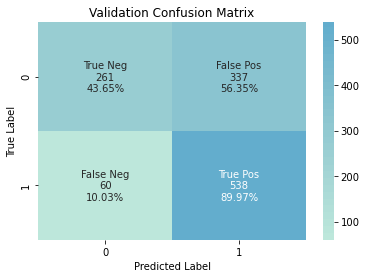

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN3_DO0.1_HD15_balanced_testcm.pt


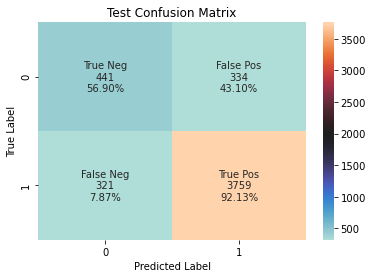

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN3_DO0.3_HD15_EPOCH0_balanced.pt
best epoch training accuracy:  0.9360879568513559


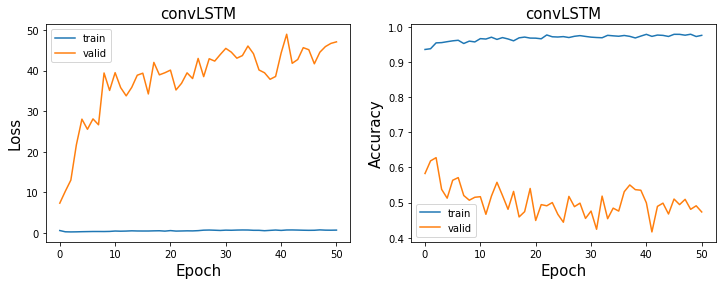

validation loss:7.603940010070801 accuracy:0.5827759197324415
test loss:1.076335072517395 accuracy:0.854788877445932
0.8403708
/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN3_DO0.3_HD15_balanced_valcm.pt


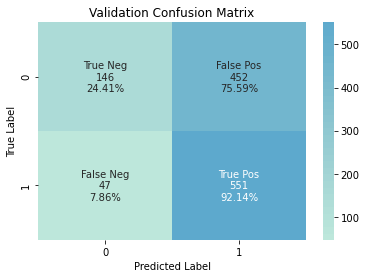

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN3_DO0.3_HD15_balanced_testcm.pt


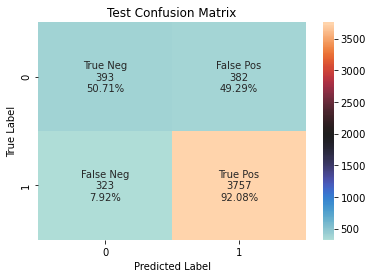

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN3_DO0.5_HD15_EPOCH0_balanced.pt
best epoch training accuracy:  0.897352242296232


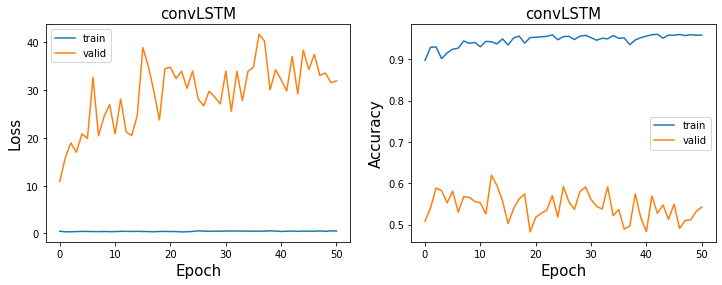

validation loss:11.321569442749023 accuracy:0.5209030100334449
test loss:2.537146806716919 accuracy:0.7975283213182286
0.8403708
/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN3_DO0.5_HD15_balanced_valcm.pt


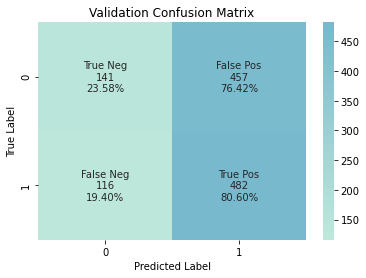

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN3_DO0.5_HD15_balanced_testcm.pt


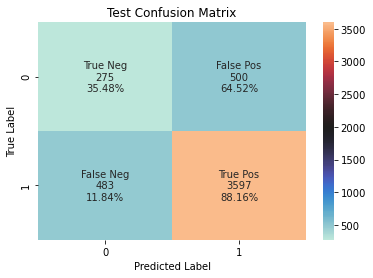

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN3_DO0.1_HD48_EPOCH6_balanced.pt
best epoch training accuracy:  0.9361822502168747


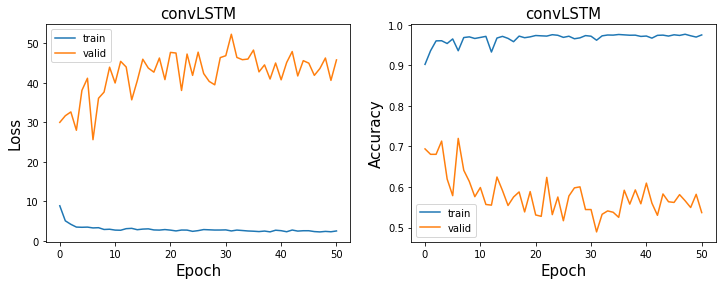

validation loss:27.708560943603516 accuracy:0.7048494983277592
test loss:9.331586837768555 accuracy:0.8729145211122554
0.8403708
/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN3_DO0.1_HD48_balanced_valcm.pt


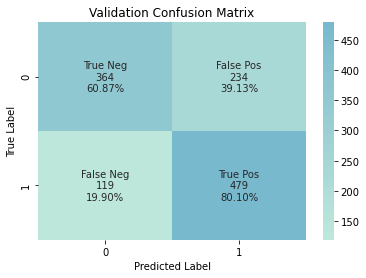

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN3_DO0.1_HD48_balanced_testcm.pt


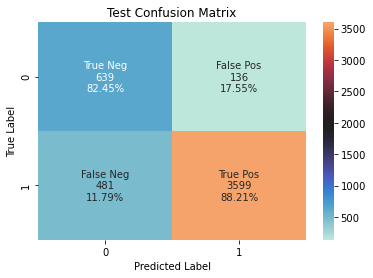

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN3_DO0.3_HD48_EPOCH1_balanced.pt
best epoch training accuracy:  0.9488552785426018


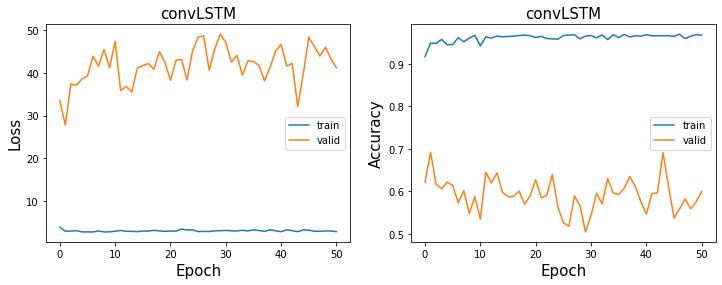

validation loss:27.307485580444336 accuracy:0.6906354515050167
test loss:5.559157848358154 accuracy:0.9223480947476828
0.8403708
/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN3_DO0.3_HD48_balanced_valcm.pt


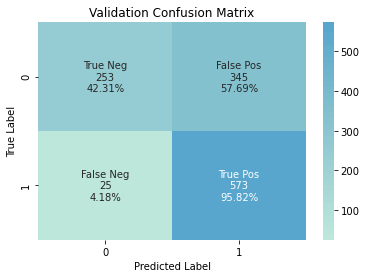

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN3_DO0.3_HD48_balanced_testcm.pt


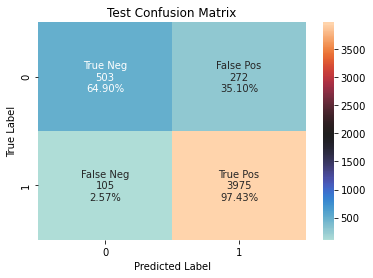

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN3_DO0.5_HD48_EPOCH4_balanced.pt
best epoch training accuracy:  0.9491381586391582


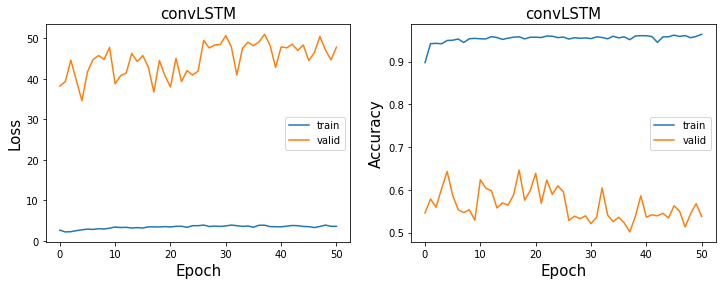

validation loss:34.38023376464844 accuracy:0.6413043478260869
test loss:7.576408863067627 accuracy:0.9023686920700309
0.8403708
/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN3_DO0.5_HD48_balanced_valcm.pt


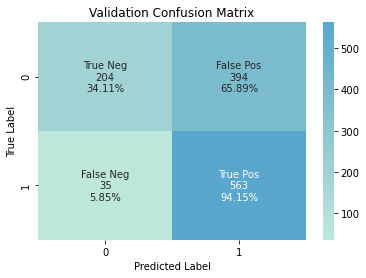

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN3_DO0.5_HD48_balanced_testcm.pt


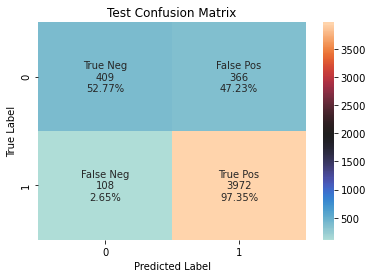

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN3_DO0.1_HD56_EPOCH4_balanced.pt
best epoch training accuracy:  0.9579263003055105


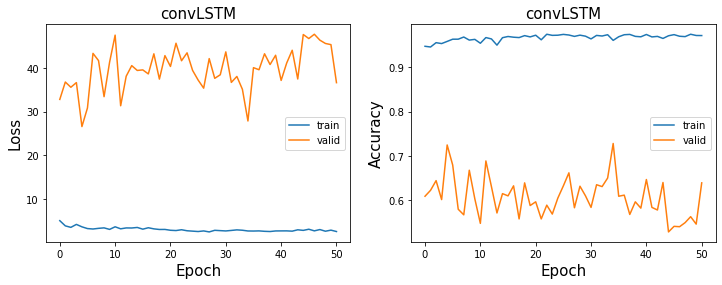

validation loss:25.885211944580078 accuracy:0.7332775919732442
test loss:13.49462890625 accuracy:0.8286302780638517
0.8403708
/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN3_DO0.1_HD56_balanced_valcm.pt


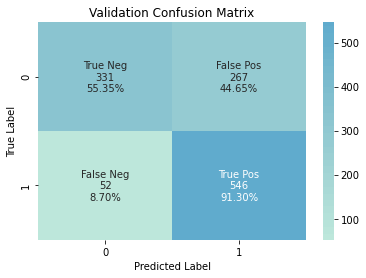

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN3_DO0.1_HD56_balanced_testcm.pt


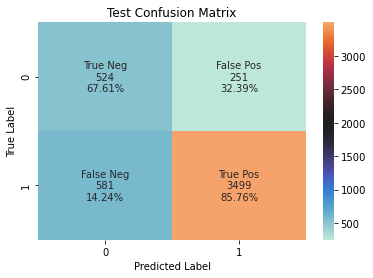

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN3_DO0.3_HD56_EPOCH0_balanced.pt
best epoch training accuracy:  0.9319956247878399


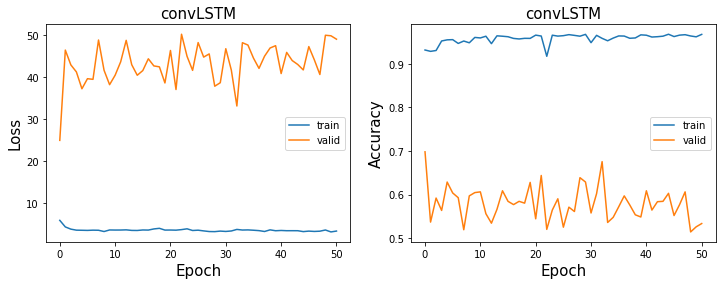

validation loss:24.278793334960938 accuracy:0.7073578595317725
test loss:8.729364395141602 accuracy:0.8556127703398558
0.8403708
/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN3_DO0.3_HD56_balanced_valcm.pt


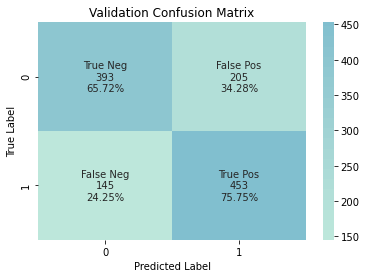

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN3_DO0.3_HD56_balanced_testcm.pt


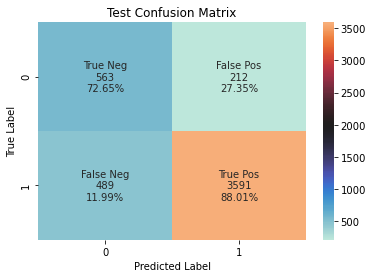

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN3_DO0.5_HD56_EPOCH4_balanced.pt
best epoch training accuracy:  0.946309357673594


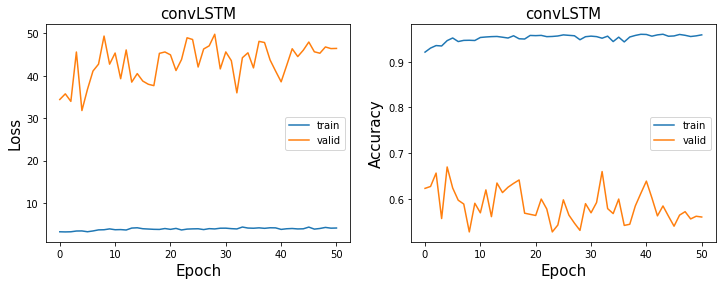

validation loss:32.41996765136719 accuracy:0.6647157190635451
test loss:9.362773895263672 accuracy:0.8809474768280123
0.8403708
/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN3_DO0.5_HD56_balanced_valcm.pt


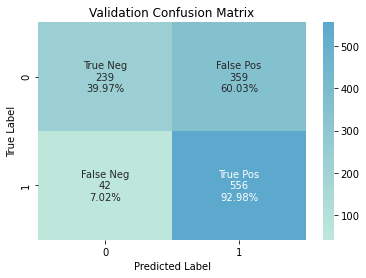

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN3_DO0.5_HD56_balanced_testcm.pt


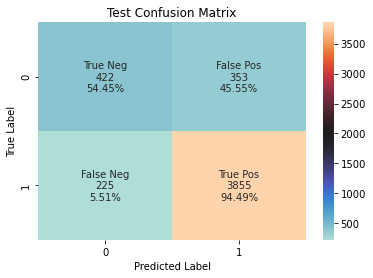

In [19]:
for i,(index,row) in enumerate(best_results.iterrows()):

    best_epoch = int(row)
    hidden = int(index[0])
    dropout = index[1]
    alpha = 0
    
    
    # load best model
    model = convLSTM(input_dim = 62, hidden_dim = hidden).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    model.load_state_dict(torch.load('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_TLEN{}_DO{}_HD{}_EPOCH{}_balanced.pt'.format(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow, T_length, dropout, hidden,best_epoch)))
    
    print('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_TLEN{}_DO{}_HD{}_EPOCH{}_balanced.pt'.format(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow,T_length, dropout, hidden,best_epoch))

    # Print training accuracy
    plot_train_result_file(model_saving_path, model_type,ch, loss_type, reg_type, alpha, timewindow, T_length, dropout, hidden, best_epoch)
    
    ## Calculate validation accuracy and validation loss
    val_loss, val_acc, val_preds, val_labels = evaluate(model, optimizer, criterion, val_loader, device='cuda', collect_result = True)
    print('validation loss:{} accuracy:{}'.format(val_loss, val_acc))
    
    ## Calculate test accuracy and test loss
    test_loss, test_acc, test_preds, test_labels = evaluate(model, optimizer, criterion, test_loader, device='cuda', collect_result = True)
    print('test loss:{} accuracy:{}'.format(test_loss, test_acc))
    print(np.mean(np.concatenate(test_labels)))
    
    ## Confusion matrix-validation
    predictions_val = np.concatenate(val_preds)
    labels_val = np.concatenate(val_labels)
    
    val_cm_filename = '{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_TLEN{}_DO{}_HD{}_balanced_valcm.pt'.format(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow, T_length, dropout,hidden)
    print(val_cm_filename)
    val_cm_result = {'predictions_val': predictions_val, 'labels_val' : labels_val}

    pickle.dump( val_cm_result, open( val_cm_filename, "wb" ) )
    
    
    df_val = pd.DataFrame({'predictions': predictions_val, 'labels': labels_val})

    cm_val = confusion_matrix(labels_val, predictions_val)
    ax = plt.axes()
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cm_val.flatten()]

    TNR = int(group_counts[0]) / (int(group_counts[0])+int(group_counts[1]))
    FPR = 1 - TNR
    TPR = int(group_counts[3]) / (int(group_counts[3])+int(group_counts[2]))
    FNR = 1-TPR
    group_percentages =[TNR, FPR, FNR, TPR]

    group_percentages = ["{0:.2%}".format(value) for value in
                         group_percentages]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sn.heatmap(cm_val, annot=labels, fmt='', center = 2000)
    ax.set_title('Validation Confusion Matrix')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    plt.show()
    
    ## Confusion matrix-test
    predictions_test = np.concatenate(test_preds)
    labels_test = np.concatenate(test_labels)

    test_cm_filename = '{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_TLEN{}_DO{}_HD{}_balanced_testcm.pt'.format(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow, T_length, dropout,hidden)
    print(test_cm_filename)
    test_cm_result = {'predictions_test': predictions_test, 'labels_val' : labels_test}

    pickle.dump( test_cm_result, open( test_cm_filename, "wb" ) )

    df_test = pd.DataFrame({'predictions': predictions_test, 'labels': labels_test})

    cm_test = confusion_matrix(labels_test, predictions_test)
    ax = plt.axes()
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cm_test.flatten()]

    TNR = int(group_counts[0]) / (int(group_counts[0])+int(group_counts[1]))
    FPR = 1 - TNR
    TPR = int(group_counts[3]) / (int(group_counts[3])+int(group_counts[2]))
    FNR = 1-TPR
    group_percentages =[TNR, FPR, FNR, TPR]

    group_percentages = ["{0:.2%}".format(value) for value in
                         group_percentages]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sn.heatmap(cm_test, annot=labels, fmt='', center = 2000)
    ax.set_title('Test Confusion Matrix')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    plt.show()
    


### Unbalanced result

In [17]:
results = []
for h in hidden_dim:
    for d in dropout:
        model_convLSTM = os.listdir(model_saving_path)

        best_result = 0
        reg_alpha = 'REG'+reg_type+str(alpha)+'_'
        dropout_type = 'DO'+str(d)
        hidden_type = 'HD'+str(h)
        t_len = 'TLEN'+str(T_length)
        for i, s in enumerate(model_convLSTM):
            if 'convLSTM_CHall_' in s and reg_alpha in s and dropout_type in s and 'trainresult' not in s and hidden_type in s and t_len in s and 'valcm' not in s and 'testcm' not in s and 'balanced' not in s:
                model_name = model_convLSTM[i].split('_')
                epoch_name = [ind for ind,item in enumerate(np.array(model_name)) if "EPOCH" in item]
                res = [int(i) for i in model_name[epoch_name[0]] if i.isdigit()]
                if len(res) > 1:
                    epoch_result = res[0]*10+res[1]
                else:
                    epoch_result = res[0]
                if epoch_result>best_result and epoch_result != 50:
                    best_result = epoch_result

        results.append([h,d,best_result])

results = pd.DataFrame(np.array(results), columns=['hidden','dropout', 'epoch'])
best_results = results.groupby(['hidden','dropout']).max('epoch')
print(best_results)


                epoch
hidden dropout       
10.0   0.1        0.0
       0.3        1.0
       0.5        1.0
15.0   0.1        0.0
       0.3        0.0
       0.5        0.0
48.0   0.1        1.0
       0.3        0.0
       0.5        1.0
56.0   0.1        2.0
       0.3        4.0
       0.5        3.0


In [18]:
def plot_train_result_file(model_saving_path, model_type, num_channel, loss_type, reg_type, alpha, timewindow, T_length, dropout, hidden, best_epoch):
    fb = '{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_TLEN{}_DO{}_HD{}_EPOCH50_trainresult.pt'.format(model_saving_path, model_type, num_channel, loss_type, reg_type, alpha, timewindow, T_length, dropout, hidden)
    file = open(fb,'rb')
    train_result = pickle.load(file)
    train_losses = train_result['train_losses']
    val_losses = train_result['val_losses']
    train_accs = train_result['train_accs']
    val_accs = train_result['val_accs']
    model_type = train_result['model_type']
    print('best epoch training accuracy: ', train_accs[best_epoch])
    plot_loss_acc(train_losses, val_losses, train_accs, val_accs, model_type)
    

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN3_DO0.1_HD10_EPOCH0.pt
best epoch training accuracy:  0.9481009316184513


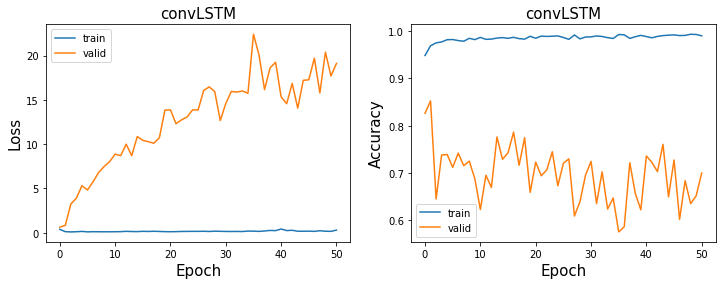

<ipython-input-14-894d578093d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = torch.tensor(outputs).to(device)


validation loss:0.6379931569099426 accuracy:0.8260869565217391
test loss:0.5752755999565125 accuracy:0.8337796086508754
0.8403708
/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN3_DO0.1_HD10_valcm.pt


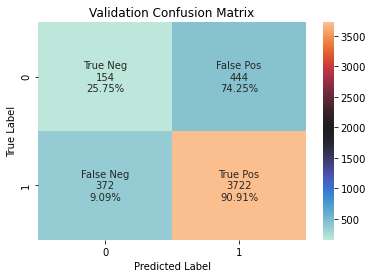

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN3_DO0.1_HD10_testcm.pt


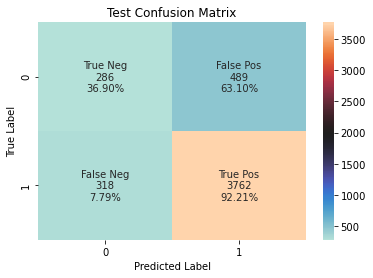

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN3_DO0.3_HD10_EPOCH1.pt
best epoch training accuracy:  0.9230754724097613


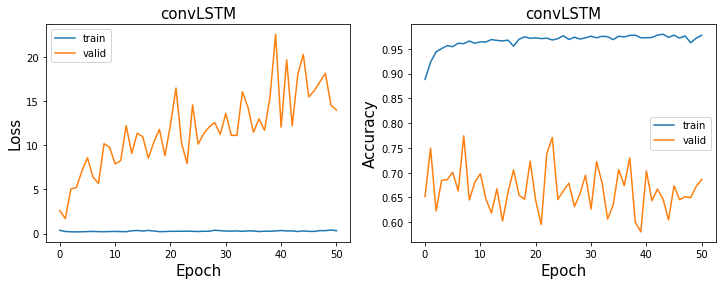

validation loss:1.7243642807006836 accuracy:0.7495737425404945
test loss:1.6575467586517334 accuracy:0.7542739443872296
0.8403708
/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN3_DO0.3_HD10_valcm.pt


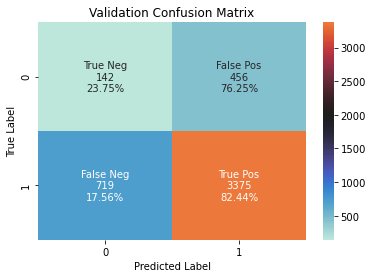

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN3_DO0.3_HD10_testcm.pt


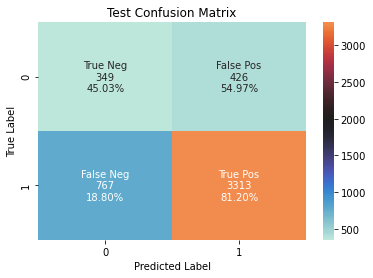

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN3_DO0.5_HD10_EPOCH1.pt
best epoch training accuracy:  0.9173612944593218


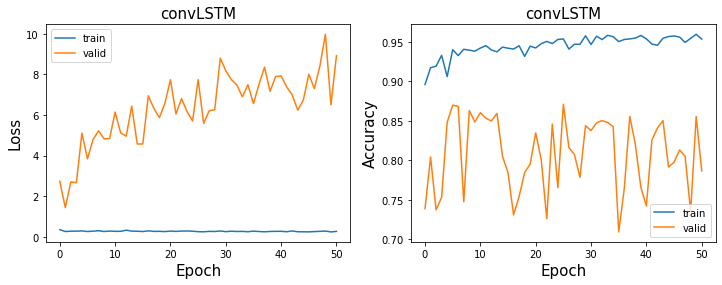

validation loss:1.4267725944519043 accuracy:0.8043478260869565
test loss:0.6704539656639099 accuracy:0.8622039134912461
0.8403708
/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN3_DO0.5_HD10_valcm.pt


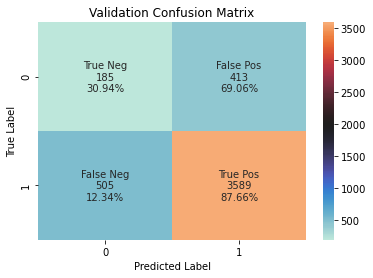

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN3_DO0.5_HD10_testcm.pt


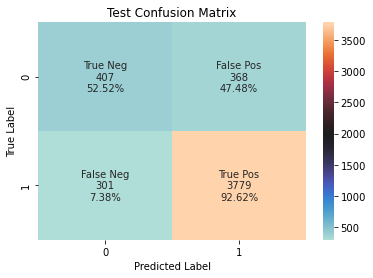

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN3_DO0.1_HD15_EPOCH0.pt
best epoch training accuracy:  0.9570776600158413


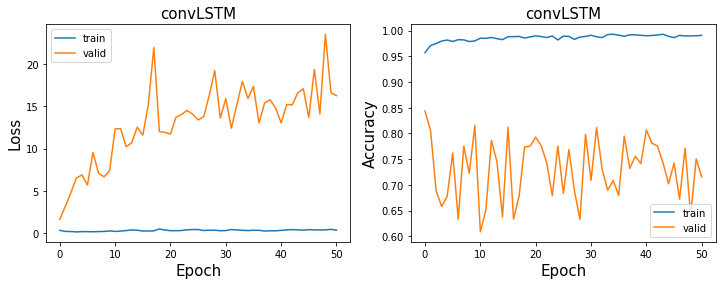

validation loss:1.594344973564148 accuracy:0.8433503836317136
test loss:0.8446528911590576 accuracy:0.8671472708547889
0.8403708
/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN3_DO0.1_HD15_valcm.pt


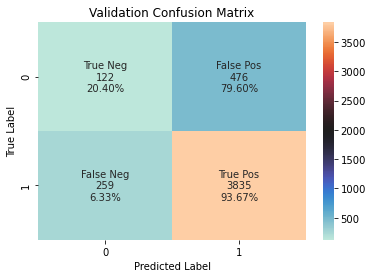

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN3_DO0.1_HD15_testcm.pt


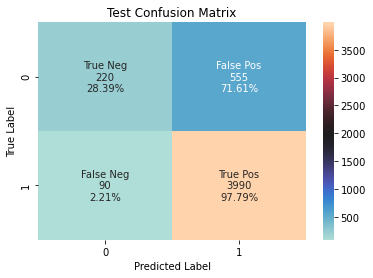

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN3_DO0.3_HD15_EPOCH0.pt
best epoch training accuracy:  0.9318070380568023


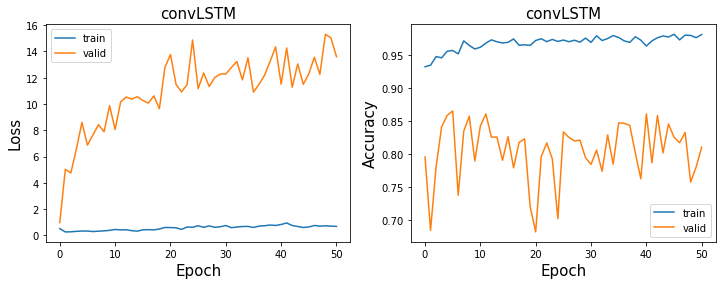

validation loss:0.9846545457839966 accuracy:0.7951832907075874
test loss:0.7956128120422363 accuracy:0.8343975283213182
0.8403708
/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN3_DO0.3_HD15_valcm.pt


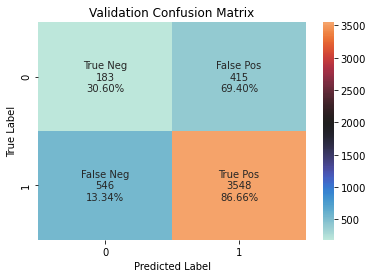

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN3_DO0.3_HD15_testcm.pt


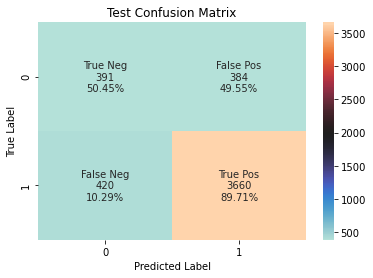

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN3_DO0.5_HD15_EPOCH0.pt
best epoch training accuracy:  0.8838871497001471


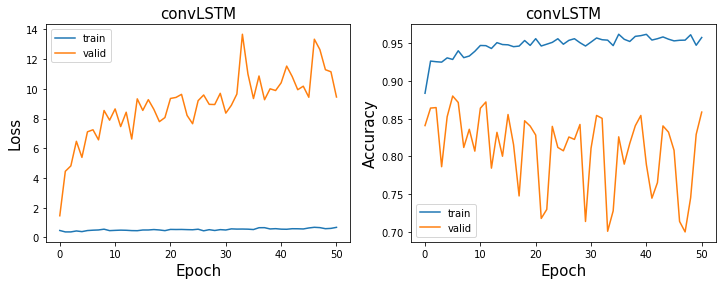

validation loss:1.4640741348266602 accuracy:0.841005967604433
test loss:0.9246810078620911 accuracy:0.8556127703398558
0.8403708
/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN3_DO0.5_HD15_valcm.pt


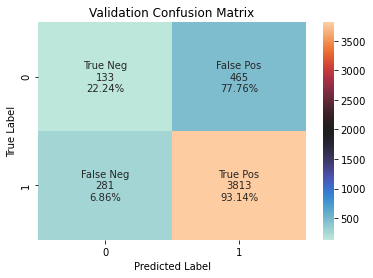

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN3_DO0.5_HD15_testcm.pt


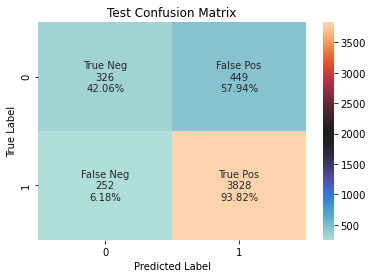

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN3_DO0.1_HD48_EPOCH1.pt
best epoch training accuracy:  0.9211707464262815


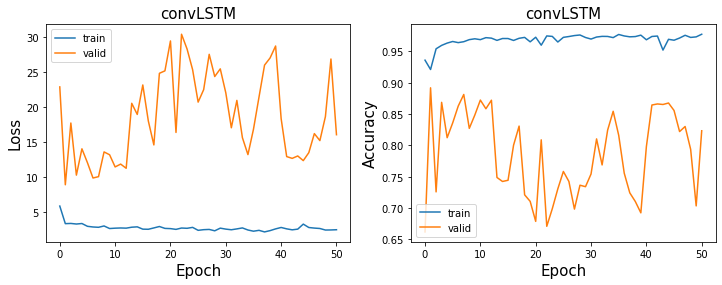

validation loss:8.934927940368652 accuracy:0.8919437340153452
test loss:12.004899024963379 accuracy:0.8572605561277034
0.8403708
/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN3_DO0.1_HD48_valcm.pt


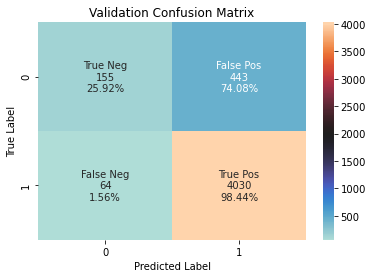

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN3_DO0.1_HD48_testcm.pt


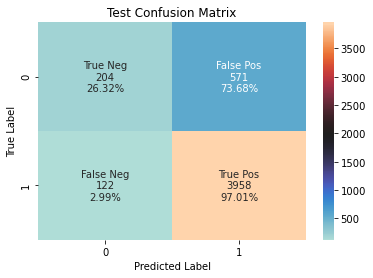

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN3_DO0.3_HD48_EPOCH0.pt
best epoch training accuracy:  0.934748991060989


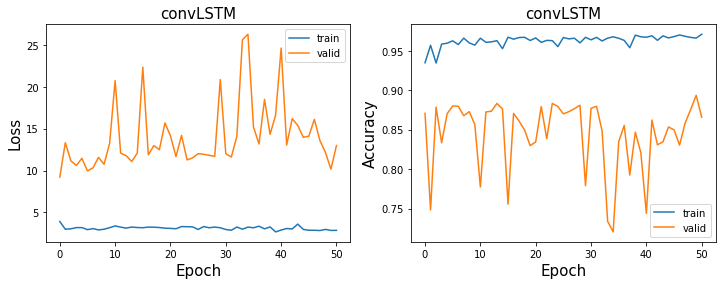

validation loss:9.220062255859375 accuracy:0.8706308610400681
test loss:10.350340843200684 accuracy:0.8370751802265706
0.8403708
/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN3_DO0.3_HD48_valcm.pt


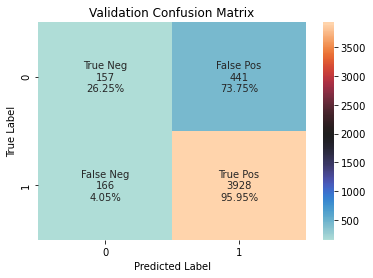

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN3_DO0.3_HD48_testcm.pt


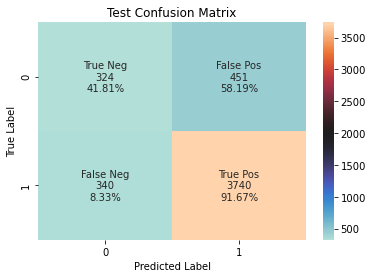

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN3_DO0.5_HD48_EPOCH1.pt
best epoch training accuracy:  0.9325236676347453


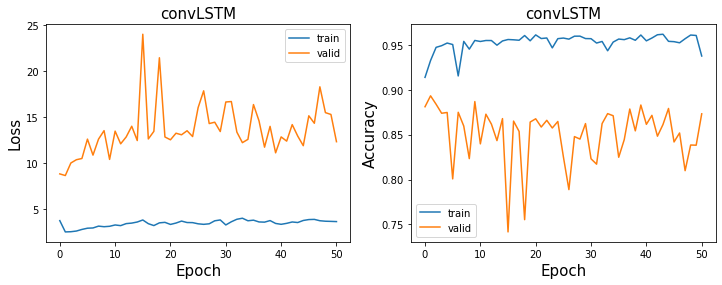

validation loss:8.659804344177246 accuracy:0.8932225063938619
test loss:9.972423553466797 accuracy:0.8692070030895983
0.8403708
/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN3_DO0.5_HD48_valcm.pt


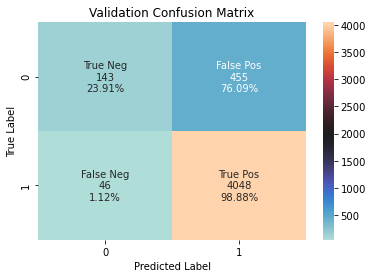

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN3_DO0.5_HD48_testcm.pt


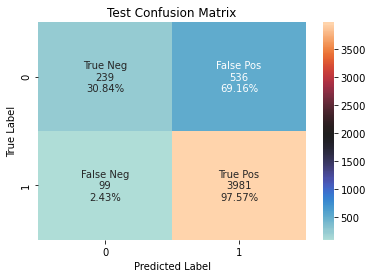

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN3_DO0.1_HD56_EPOCH2.pt
best epoch training accuracy:  0.9523252743936936


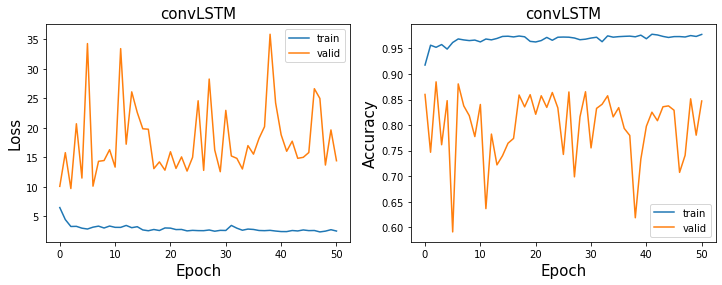

validation loss:9.67603588104248 accuracy:0.8846973572037511
test loss:12.075434684753418 accuracy:0.8599382080329557
0.8403708
/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN3_DO0.1_HD56_valcm.pt


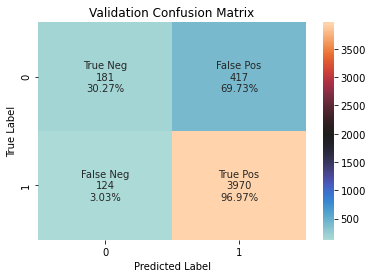

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN3_DO0.1_HD56_testcm.pt


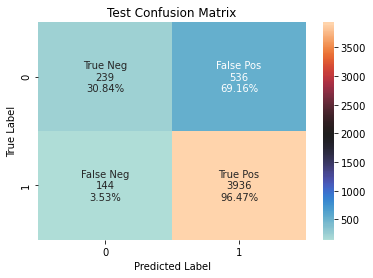

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN3_DO0.3_HD56_EPOCH4.pt
best epoch training accuracy:  0.9479877795798287


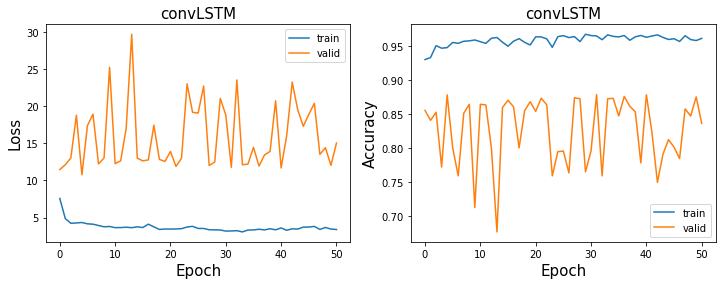

validation loss:10.790316581726074 accuracy:0.8785166240409207
test loss:9.263998985290527 accuracy:0.9011328527291452
0.8403708
/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN3_DO0.3_HD56_valcm.pt


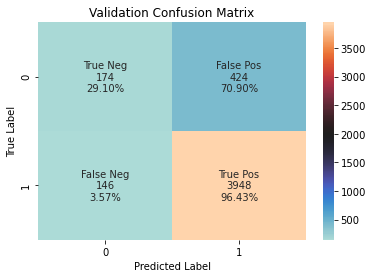

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN3_DO0.3_HD56_testcm.pt


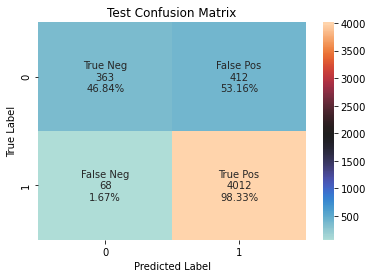

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN3_DO0.5_HD56_EPOCH3.pt
best epoch training accuracy:  0.9477426168294799


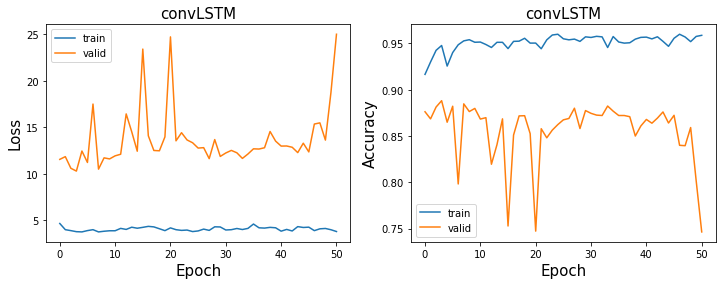

validation loss:10.310503005981445 accuracy:0.8881074168797954
test loss:10.058525085449219 accuracy:0.893923789907312
0.8403708
/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN3_DO0.5_HD56_valcm.pt


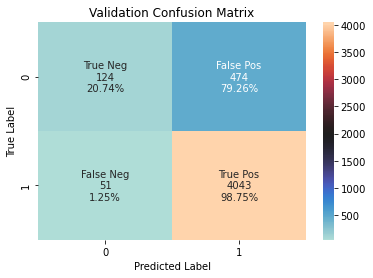

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN3_DO0.5_HD56_testcm.pt


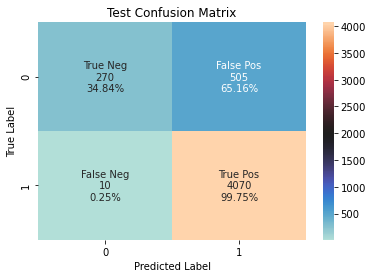

In [19]:
for i,(index,row) in enumerate(best_results.iterrows()):

    best_epoch = int(row)
    hidden = int(index[0])
    dropout = index[1]
    alpha = 0
    
    
    # load best model
    model = convLSTM(input_dim = 62, hidden_dim = hidden).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    model.load_state_dict(torch.load('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_TLEN{}_DO{}_HD{}_EPOCH{}.pt'.format(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow, T_length, dropout, hidden,best_epoch)))
    
    print('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_TLEN{}_DO{}_HD{}_EPOCH{}.pt'.format(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow,T_length, dropout, hidden,best_epoch))

    # Print training accuracy
    plot_train_result_file(model_saving_path, model_type,ch, loss_type, reg_type, alpha, timewindow, T_length, dropout, hidden, best_epoch)
    
    ## Calculate validation accuracy and validation loss
    val_loss, val_acc, val_preds, val_labels = evaluate(model, optimizer, criterion, val_loader, device='cuda', collect_result = True)
    print('validation loss:{} accuracy:{}'.format(val_loss, val_acc))
    
    ## Calculate test accuracy and test loss
    test_loss, test_acc, test_preds, test_labels = evaluate(model, optimizer, criterion, test_loader, device='cuda', collect_result = True)
    print('test loss:{} accuracy:{}'.format(test_loss, test_acc))
    print(np.mean(np.concatenate(test_labels)))
    
    ## Confusion matrix-validation
    predictions_val = np.concatenate(val_preds)
    labels_val = np.concatenate(val_labels)
    
    val_cm_filename = '{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_TLEN{}_DO{}_HD{}_valcm.pt'.format(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow, T_length, dropout,hidden)
    print(val_cm_filename)
    val_cm_result = {'predictions_val': predictions_val, 'labels_val' : labels_val}

    pickle.dump( val_cm_result, open( val_cm_filename, "wb" ) )
    
    
    df_val = pd.DataFrame({'predictions': predictions_val, 'labels': labels_val})

    cm_val = confusion_matrix(labels_val, predictions_val)
    ax = plt.axes()
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cm_val.flatten()]

    TNR = int(group_counts[0]) / (int(group_counts[0])+int(group_counts[1]))
    FPR = 1 - TNR
    TPR = int(group_counts[3]) / (int(group_counts[3])+int(group_counts[2]))
    FNR = 1-TPR
    group_percentages =[TNR, FPR, FNR, TPR]

    group_percentages = ["{0:.2%}".format(value) for value in
                         group_percentages]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sn.heatmap(cm_val, annot=labels, fmt='', center = 2000)
    ax.set_title('Validation Confusion Matrix')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    plt.show()
    
    ## Confusion matrix-test
    predictions_test = np.concatenate(test_preds)
    labels_test = np.concatenate(test_labels)

    test_cm_filename = '{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_TLEN{}_DO{}_HD{}_testcm.pt'.format(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow, T_length, dropout,hidden)
    print(test_cm_filename)
    test_cm_result = {'predictions_test': predictions_test, 'labels_val' : labels_test}

    pickle.dump( test_cm_result, open( test_cm_filename, "wb" ) )

    df_test = pd.DataFrame({'predictions': predictions_test, 'labels': labels_test})

    cm_test = confusion_matrix(labels_test, predictions_test)
    ax = plt.axes()
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cm_test.flatten()]

    TNR = int(group_counts[0]) / (int(group_counts[0])+int(group_counts[1]))
    FPR = 1 - TNR
    TPR = int(group_counts[3]) / (int(group_counts[3])+int(group_counts[2]))
    FNR = 1-TPR
    group_percentages =[TNR, FPR, FNR, TPR]

    group_percentages = ["{0:.2%}".format(value) for value in
                         group_percentages]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sn.heatmap(cm_test, annot=labels, fmt='', center = 2000)
    ax.set_title('Test Confusion Matrix')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    plt.show()
    


## T-length = 5

In [23]:
time_window = 10
T_length = 5
## Load files
move_files, sleep_files = create_files_new(load_path, bad_dates, T_length=T_length, proceed=1)
train_files, val_files, test_files = [], [], []

## Put files in val, test, and train
for f in move_files+sleep_files:
    if f:
        if f[0][1][3] in val_dates:
            val_files.extend(f)
        elif f[0][1][3] in test_dates:
            test_files.extend(f)
        else:
            train_files.extend(f)           

In [24]:
## Randomly shuffle inside train, val, and test
random.shuffle(train_files)
random.shuffle(val_files)
random.shuffle(test_files)

In [25]:
## Upsample train
train_files = upsample(train_files)

In [26]:
## Balance val 
sleep_files = []
move_files = []
for t in range(len(val_files)):
    if 'sleep' in val_files[t][0]:
        sleep_files.append(val_files[t])
    if 'move' in val_files[t][0]:
        move_files.append(val_files[t])

sleep_sample = sample(sleep_files, len(move_files))
val_2_files = sleep_sample+move_files

In [27]:
len(train_files), len(val_files), len(test_files)

(45990, 3967, 3968)

In [28]:
## Load files to dataloader
T_length = 5

# train_dataset = SpectrogramDatasetAtt(files=train_files, load_path=load_path, T_length=T_length, all_label=True)
# valid_dataset = SpectrogramDatasetAtt(files=val_2_files, load_path=load_path, T_length=T_length, all_label=True)
# test_dataset = SpectrogramDatasetAtt(files=test_files, load_path=load_path, T_length=T_length, all_label=True)

train_dataset = SpectrogramDatasetAtt(files=train_files, load_path=load_path, T_length=T_length, all_label=True)
valid_dataset = SpectrogramDatasetAtt(files=val_files, load_path=load_path, T_length=T_length, all_label=True)
test_dataset = SpectrogramDatasetAtt(files=test_files, load_path=load_path, T_length=T_length, all_label=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle = True)
val_loader = DataLoader(dataset=valid_dataset, batch_size=128, shuffle = False)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle = False)

### Training

In [29]:
device = torch.device('cuda')

tol = 0.01
learning_rate = 0.01
num_epochs = 51
alpha = 0
model_type = 'convLSTM'
loss_type = 'bce'
reg_type = 'none'
alpha = 0
timewindow = 10
ch = 'all'
# verbose = False

dropout = [0.1,0.3,0.5]
hidden_dim = [10,15,48,56]


convLSTM(
  (convLSTM): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(72, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (dropout): Dropout2d(p=0.1, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=10000, out_features=1, bias=True)
)


<ipython-input-14-894d578093d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = torch.tensor(outputs).to(device)


0
Train loss for epoch 0: 0.32794249057769775
Val loss for epoch 0: 2.000746488571167
Train loss for epoch 1: 0.1333947479724884
Val loss for epoch 1: 7.062675476074219
Train loss for epoch 2: 0.11698755621910095
Val loss for epoch 2: 9.887446403503418
Train loss for epoch 3: 0.12152047455310822
Val loss for epoch 3: 16.411352157592773
Train loss for epoch 4: 0.10878250747919083
Val loss for epoch 4: 21.06667137145996
Train loss for epoch 5: 0.11112214624881744
Val loss for epoch 5: 23.028282165527344
Train loss for epoch 6: 0.13038277626037598
Val loss for epoch 6: 24.184459686279297
Train loss for epoch 7: 0.147702157497406
Val loss for epoch 7: 30.768110275268555
Train loss for epoch 8: 0.13603881001472473
Val loss for epoch 8: 25.466411590576172
Train loss for epoch 9: 0.16688711941242218
Val loss for epoch 9: 31.544401168823242
Train loss for epoch 10: 0.20225128531455994
Val loss for epoch 10: 33.440128326416016
Train loss for epoch 11: 0.1643095463514328
Val loss for epoch 11: 3

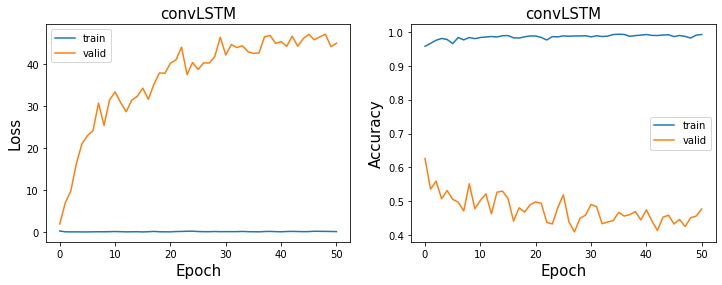

convLSTM(
  (convLSTM): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(72, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (dropout): Dropout2d(p=0.3, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=10000, out_features=1, bias=True)
)
0
Train loss for epoch 0: 0.4013887345790863
Val loss for epoch 0: 3.454594135284424
Train loss for epoch 1: 0.22409337759017944
Val loss for epoch 1: 4.087880611419678
Train loss for epoch 2: 0.1958366483449936
Val loss for epoch 2: 8.852286338806152
Train loss for epoch 3: 0.1996379792690277
Val loss for epoch 3: 13.407002449035645
Train loss for epoch 4: 0.22409668564796448
Val loss for epoch 4: 10.681792259216309
Train loss for epoch 5: 0.2044304758310318
Val loss for epoch 5: 13.897831916809082
Train loss for epoch 6: 0.22572360932826996
Val loss for epoch 6: 21.88871955871582
Train loss for epoch 7: 0.2284994125366211
Val loss for epoch 7: 16.982009887695312
Train loss for epoch 8: 0

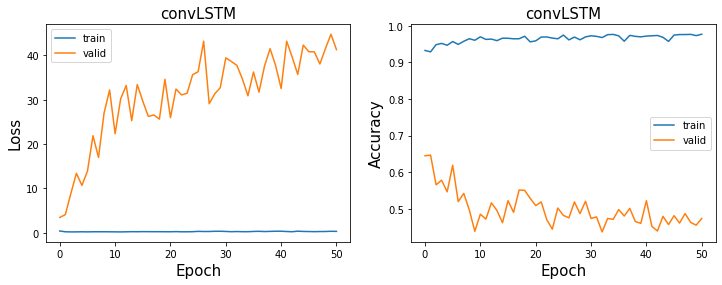

convLSTM(
  (convLSTM): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(72, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (dropout): Dropout2d(p=0.5, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=10000, out_features=1, bias=True)
)
0
Train loss for epoch 0: 0.3583313524723053
Val loss for epoch 0: 5.1814703941345215
Train loss for epoch 1: 0.3040998876094818
Val loss for epoch 1: 6.30206823348999
Train loss for epoch 2: 0.2778237760066986
Val loss for epoch 2: 13.170865058898926
Train loss for epoch 3: 0.2969617545604706
Val loss for epoch 3: 14.453694343566895
Train loss for epoch 4: 0.30100172758102417
Val loss for epoch 4: 11.690750122070312
Train loss for epoch 5: 0.28627142310142517
Val loss for epoch 5: 21.640989303588867
Train loss for epoch 6: 0.32082319259643555
Val loss for epoch 6: 21.85786247253418
Train loss for epoch 7: 0.28987231850624084
Val loss for epoch 7: 28.769821166992188
Train loss for epoch 8:

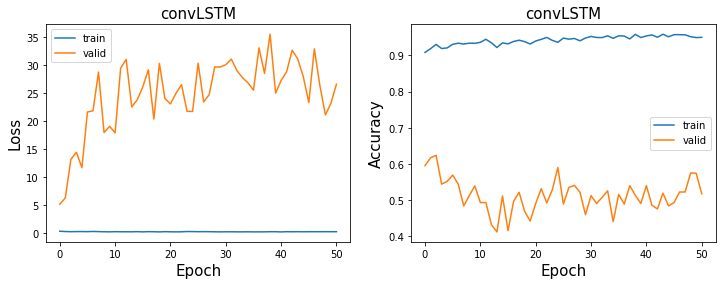

convLSTM(
  (convLSTM): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(77, 60, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (dropout): Dropout2d(p=0.1, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=15000, out_features=1, bias=True)
)
0
Train loss for epoch 0: 0.35447514057159424
Val loss for epoch 0: 1.930487036705017
Train loss for epoch 1: 0.14636768400669098
Val loss for epoch 1: 6.5522637367248535
Train loss for epoch 2: 0.1577080935239792
Val loss for epoch 2: 18.60112762451172
Train loss for epoch 3: 0.11419007182121277
Val loss for epoch 3: 22.411161422729492
Train loss for epoch 4: 0.15287062525749207
Val loss for epoch 4: 19.335830688476562
Train loss for epoch 5: 0.12770529091358185
Val loss for epoch 5: 18.48341178894043
Train loss for epoch 6: 0.17187952995300293
Val loss for epoch 6: 23.74884605407715
Train loss for epoch 7: 0.17143231630325317
Val loss for epoch 7: 31.599164962768555
Train loss for epoch 

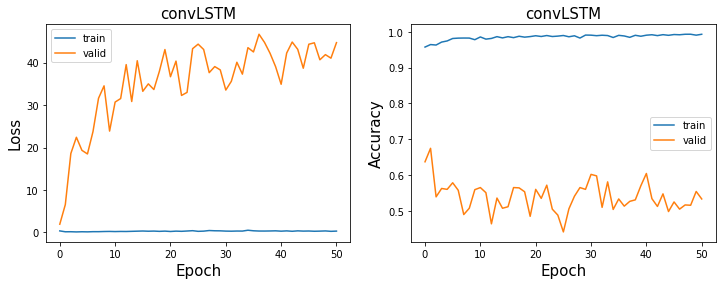

convLSTM(
  (convLSTM): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(77, 60, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (dropout): Dropout2d(p=0.3, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=15000, out_features=1, bias=True)
)
0
Train loss for epoch 0: 0.5836673974990845
Val loss for epoch 0: 9.860804557800293
1
Train loss for epoch 1: 0.3189866244792938
Val loss for epoch 1: 7.699958324432373
Train loss for epoch 2: 0.3137987554073334
Val loss for epoch 2: 12.700052261352539
Train loss for epoch 3: 0.32805532217025757
Val loss for epoch 3: 12.698158264160156
Train loss for epoch 4: 0.3007126748561859
Val loss for epoch 4: 22.64073944091797
Train loss for epoch 5: 0.3682672679424286
Val loss for epoch 5: 34.0186653137207
Train loss for epoch 6: 0.386321097612381
Val loss for epoch 6: 25.46792984008789
Train loss for epoch 7: 0.3993776738643646
Val loss for epoch 7: 25.967090606689453
Train loss for epoch 8: 0.41

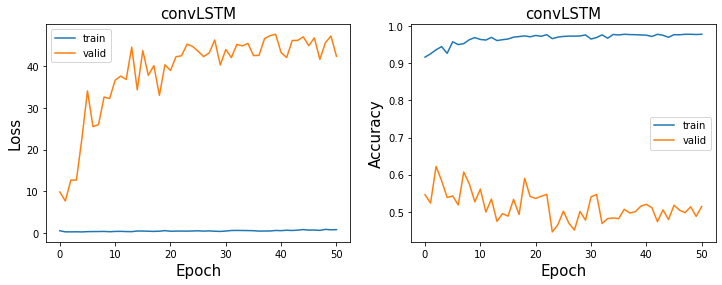

convLSTM(
  (convLSTM): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(77, 60, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (dropout): Dropout2d(p=0.5, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=15000, out_features=1, bias=True)
)
0
Train loss for epoch 0: 0.42067813873291016
Val loss for epoch 0: 15.037887573242188
1
Train loss for epoch 1: 0.3194442689418793
Val loss for epoch 1: 14.59606647491455
Train loss for epoch 2: 0.33660903573036194
Val loss for epoch 2: 15.157500267028809
Train loss for epoch 3: 0.36563873291015625
Val loss for epoch 3: 26.3867244720459
Train loss for epoch 4: 0.370771586894989
Val loss for epoch 4: 26.534360885620117
Train loss for epoch 5: 0.4456985890865326
Val loss for epoch 5: 37.70334243774414
Train loss for epoch 6: 0.39046573638916016
Val loss for epoch 6: 27.320266723632812
Train loss for epoch 7: 0.39805522561073303
Val loss for epoch 7: 37.59451675415039
Train loss for epoch 8:

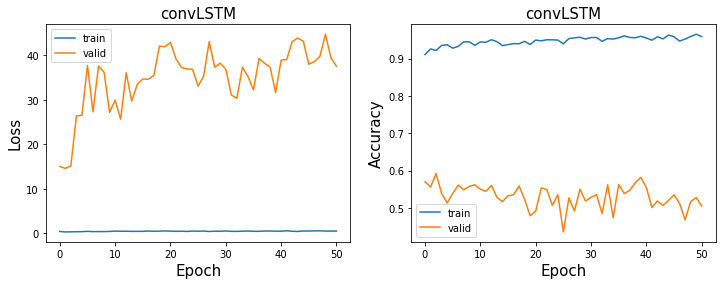

convLSTM(
  (convLSTM): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(110, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (dropout): Dropout2d(p=0.1, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=48000, out_features=1, bias=True)
)
0
Train loss for epoch 0: 5.785119533538818
Val loss for epoch 0: 24.44923973083496
Train loss for epoch 1: 3.7530946731567383
Val loss for epoch 1: 38.873680114746094
Train loss for epoch 2: 3.102536201477051
Val loss for epoch 2: 38.34196090698242
Train loss for epoch 3: 3.060112237930298
Val loss for epoch 3: 29.25064468383789
Train loss for epoch 4: 2.969712734222412
Val loss for epoch 4: 49.0867919921875
Train loss for epoch 5: 3.2923340797424316
Val loss for epoch 5: 45.86135482788086
Train loss for epoch 6: 3.2418055534362793
Val loss for epoch 6: 43.349700927734375
Train loss for epoch 7: 2.7582461833953857
Val loss for epoch 7: 43.761627197265625
Train loss for epoch 8: 2.834469

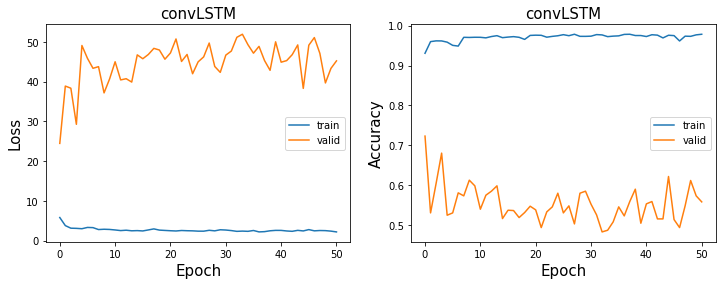

convLSTM(
  (convLSTM): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(110, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (dropout): Dropout2d(p=0.3, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=48000, out_features=1, bias=True)
)
0
Train loss for epoch 0: 4.142302513122559
Val loss for epoch 0: 41.04590606689453
1
Train loss for epoch 1: 3.2889301776885986
Val loss for epoch 1: 31.29450035095215
Train loss for epoch 2: 3.0830469131469727
Val loss for epoch 2: 45.24791717529297
Train loss for epoch 3: 2.955449104309082
Val loss for epoch 3: 40.94404220581055
Train loss for epoch 4: 2.96894907951355
Val loss for epoch 4: 35.986328125
Train loss for epoch 5: 3.1464297771453857
Val loss for epoch 5: 37.368526458740234
Train loss for epoch 6: 3.095546007156372
Val loss for epoch 6: 36.10111618041992
Train loss for epoch 7: 2.9948251247406006
Val loss for epoch 7: 35.7177848815918
Train loss for epoch 8: 3.136476516723

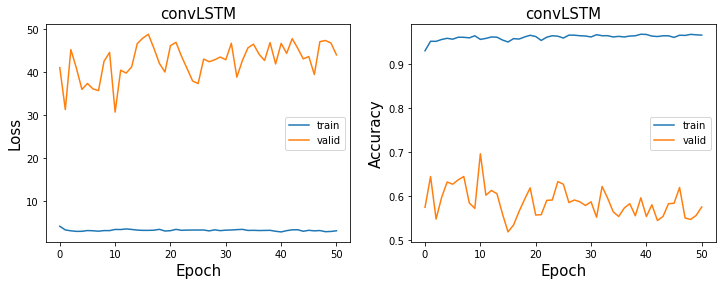

convLSTM(
  (convLSTM): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(110, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (dropout): Dropout2d(p=0.5, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=48000, out_features=1, bias=True)
)
0
Train loss for epoch 0: 2.902998208999634
Val loss for epoch 0: 22.5560245513916
Train loss for epoch 1: 2.1642727851867676
Val loss for epoch 1: 34.99162292480469
Train loss for epoch 2: 2.2025928497314453
Val loss for epoch 2: 35.389095306396484
Train loss for epoch 3: 2.425201177597046
Val loss for epoch 3: 43.268795013427734
Train loss for epoch 4: 2.601128339767456
Val loss for epoch 4: 46.252418518066406
Train loss for epoch 5: 2.824126720428467
Val loss for epoch 5: 46.191463470458984
Train loss for epoch 6: 3.0155792236328125
Val loss for epoch 6: 30.2840576171875
Train loss for epoch 7: 3.114652395248413
Val loss for epoch 7: 41.70604705810547
Train loss for epoch 8: 2.9355442

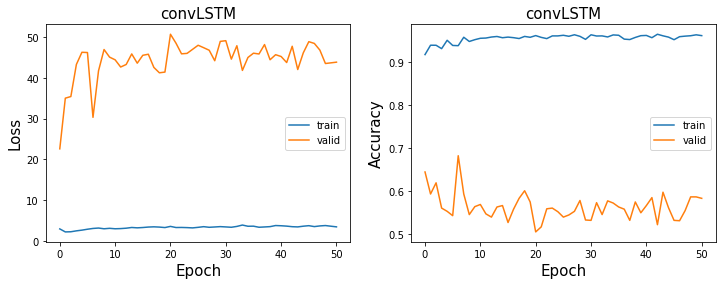

convLSTM(
  (convLSTM): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(118, 224, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (dropout): Dropout2d(p=0.1, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=56000, out_features=1, bias=True)
)
0
Train loss for epoch 0: 6.744421482086182
Val loss for epoch 0: 32.57895278930664
Train loss for epoch 1: 4.821185111999512
Val loss for epoch 1: 34.852500915527344
Train loss for epoch 2: 3.9676194190979004
Val loss for epoch 2: 45.18037033081055
3
Train loss for epoch 3: 3.5897817611694336
Val loss for epoch 3: 31.549087524414062
Train loss for epoch 4: 3.5157546997070312
Val loss for epoch 4: 36.60643005371094
Train loss for epoch 5: 3.531059503555298
Val loss for epoch 5: 40.3790168762207
Train loss for epoch 6: 3.520551919937134
Val loss for epoch 6: 31.823190689086914
Train loss for epoch 7: 3.0644662380218506
Val loss for epoch 7: 34.088844299316406
Train loss for epoch 8: 3.164

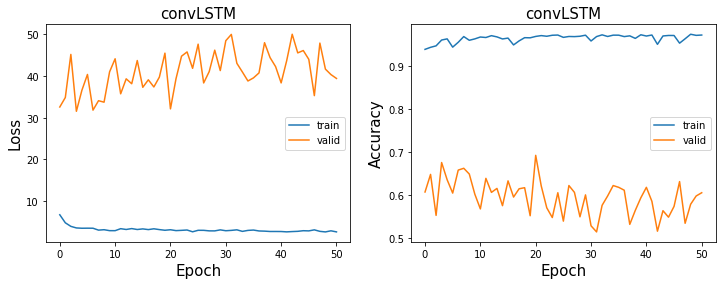

convLSTM(
  (convLSTM): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(118, 224, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (dropout): Dropout2d(p=0.3, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=56000, out_features=1, bias=True)
)
0
Train loss for epoch 0: 49.799564361572266
Val loss for epoch 0: 53.28125
1
Train loss for epoch 1: 49.99479675292969
Val loss for epoch 1: 53.28125
2
Train loss for epoch 2: 50.00520706176758
Val loss for epoch 2: 53.28125
3
Train loss for epoch 3: 50.00520706176758
Val loss for epoch 3: 53.28125
4
Train loss for epoch 4: 50.00520706176758
Val loss for epoch 4: 53.28125
5
Train loss for epoch 5: 50.0
Val loss for epoch 5: 53.28125
6
Train loss for epoch 6: 49.97917938232422
Val loss for epoch 6: 53.28125
7
Train loss for epoch 7: 49.98958969116211
Val loss for epoch 7: 53.28125
8
Train loss for epoch 8: 50.00520706176758
Val loss for epoch 8: 53.28125
9
Train loss for epoch 9: 49.9947

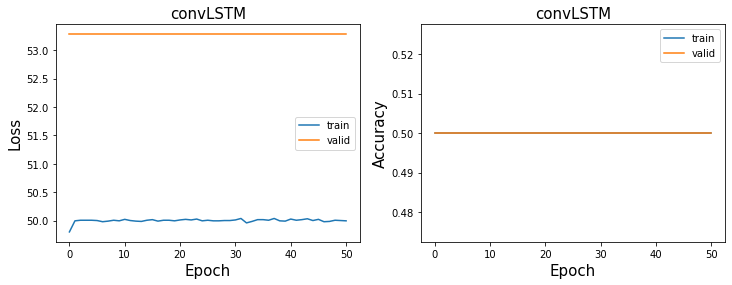

convLSTM(
  (convLSTM): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(118, 224, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (dropout): Dropout2d(p=0.5, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=56000, out_features=1, bias=True)
)
0
Train loss for epoch 0: 4.631150245666504
Val loss for epoch 0: 34.81312561035156
1
Train loss for epoch 1: 3.3600759506225586
Val loss for epoch 1: 31.19337272644043
Train loss for epoch 2: 3.5350096225738525
Val loss for epoch 2: 42.461151123046875
Train loss for epoch 3: 3.4711341857910156
Val loss for epoch 3: 42.244224548339844
Train loss for epoch 4: 3.4614672660827637
Val loss for epoch 4: 44.18571853637695
Train loss for epoch 5: 3.888427734375
Val loss for epoch 5: 46.65713882446289
Train loss for epoch 6: 3.76135516166687
Val loss for epoch 6: 46.16988754272461
Train loss for epoch 7: 3.823989152908325
Val loss for epoch 7: 38.69630813598633
Train loss for epoch 8: 4.08157300

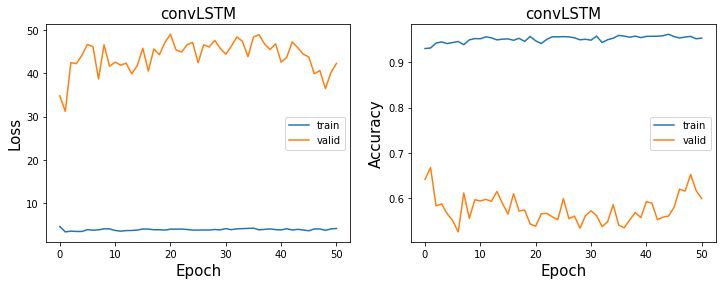

In [27]:
for i in hidden_dim:
    for d in dropout:
        model = convLSTM(input_dim = 62, hidden_dim = i, dropout = d).to(device)
        print(model)
        optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
        criterion = nn.BCELoss() # BCE loss
        train_losses, train_accs, val_losses, val_accs, parameter_history = [], [], [], [],[]

        for epoch in range(num_epochs):
            train_loss, train_acc, parameter_history = train(model, optimizer, criterion, train_loader,  device='cuda')
            val_loss, val_acc = evaluate(model, optimizer, criterion, val_loader, device='cuda')
            train_losses.append(train_loss)
            train_accs.append(train_acc)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            if epoch == 0:
                torch.save(model.state_dict(), '{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_TLEN{}_DO{}_HD{}_EPOCH{}_balanced.pt'.format(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow,T_length, d, i,epoch))
            if val_loss <= min(val_losses):
                best_epoch = epoch
                print(epoch)
                print('Train loss for epoch {}: {}'.format(epoch, train_loss))
                print('Val loss for epoch {}: {}'.format(epoch, val_loss))
                torch.save(model.state_dict(), '{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_TLEN{}_DO{}_HD{}_EPOCH{}_balanced.pt'.format(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow,T_length,d, i,epoch))
        #     elif verbose:
            else:
                print('Train loss for epoch {}: {}'.format(epoch, train_loss))
                print('Val loss for epoch {}: {}'.format(epoch, val_loss))

        #     if epoch == num_epochs-1:
        #         torch.save(model.state_dict(), '{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_EPOCH{}.pt'.format(model_saving_path, model_type, CH, loss_type, reg_type, alpha, timewindow, epoch))
        train_result_filename =  '{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_TLEN{}_DO{}_HD{}_EPOCH{}_balanced_trainresult.pt'.format(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow,T_length, d, i,epoch)
        train_result = {'model_type': model_type, 'train_losses' : train_losses, 'val_losses' : val_losses, 'train_accs': train_accs, 'val_accs': val_accs}
        pickle.dump( train_result, open( train_result_filename, "wb" ) )
        plot_loss_acc(train_losses, val_losses, train_accs, val_accs, model_type)

### Balanced Result

In [27]:
results = []
for h in hidden_dim:
    for d in dropout:
        model_convLSTM = os.listdir(model_saving_path)

        best_result = 0
        reg_alpha = 'REG'+reg_type+str(alpha)+'_'
        dropout_type = 'DO'+str(d)
        hidden_type = 'HD'+str(h)
        t_len = 'TLEN'+str(T_length)
        for i, s in enumerate(model_convLSTM):
            if 'convLSTM_CHall_' in s and reg_alpha in s and dropout_type in s and 'trainresult' not in s and hidden_type in s and t_len in s and 'valcm' not in s and 'testcm' not in s and 'balanced' in s:
                model_name = model_convLSTM[i].split('_')
                epoch_name = [ind for ind,item in enumerate(np.array(model_name)) if "EPOCH" in item]
                res = [int(i) for i in model_name[epoch_name[0]] if i.isdigit()]
                if len(res) > 1:
                    epoch_result = res[0]*10+res[1]
                else:
                    epoch_result = res[0]
                if epoch_result>best_result and epoch_result != 50:
                    best_result = epoch_result

        results.append([h,d,best_result])

results = pd.DataFrame(np.array(results), columns=['hidden','dropout', 'epoch'])
best_results = results.groupby(['hidden','dropout']).max('epoch')
print(best_results)


                epoch
hidden dropout       
10.0   0.1        0.0
       0.3        0.0
       0.5        0.0
15.0   0.1        0.0
       0.3        1.0
       0.5        1.0
48.0   0.1        0.0
       0.3       10.0
       0.5        0.0
56.0   0.1        3.0
       0.3       49.0
       0.5        1.0


In [31]:
def plot_train_result_file(model_saving_path, model_type, num_channel, loss_type, reg_type, alpha, timewindow, T_length, dropout, hidden, best_epoch):
    fb = '{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_TLEN{}_DO{}_HD{}_EPOCH50_balanced_trainresult.pt'.format(model_saving_path, model_type, num_channel, loss_type, reg_type, alpha, timewindow, T_length, dropout, hidden)
    file = open(fb,'rb')
    train_result = pickle.load(file)
    train_losses = train_result['train_losses']
    val_losses = train_result['val_losses']
    train_accs = train_result['train_accs']
    val_accs = train_result['val_accs']
    model_type = train_result['model_type']
    print('best epoch training accuracy: ', train_accs[best_epoch])
    plot_loss_acc(train_losses, val_losses, train_accs, val_accs, model_type)
    

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN5_DO0.1_HD10_EPOCH0_balanced.pt
best epoch training accuracy:  0.9573793987855015


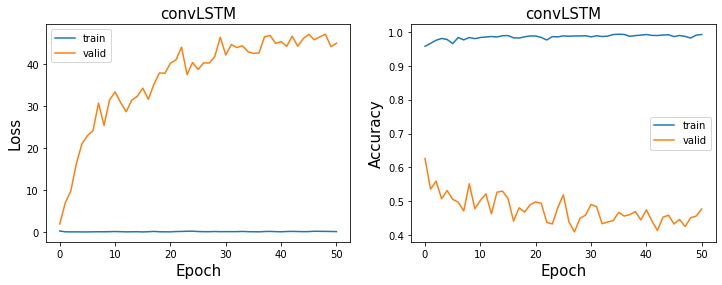

<ipython-input-14-894d578093d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = torch.tensor(outputs).to(device)


validation loss:1.951205849647522 accuracy:0.6120401337792643
test loss:0.6759865880012512 accuracy:0.8490216271884655
0.8403708
/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN5_DO0.1_HD10_balanced_valcm.pt


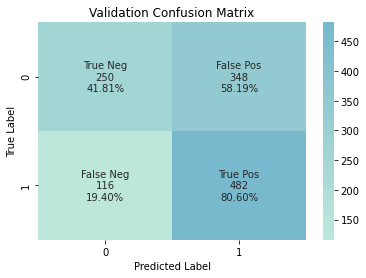

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN5_DO0.1_HD10_balanced_testcm.pt


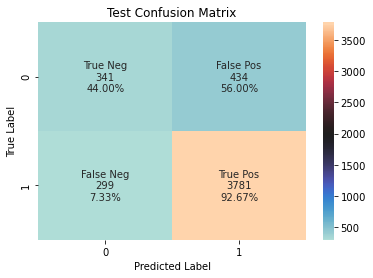

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN5_DO0.3_HD10_EPOCH0_balanced.pt
best epoch training accuracy:  0.9324859502885376


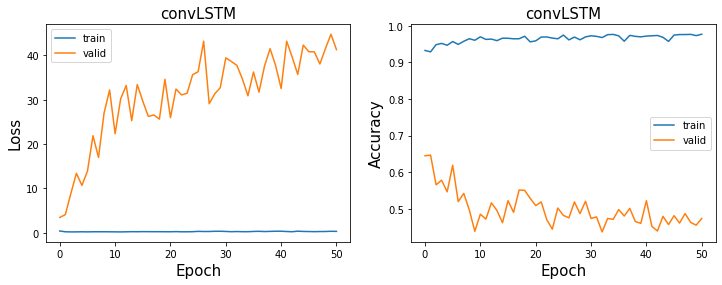

validation loss:3.3605058193206787 accuracy:0.6379598662207357
test loss:0.7044625878334045 accuracy:0.846961894953656
0.8403708
/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN5_DO0.3_HD10_balanced_valcm.pt


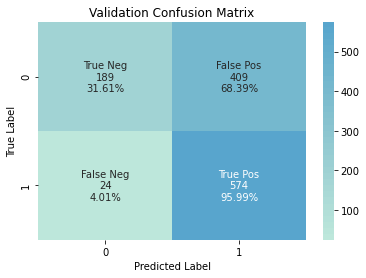

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN5_DO0.3_HD10_balanced_testcm.pt


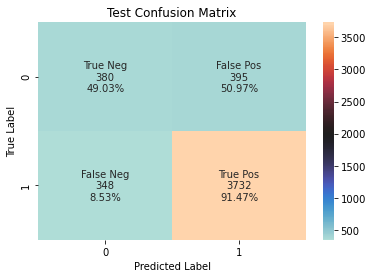

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN5_DO0.5_HD10_EPOCH0_balanced.pt
best epoch training accuracy:  0.9084222834081394


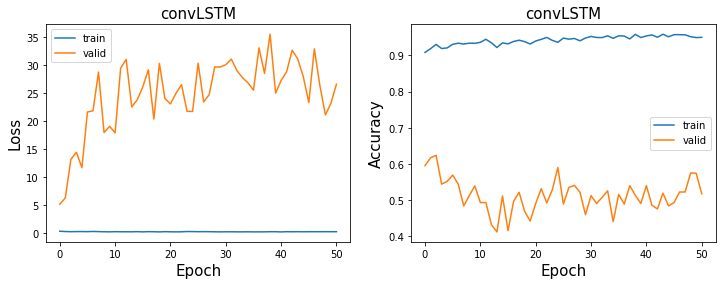

validation loss:4.934798240661621 accuracy:0.5903010033444817
test loss:0.5334764122962952 accuracy:0.8865087538619979
0.8403708
/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN5_DO0.5_HD10_balanced_valcm.pt


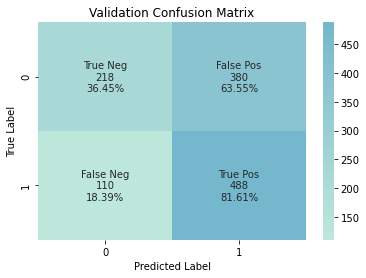

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN5_DO0.5_HD10_balanced_testcm.pt


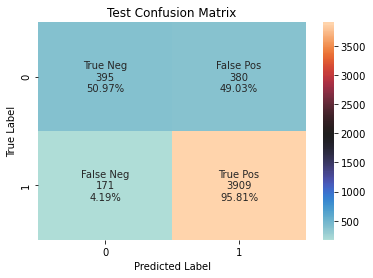

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN5_DO0.1_HD15_EPOCH0_balanced.pt
best epoch training accuracy:  0.9572473880737751


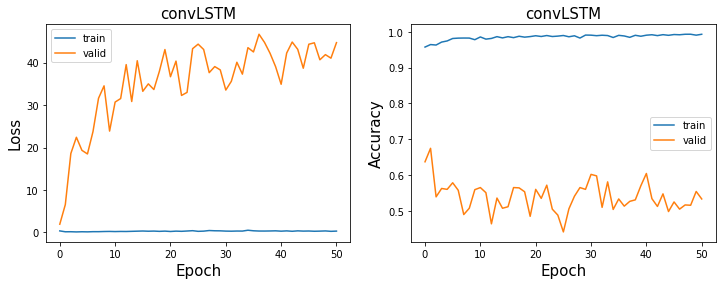

validation loss:1.9287903308868408 accuracy:0.6463210702341137
test loss:0.6355839967727661 accuracy:0.8164778578784758
0.8403708
/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN5_DO0.1_HD15_balanced_valcm.pt


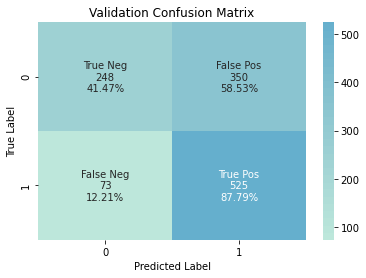

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN5_DO0.1_HD15_balanced_testcm.pt


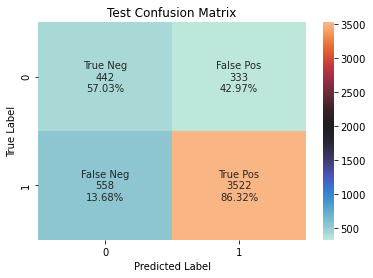

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN5_DO0.3_HD15_EPOCH1_balanced.pt
best epoch training accuracy:  0.9257534039904952


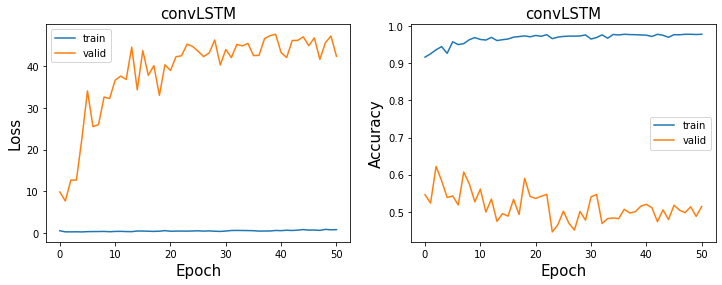

validation loss:7.793582916259766 accuracy:0.5334448160535117
test loss:2.4999680519104004 accuracy:0.7787847579814624
0.8403708
/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN5_DO0.3_HD15_balanced_valcm.pt


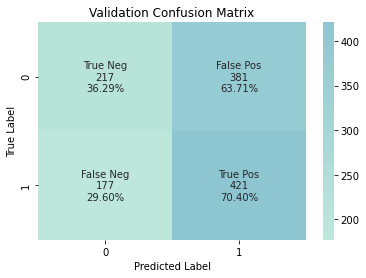

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN5_DO0.3_HD15_balanced_testcm.pt


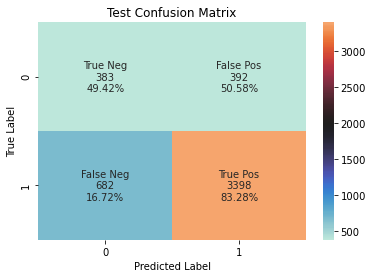

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN5_DO0.5_HD15_EPOCH1_balanced.pt
best epoch training accuracy:  0.9259419907215328


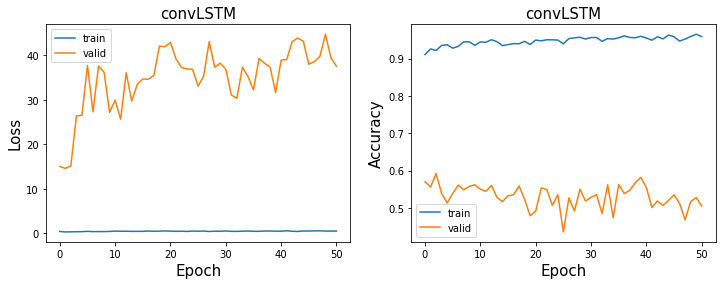

validation loss:14.130325317382812 accuracy:0.5618729096989966
test loss:2.200038433074951 accuracy:0.8640576725025747
0.8403708
/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN5_DO0.5_HD15_balanced_valcm.pt


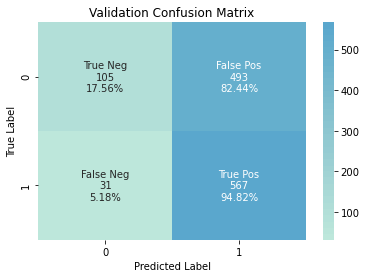

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN5_DO0.5_HD15_balanced_testcm.pt


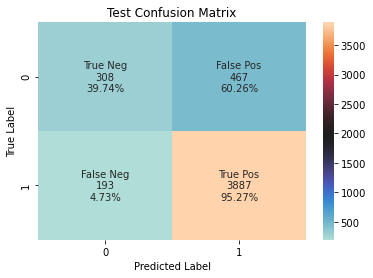

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN5_DO0.1_HD48_EPOCH0_balanced.pt
best epoch training accuracy:  0.9307132350167843


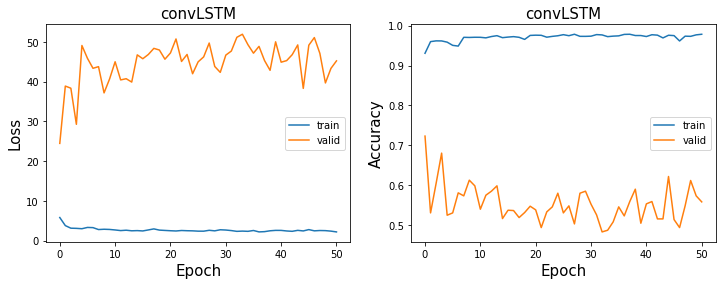

validation loss:24.41875648498535 accuracy:0.7198996655518395
test loss:6.258374214172363 accuracy:0.9005149330587023
0.8403708
/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN5_DO0.1_HD48_balanced_valcm.pt


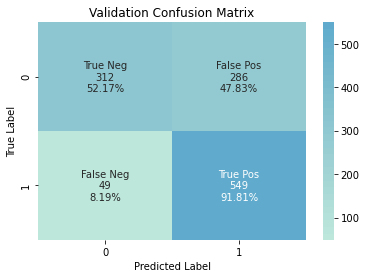

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN5_DO0.1_HD48_balanced_testcm.pt


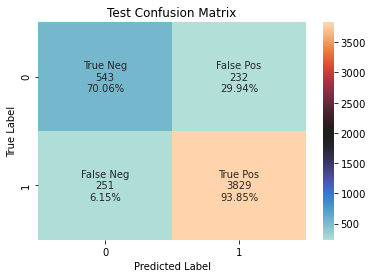

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN5_DO0.3_HD48_EPOCH10_balanced.pt
best epoch training accuracy:  0.9570965186889451


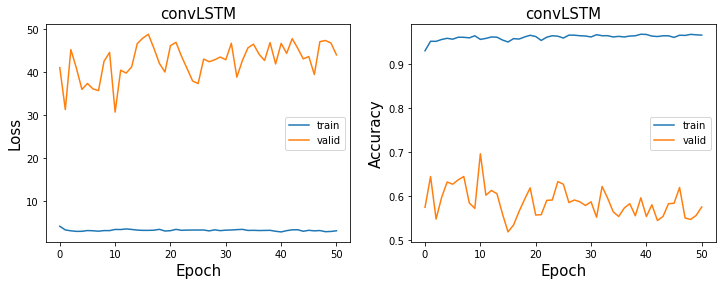

validation loss:30.728673934936523 accuracy:0.6964882943143813
test loss:8.422175407409668 accuracy:0.9050463439752832
0.8403708
/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN5_DO0.3_HD48_balanced_valcm.pt


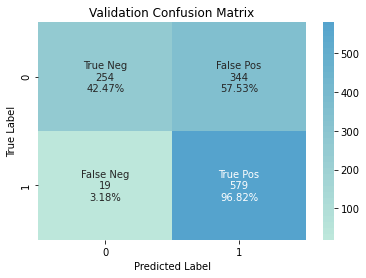

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN5_DO0.3_HD48_balanced_testcm.pt


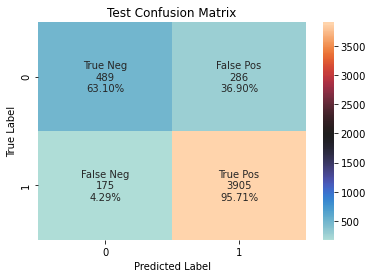

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN5_DO0.5_HD48_EPOCH0_balanced.pt
best epoch training accuracy:  0.9164560781503414


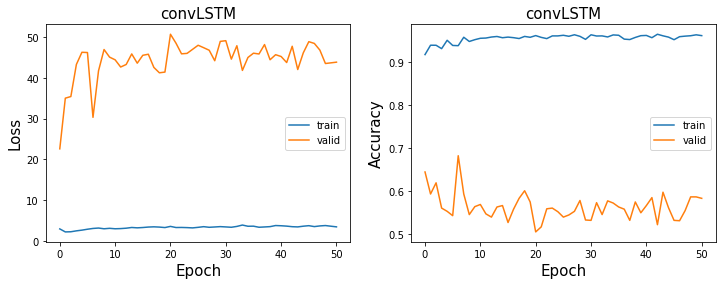

validation loss:22.765701293945312 accuracy:0.6396321070234113
test loss:5.455766201019287 accuracy:0.894335736354274
0.8403708
/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN5_DO0.5_HD48_balanced_valcm.pt


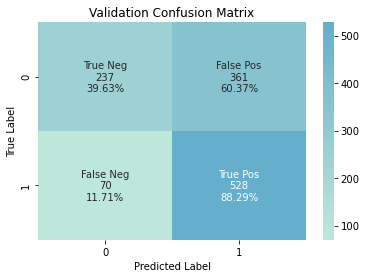

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN5_DO0.5_HD48_balanced_testcm.pt


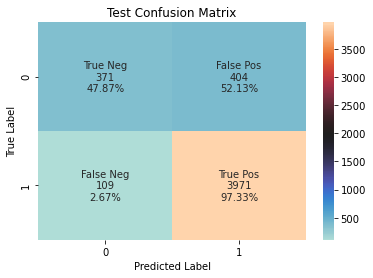

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN5_DO0.1_HD56_EPOCH3_balanced.pt
best epoch training accuracy:  0.9613585788103949


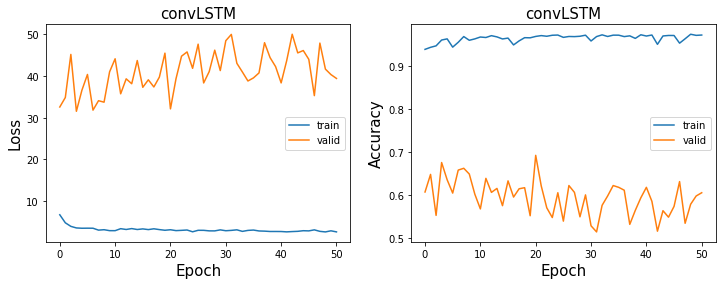

validation loss:31.213254928588867 accuracy:0.6755852842809364
test loss:10.28292465209961 accuracy:0.8780638516992791
0.8403708
/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN5_DO0.1_HD56_balanced_valcm.pt


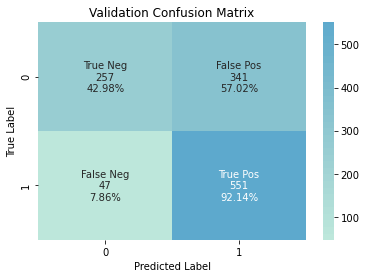

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN5_DO0.1_HD56_balanced_testcm.pt


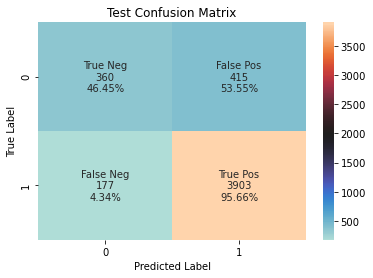

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN5_DO0.3_HD56_EPOCH49_balanced.pt
best epoch training accuracy:  0.5


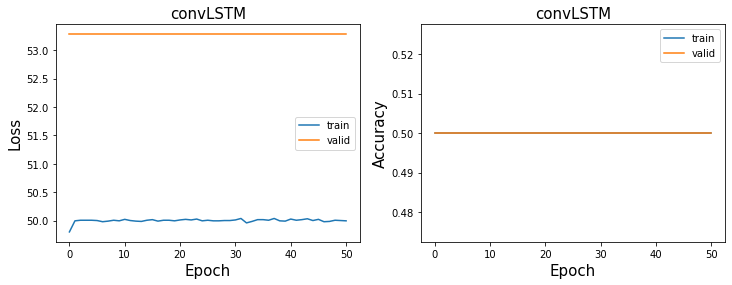

validation loss:53.28125 accuracy:0.5
test loss:15.953601837158203 accuracy:0.8403707518022657
0.8403708
/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN5_DO0.3_HD56_balanced_valcm.pt


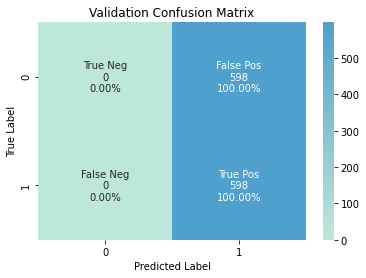

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN5_DO0.3_HD56_balanced_testcm.pt


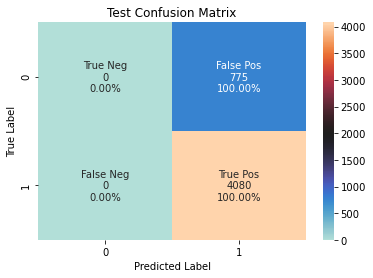

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN5_DO0.5_HD56_EPOCH1_balanced.pt
best epoch training accuracy:  0.9316561686719722


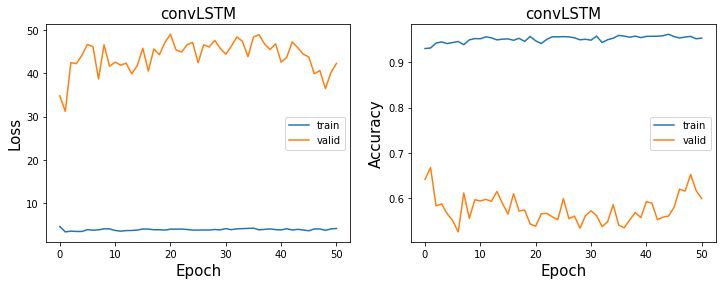

validation loss:31.225133895874023 accuracy:0.6688963210702341
test loss:7.19315767288208 accuracy:0.9085478887744594
0.8403708
/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN5_DO0.5_HD56_balanced_valcm.pt


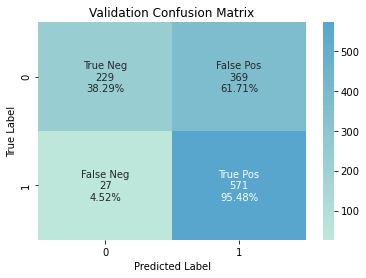

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN5_DO0.5_HD56_balanced_testcm.pt


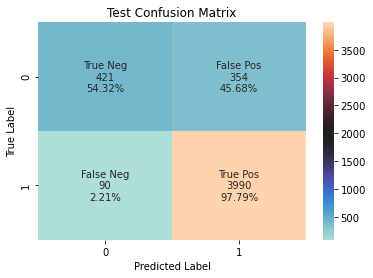

In [32]:
for i,(index,row) in enumerate(best_results.iterrows()):

    best_epoch = int(row)
    hidden = int(index[0])
    dropout = index[1]
    alpha = 0
    
    
    # load best model
    model = convLSTM(input_dim = 62, hidden_dim = hidden).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    model.load_state_dict(torch.load('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_TLEN{}_DO{}_HD{}_EPOCH{}_balanced.pt'.format(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow, T_length, dropout, hidden,best_epoch)))
    
    print('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_TLEN{}_DO{}_HD{}_EPOCH{}_balanced.pt'.format(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow,T_length, dropout, hidden,best_epoch))

    ## Print training result
    plot_train_result_file(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow, T_length, dropout, hidden, best_epoch)
    
    ## Calculate validation accuracy and validation loss
    val_loss, val_acc, val_preds, val_labels = evaluate(model, optimizer, criterion, val_loader, device='cuda', collect_result = True)
    print('validation loss:{} accuracy:{}'.format(val_loss, val_acc))
    
    ## Calculate test accuracy and test loss
    test_loss, test_acc, test_preds, test_labels = evaluate(model, optimizer, criterion, test_loader, device='cuda', collect_result = True)
    print('test loss:{} accuracy:{}'.format(test_loss, test_acc))
    print(np.mean(np.concatenate(test_labels)))
    
    ## Confusion matrix-validation
    predictions_val = np.concatenate(val_preds)
    labels_val = np.concatenate(val_labels)
    
    val_cm_filename = '{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_TLEN{}_DO{}_HD{}_balanced_valcm.pt'.format(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow, T_length, dropout,hidden)
    print(val_cm_filename)
    val_cm_result = {'predictions_val': predictions_val, 'labels_val' : labels_val}

    pickle.dump( val_cm_result, open( val_cm_filename, "wb" ) )
    
    
    df_val = pd.DataFrame({'predictions': predictions_val, 'labels': labels_val})

    cm_val = confusion_matrix(labels_val, predictions_val)
    ax = plt.axes()
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cm_val.flatten()]

    TNR = int(group_counts[0]) / (int(group_counts[0])+int(group_counts[1]))
    FPR = 1 - TNR
    TPR = int(group_counts[3]) / (int(group_counts[3])+int(group_counts[2]))
    FNR = 1-TPR
    group_percentages =[TNR, FPR, FNR, TPR]

    group_percentages = ["{0:.2%}".format(value) for value in
                         group_percentages]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sn.heatmap(cm_val, annot=labels, fmt='', center = 2000)
    ax.set_title('Validation Confusion Matrix')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    plt.show()
    
    ## Confusion matrix-test
    predictions_test = np.concatenate(test_preds)
    labels_test = np.concatenate(test_labels)

    test_cm_filename = '{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_TLEN{}_DO{}_HD{}_balanced_testcm.pt'.format(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow, T_length, dropout,hidden)
    print(test_cm_filename)
    test_cm_result = {'predictions_test': predictions_test, 'labels_val' : labels_test}

    pickle.dump( test_cm_result, open( test_cm_filename, "wb" ) )

    df_test = pd.DataFrame({'predictions': predictions_test, 'labels': labels_test})

    cm_test = confusion_matrix(labels_test, predictions_test)
    ax = plt.axes()
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cm_test.flatten()]

    TNR = int(group_counts[0]) / (int(group_counts[0])+int(group_counts[1]))
    FPR = 1 - TNR
    TPR = int(group_counts[3]) / (int(group_counts[3])+int(group_counts[2]))
    FNR = 1-TPR
    group_percentages =[TNR, FPR, FNR, TPR]

    group_percentages = ["{0:.2%}".format(value) for value in
                         group_percentages]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sn.heatmap(cm_test, annot=labels, fmt='', center = 2000)
    ax.set_title('Test Confusion Matrix')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    plt.show()
    


### Unbalanced

In [30]:
results = []
for h in hidden_dim:
    for d in dropout:
        model_convLSTM = os.listdir(model_saving_path)

        best_result = 0
        reg_alpha = 'REG'+reg_type+str(alpha)+'_'
        dropout_type = 'DO'+str(d)
        hidden_type = 'HD'+str(h)
        t_len = 'TLEN'+str(T_length)
        for i, s in enumerate(model_convLSTM):
            if 'convLSTM_CHall_' in s and reg_alpha in s and dropout_type in s and 'trainresult' not in s and hidden_type in s and t_len in s and 'valcm' not in s and 'testcm' not in s and 'balanced' not in s:
                model_name = model_convLSTM[i].split('_')
                epoch_name = [ind for ind,item in enumerate(np.array(model_name)) if "EPOCH" in item]
                res = [int(i) for i in model_name[epoch_name[0]] if i.isdigit()]
                if len(res) > 1:
                    epoch_result = res[0]*10+res[1]
                else:
                    epoch_result = res[0]
                if epoch_result>best_result and epoch_result != 50:
                    best_result = epoch_result

        results.append([h,d,best_result])

results = pd.DataFrame(np.array(results), columns=['hidden','dropout', 'epoch'])
best_results = results.groupby(['hidden','dropout']).max('epoch')
print(best_results)


                epoch
hidden dropout       
10.0   0.1        1.0
       0.3        1.0
       0.5        0.0
15.0   0.1        0.0
       0.3        0.0
       0.5        0.0
48.0   0.1       49.0
       0.3        0.0
       0.5        1.0
56.0   0.1       49.0
       0.3        2.0
       0.5        0.0


In [31]:
def plot_train_result_file(model_saving_path, model_type, num_channel, loss_type, reg_type, alpha, timewindow, T_length, dropout, hidden, best_epoch):
    fb = '{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_TLEN{}_DO{}_HD{}_EPOCH50_trainresult.pt'.format(model_saving_path, model_type, num_channel, loss_type, reg_type, alpha, timewindow, T_length, dropout, hidden)
    file = open(fb,'rb')
    train_result = pickle.load(file)
    train_losses = train_result['train_losses']
    val_losses = train_result['val_losses']
    train_accs = train_result['train_accs']
    val_accs = train_result['val_accs']
    model_type = train_result['model_type']
    print('best epoch training accuracy: ', train_accs[best_epoch])
    plot_loss_acc(train_losses, val_losses, train_accs, val_accs, model_type)
    

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN5_DO0.1_HD10_EPOCH1.pt
best epoch training accuracy:  0.9619243390035077


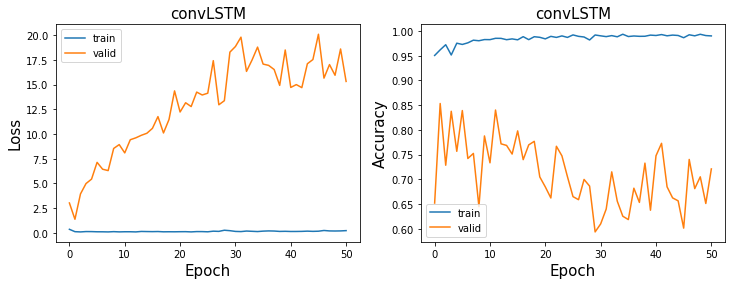

<ipython-input-14-894d578093d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = torch.tensor(outputs).to(device)


validation loss:2.144662618637085 accuracy:0.8666498613561886
test loss:0.7017503380775452 accuracy:0.9002016129032258
0.85534275
/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN5_DO0.1_HD10_valcm.pt


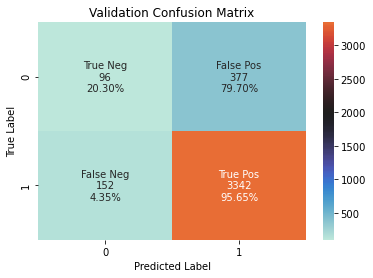

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN5_DO0.1_HD10_testcm.pt


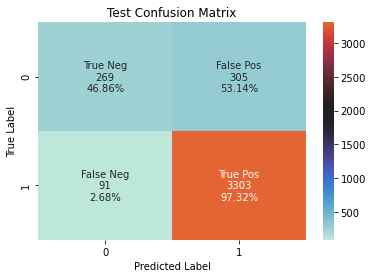

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN5_DO0.3_HD10_EPOCH1.pt
best epoch training accuracy:  0.9336363293478671


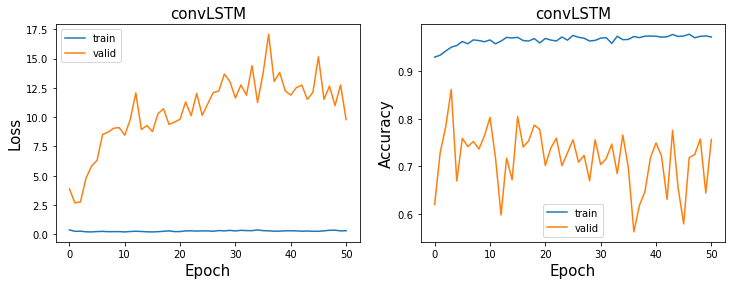

validation loss:2.8135149478912354 accuracy:0.7300226871691454
test loss:1.588270902633667 accuracy:0.8470262096774194
0.85534275
/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN5_DO0.3_HD10_valcm.pt


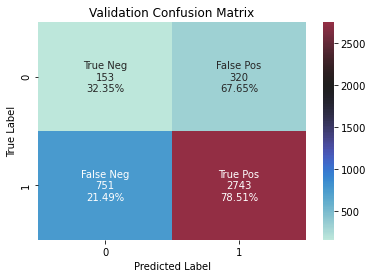

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN5_DO0.3_HD10_testcm.pt


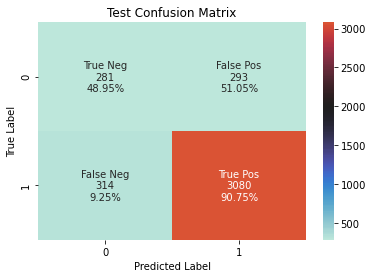

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN5_DO0.5_HD10_EPOCH0.pt
best epoch training accuracy:  0.8978614264700335


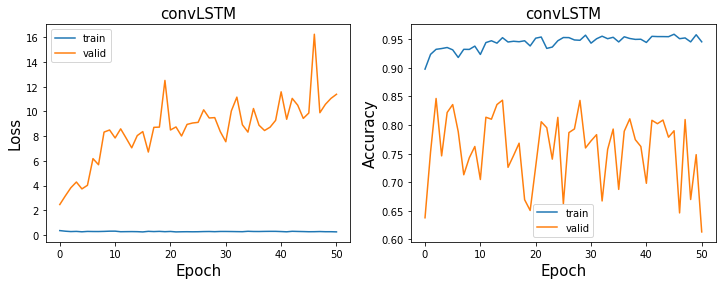

validation loss:2.6606154441833496 accuracy:0.6425510461305772
test loss:1.0592423677444458 accuracy:0.7996471774193549
0.85534275
/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN5_DO0.5_HD10_valcm.pt


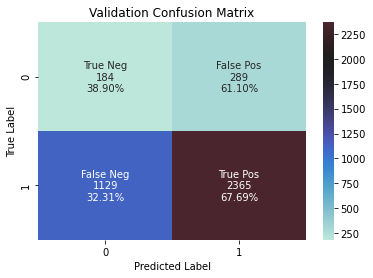

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN5_DO0.5_HD10_testcm.pt


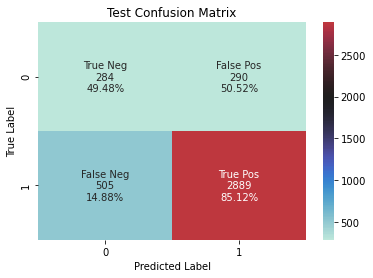

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN5_DO0.1_HD15_EPOCH0.pt
best epoch training accuracy:  0.956078150341342


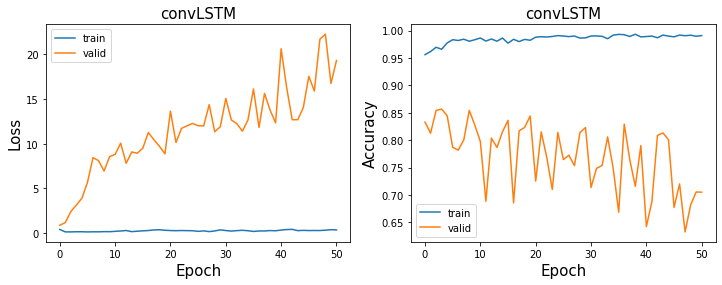

validation loss:1.3298170566558838 accuracy:0.7645576002016637
test loss:1.1699460744857788 accuracy:0.8195564516129032
0.85534275
/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN5_DO0.1_HD15_valcm.pt


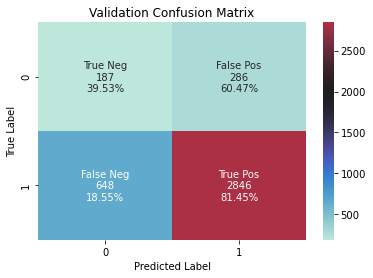

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN5_DO0.1_HD15_testcm.pt


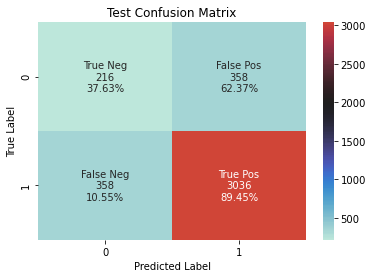

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN5_DO0.3_HD15_EPOCH0.pt
best epoch training accuracy:  0.9048957115377362


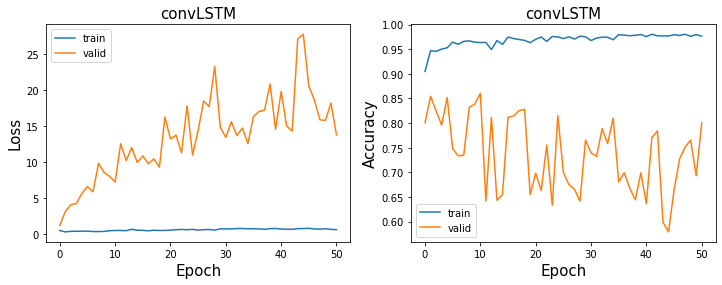

validation loss:1.8007968664169312 accuracy:0.807411141920847
test loss:0.7301053404808044 accuracy:0.8344254032258065
0.85534275
/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN5_DO0.3_HD15_valcm.pt


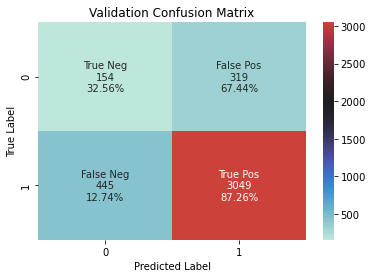

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN5_DO0.3_HD15_testcm.pt


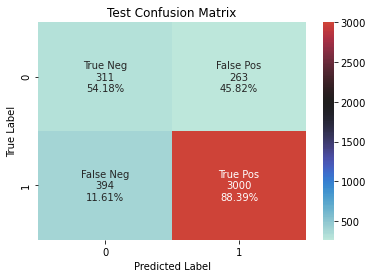

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN5_DO0.5_HD15_EPOCH0.pt
best epoch training accuracy:  0.9090446196205635


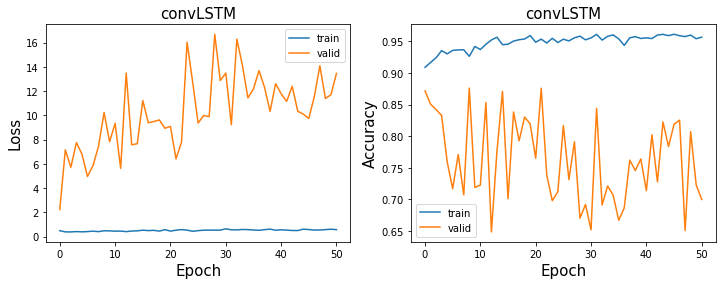

validation loss:2.3842477798461914 accuracy:0.8795059238719435
test loss:1.4288244247436523 accuracy:0.8921370967741935
0.85534275
/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN5_DO0.5_HD15_valcm.pt


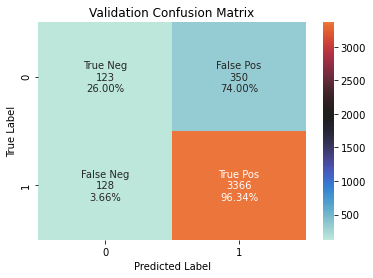

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN5_DO0.5_HD15_testcm.pt


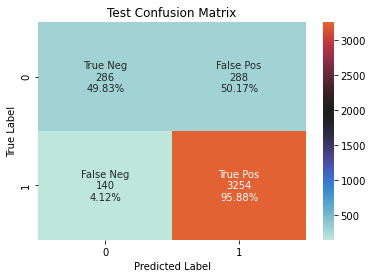

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN5_DO0.1_HD48_EPOCH49.pt
best epoch training accuracy:  0.9431976766114736


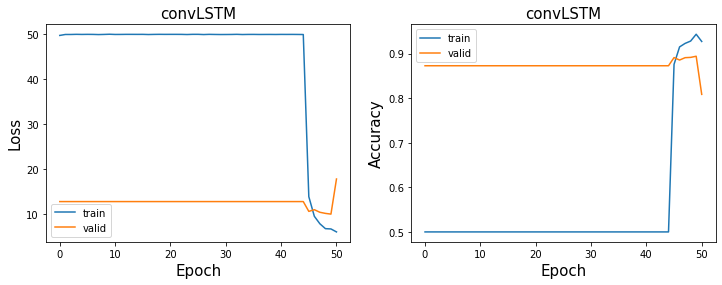

validation loss:9.471813201904297 accuracy:0.8989160574741618
test loss:8.93779182434082 accuracy:0.9057459677419355
0.85534275
/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN5_DO0.1_HD48_valcm.pt


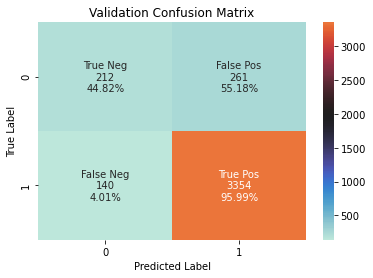

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN5_DO0.1_HD48_testcm.pt


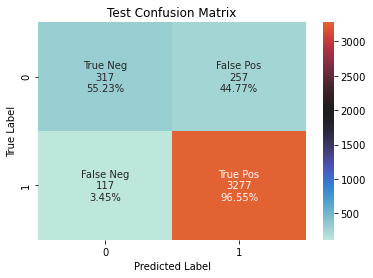

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN5_DO0.3_HD48_EPOCH0.pt
best epoch training accuracy:  0.9324859502885376


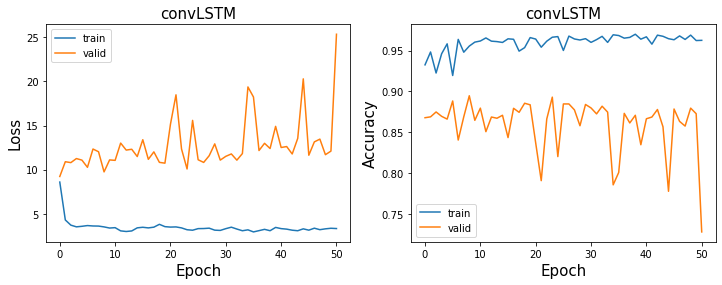

validation loss:9.758973121643066 accuracy:0.8669019410133603
test loss:7.700693130493164 accuracy:0.9002016129032258
0.85534275
/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN5_DO0.3_HD48_valcm.pt


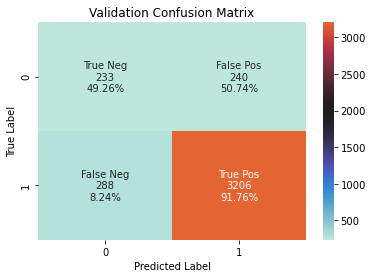

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN5_DO0.3_HD48_testcm.pt


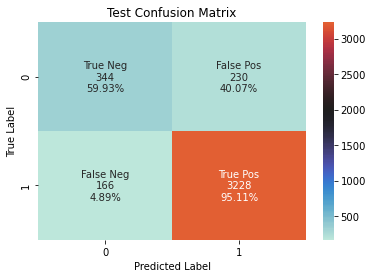

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN5_DO0.5_HD48_EPOCH1.pt
best epoch training accuracy:  0.9400859955493531


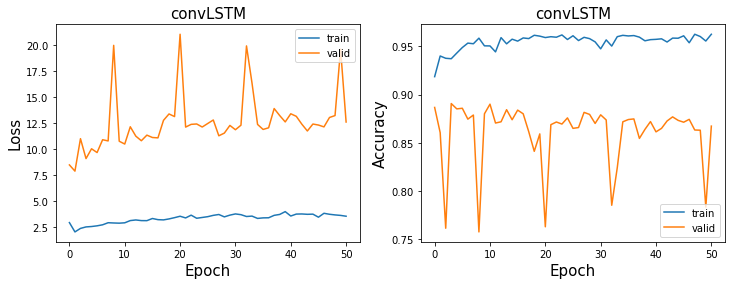

validation loss:7.765535831451416 accuracy:0.8749684900428536
test loss:5.780747413635254 accuracy:0.913054435483871
0.85534275
/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN5_DO0.5_HD48_valcm.pt


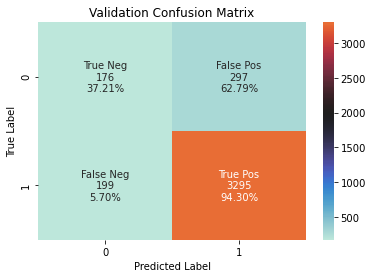

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN5_DO0.5_HD48_testcm.pt


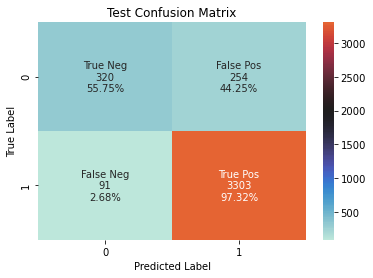

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN5_DO0.1_HD56_EPOCH49.pt
best epoch training accuracy:  0.5


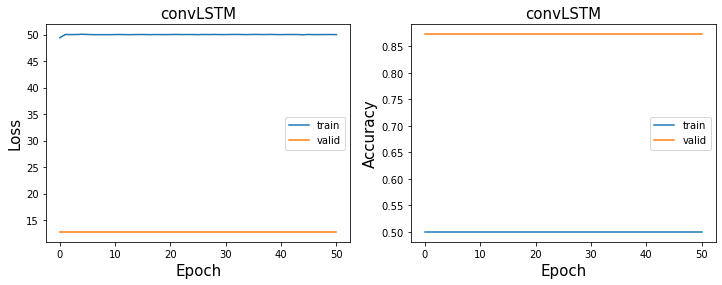

validation loss:11.92333984375 accuracy:0.8807663221578018
test loss:14.46572494506836 accuracy:0.8553427419354839
0.85534275
/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN5_DO0.1_HD56_valcm.pt


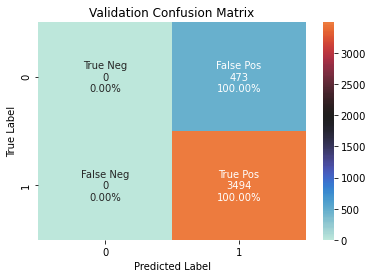

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN5_DO0.1_HD56_testcm.pt


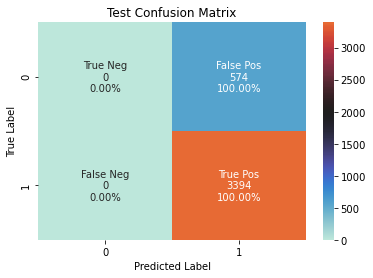

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN5_DO0.3_HD56_EPOCH2.pt
best epoch training accuracy:  0.9446497944404632


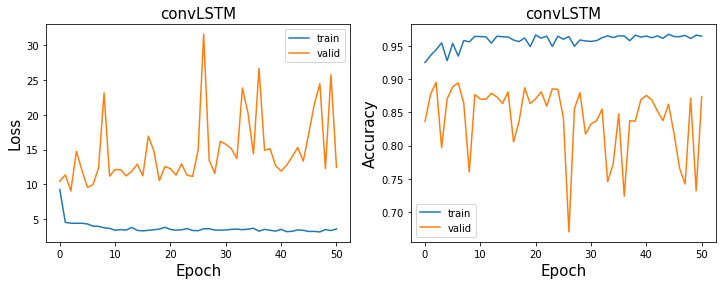

validation loss:8.486519813537598 accuracy:0.9039576506175951
test loss:10.858368873596191 accuracy:0.8777721774193549
0.85534275
/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN5_DO0.3_HD56_valcm.pt


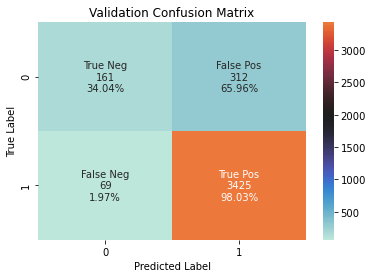

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN5_DO0.3_HD56_testcm.pt


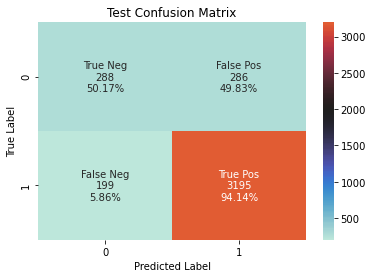

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN5_DO0.5_HD56_EPOCH0.pt
best epoch training accuracy:  0.926564326933957


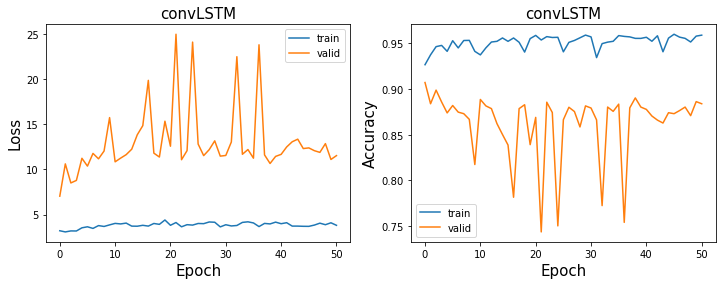

validation loss:6.87087345123291 accuracy:0.9112679606755735
test loss:8.66140079498291 accuracy:0.8780241935483871
0.85534275
/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN5_DO0.5_HD56_valcm.pt


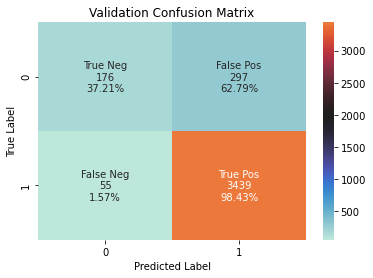

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN5_DO0.5_HD56_testcm.pt


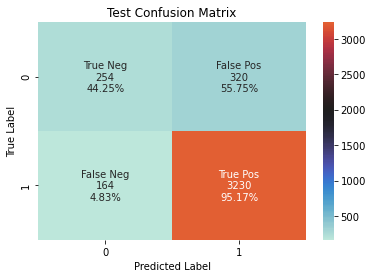

In [32]:
for i,(index,row) in enumerate(best_results.iterrows()):

    best_epoch = int(row)
    hidden = int(index[0])
    dropout = index[1]
    alpha = 0
    
    
    # load best model
    model = convLSTM(input_dim = 62, hidden_dim = hidden).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    model.load_state_dict(torch.load('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_TLEN{}_DO{}_HD{}_EPOCH{}.pt'.format(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow, T_length, dropout, hidden,best_epoch)))
    
    print('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_TLEN{}_DO{}_HD{}_EPOCH{}.pt'.format(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow,T_length, dropout, hidden,best_epoch))

    ## Print training result
    plot_train_result_file(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow, T_length, dropout, hidden, best_epoch)
    
    ## Calculate validation accuracy and validation loss
    val_loss, val_acc, val_preds, val_labels = evaluate(model, optimizer, criterion, val_loader, device='cuda', collect_result = True)
    print('validation loss:{} accuracy:{}'.format(val_loss, val_acc))
    
    ## Calculate test accuracy and test loss
    test_loss, test_acc, test_preds, test_labels = evaluate(model, optimizer, criterion, test_loader, device='cuda', collect_result = True)
    print('test loss:{} accuracy:{}'.format(test_loss, test_acc))
    print(np.mean(np.concatenate(test_labels)))
    
    ## Confusion matrix-validation
    predictions_val = np.concatenate(val_preds)
    labels_val = np.concatenate(val_labels)
    
    val_cm_filename = '{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_TLEN{}_DO{}_HD{}_valcm.pt'.format(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow, T_length, dropout,hidden)
    print(val_cm_filename)
    val_cm_result = {'predictions_val': predictions_val, 'labels_val' : labels_val}

    pickle.dump( val_cm_result, open( val_cm_filename, "wb" ) )
    
    
    df_val = pd.DataFrame({'predictions': predictions_val, 'labels': labels_val})

    cm_val = confusion_matrix(labels_val, predictions_val)
    ax = plt.axes()
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cm_val.flatten()]

    TNR = int(group_counts[0]) / (int(group_counts[0])+int(group_counts[1]))
    FPR = 1 - TNR
    TPR = int(group_counts[3]) / (int(group_counts[3])+int(group_counts[2]))
    FNR = 1-TPR
    group_percentages =[TNR, FPR, FNR, TPR]

    group_percentages = ["{0:.2%}".format(value) for value in
                         group_percentages]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sn.heatmap(cm_val, annot=labels, fmt='', center = 2000)
    ax.set_title('Validation Confusion Matrix')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    plt.show()
    
    ## Confusion matrix-test
    predictions_test = np.concatenate(test_preds)
    labels_test = np.concatenate(test_labels)

    test_cm_filename = '{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_TLEN{}_DO{}_HD{}_testcm.pt'.format(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow, T_length, dropout,hidden)
    print(test_cm_filename)
    test_cm_result = {'predictions_test': predictions_test, 'labels_val' : labels_test}

    pickle.dump( test_cm_result, open( test_cm_filename, "wb" ) )

    df_test = pd.DataFrame({'predictions': predictions_test, 'labels': labels_test})

    cm_test = confusion_matrix(labels_test, predictions_test)
    ax = plt.axes()
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cm_test.flatten()]

    TNR = int(group_counts[0]) / (int(group_counts[0])+int(group_counts[1]))
    FPR = 1 - TNR
    TPR = int(group_counts[3]) / (int(group_counts[3])+int(group_counts[2]))
    FNR = 1-TPR
    group_percentages =[TNR, FPR, FNR, TPR]

    group_percentages = ["{0:.2%}".format(value) for value in
                         group_percentages]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sn.heatmap(cm_test, annot=labels, fmt='', center = 2000)
    ax.set_title('Test Confusion Matrix')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    plt.show()
    


## T-length = 10

In [33]:
time_window = 10
T_length = 10
## Load files
move_files, sleep_files = create_files_new(load_path, bad_dates, T_length=T_length, proceed=1)
train_files, val_files, test_files = [], [], []

## Put files in val, test, and train
for f in move_files+sleep_files:
    if f:
        if f[0][1][3] in val_dates:
            val_files.extend(f)
        elif f[0][1][3] in test_dates:
            test_files.extend(f)
        else:
            train_files.extend(f)           

In [34]:
## Randomly shuffle inside train, val, and test
random.shuffle(train_files)
random.shuffle(val_files)
random.shuffle(test_files)

In [35]:
## Upsample train
train_files = upsample(train_files)

In [36]:
## Balance val 
sleep_files = []
move_files = []
for t in range(len(val_files)):
    if 'sleep' in val_files[t][0]:
        sleep_files.append(val_files[t])
    if 'move' in val_files[t][0]:
        move_files.append(val_files[t])

sleep_sample = sample(sleep_files, len(move_files))
val_2_files = sleep_sample+move_files

In [37]:
len(train_files), len(val_2_files), len(test_files)

(35340, 576, 2671)

In [38]:
## Load files to dataloader
T_length = 10

# train_dataset = SpectrogramDatasetAtt(files=train_files, load_path=load_path, T_length=T_length, all_label=True)
# valid_dataset = SpectrogramDatasetAtt(files=val_2_files, load_path=load_path, T_length=T_length, all_label=True)
# test_dataset = SpectrogramDatasetAtt(files=test_files, load_path=load_path, T_length=T_length, all_label=True)

train_dataset = SpectrogramDatasetAtt(files=train_files, load_path=load_path, T_length=T_length, all_label=True)
valid_dataset = SpectrogramDatasetAtt(files=val_files, load_path=load_path, T_length=T_length, all_label=True)
test_dataset = SpectrogramDatasetAtt(files=test_files, load_path=load_path, T_length=T_length, all_label=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle = True)
val_loader = DataLoader(dataset=valid_dataset, batch_size=128, shuffle = False)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle = False)

### Training

In [39]:
device = torch.device('cuda')

tol = 0.01
learning_rate = 0.01
num_epochs = 51
alpha = 0
model_type = 'convLSTM'
loss_type = 'bce'
reg_type = 'none'
alpha = 0
timewindow = 10
ch = 'all'
# verbose = False

dropout = [0.1,0.3,0.5]
hidden_dim = [10,15,48,56]

convLSTM(
  (convLSTM): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(72, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (dropout): Dropout2d(p=0.1, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=10000, out_features=1, bias=True)
)


<ipython-input-14-894d578093d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = torch.tensor(outputs).to(device)


0
Train loss for epoch 0: 0.35100075602531433
Val loss for epoch 0: 1.8346983194351196
Train loss for epoch 1: 0.1255955845117569
Val loss for epoch 1: 2.7776451110839844
Train loss for epoch 2: 0.09230750054121017
Val loss for epoch 2: 7.112091064453125
Train loss for epoch 3: 0.08789224177598953
Val loss for epoch 3: 6.4505486488342285
Train loss for epoch 4: 0.09064603596925735
Val loss for epoch 4: 7.381974697113037
Train loss for epoch 5: 0.09441330283880234
Val loss for epoch 5: 14.572189331054688
Train loss for epoch 6: 0.11291038990020752
Val loss for epoch 6: 12.931815147399902
Train loss for epoch 7: 0.1493910849094391
Val loss for epoch 7: 18.060138702392578
Train loss for epoch 8: 0.13673126697540283
Val loss for epoch 8: 23.773483276367188
Train loss for epoch 9: 0.11938989162445068
Val loss for epoch 9: 21.71354103088379
Train loss for epoch 10: 0.1246495470404625
Val loss for epoch 10: 22.600194931030273
Train loss for epoch 11: 0.10494451969861984
Val loss for epoch 11:

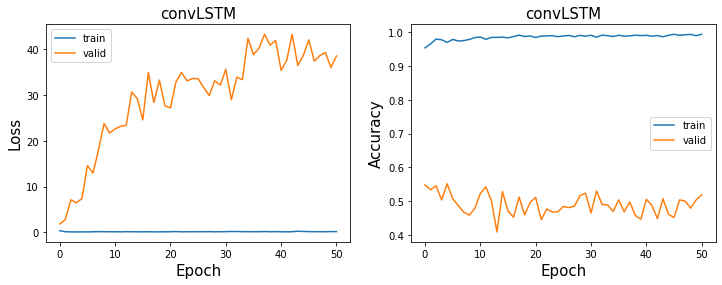

convLSTM(
  (convLSTM): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(72, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (dropout): Dropout2d(p=0.3, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=10000, out_features=1, bias=True)
)
0
Train loss for epoch 0: 0.4067882299423218
Val loss for epoch 0: 3.922663450241089
Train loss for epoch 1: 0.2125898152589798
Val loss for epoch 1: 8.195551872253418
Train loss for epoch 2: 0.21261854469776154
Val loss for epoch 2: 16.375349044799805
Train loss for epoch 3: 0.19875986874103546
Val loss for epoch 3: 7.257615089416504
Train loss for epoch 4: 0.2169787585735321
Val loss for epoch 4: 14.086451530456543
Train loss for epoch 5: 0.21421875059604645
Val loss for epoch 5: 34.307708740234375
Train loss for epoch 6: 0.20376025140285492
Val loss for epoch 6: 21.380945205688477
Train loss for epoch 7: 0.1954016536474228
Val loss for epoch 7: 30.79587173461914
Train loss for epoch 8: 

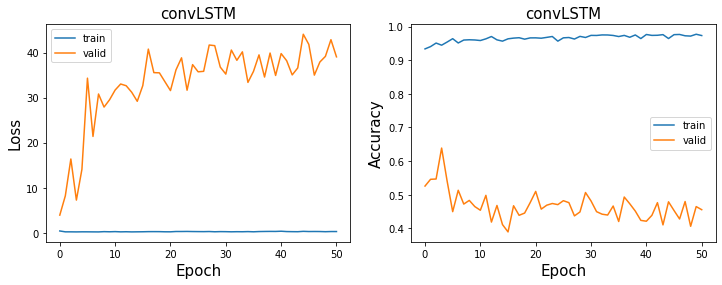

convLSTM(
  (convLSTM): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(72, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (dropout): Dropout2d(p=0.5, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=10000, out_features=1, bias=True)
)
0
Train loss for epoch 0: 0.33526259660720825
Val loss for epoch 0: 2.3265905380249023
Train loss for epoch 1: 0.258110374212265
Val loss for epoch 1: 6.925435543060303
Train loss for epoch 2: 0.2740027606487274
Val loss for epoch 2: 9.833616256713867
Train loss for epoch 3: 0.27604547142982483
Val loss for epoch 3: 13.980175971984863
Train loss for epoch 4: 0.2617240846157074
Val loss for epoch 4: 19.082000732421875
Train loss for epoch 5: 0.2604021728038788
Val loss for epoch 5: 11.103738784790039
Train loss for epoch 6: 0.25067973136901855
Val loss for epoch 6: 19.94820213317871
Train loss for epoch 7: 0.2771785855293274
Val loss for epoch 7: 20.227357864379883
Train loss for epoch 8: 0

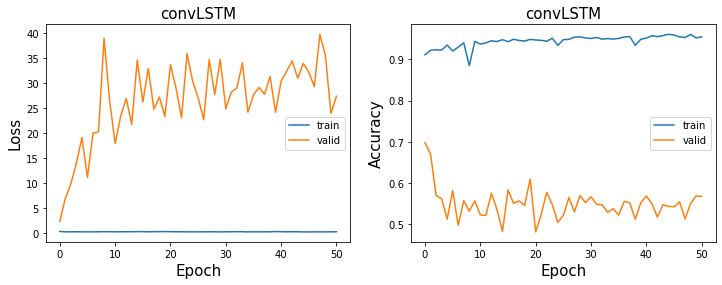

convLSTM(
  (convLSTM): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(77, 60, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (dropout): Dropout2d(p=0.1, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=15000, out_features=1, bias=True)
)
0
Train loss for epoch 0: 1.3682948350906372
Val loss for epoch 0: 4.655404090881348
Train loss for epoch 1: 0.15884704887866974
Val loss for epoch 1: 6.1814422607421875
Train loss for epoch 2: 0.12861955165863037
Val loss for epoch 2: 10.681665420532227
Train loss for epoch 3: 0.143576517701149
Val loss for epoch 3: 11.71524715423584
Train loss for epoch 4: 0.11714484542608261
Val loss for epoch 4: 16.325923919677734
Train loss for epoch 5: 0.17003242671489716
Val loss for epoch 5: 16.3834228515625
Train loss for epoch 6: 0.21578916907310486
Val loss for epoch 6: 26.99423599243164
Train loss for epoch 7: 0.17182551324367523
Val loss for epoch 7: 29.0037784576416
Train loss for epoch 8: 0.

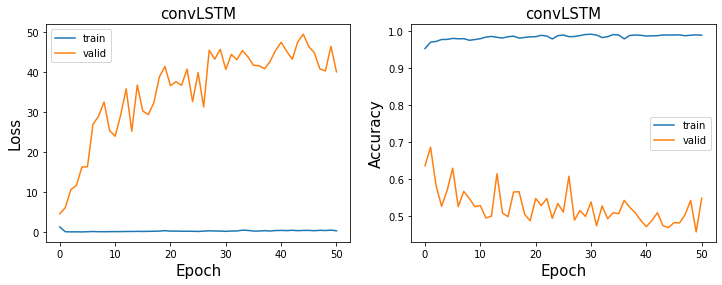

convLSTM(
  (convLSTM): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(77, 60, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (dropout): Dropout2d(p=0.3, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=15000, out_features=1, bias=True)
)
0
Train loss for epoch 0: 0.6497563719749451
Val loss for epoch 0: 6.438766002655029
Train loss for epoch 1: 0.26566508412361145
Val loss for epoch 1: 11.660380363464355
Train loss for epoch 2: 0.28240880370140076
Val loss for epoch 2: 9.905287742614746
Train loss for epoch 3: 0.2950306832790375
Val loss for epoch 3: 30.003446578979492
Train loss for epoch 4: 0.27074772119522095
Val loss for epoch 4: 22.822265625
Train loss for epoch 5: 0.3100369870662689
Val loss for epoch 5: 19.949146270751953
Train loss for epoch 6: 0.2902829051017761
Val loss for epoch 6: 28.768301010131836
Train loss for epoch 7: 0.3176625370979309
Val loss for epoch 7: 31.327133178710938
Train loss for epoch 8: 0.330

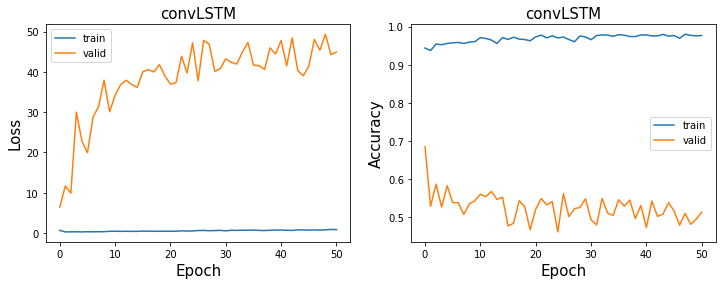

convLSTM(
  (convLSTM): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(77, 60, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (dropout): Dropout2d(p=0.5, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=15000, out_features=1, bias=True)
)
0
Train loss for epoch 0: 0.4796132743358612
Val loss for epoch 0: 7.809934139251709
Train loss for epoch 1: 0.3768702447414398
Val loss for epoch 1: 16.496231079101562
Train loss for epoch 2: 0.35717299580574036
Val loss for epoch 2: 12.054069519042969
Train loss for epoch 3: 0.3893994390964508
Val loss for epoch 3: 28.705520629882812
Train loss for epoch 4: 0.35083669424057007
Val loss for epoch 4: 18.736408233642578
Train loss for epoch 5: 0.3956059217453003
Val loss for epoch 5: 24.596111297607422
Train loss for epoch 6: 0.37624695897102356
Val loss for epoch 6: 23.64533805847168
Train loss for epoch 7: 0.3790712356567383
Val loss for epoch 7: 25.850309371948242
Train loss for epoch 8:

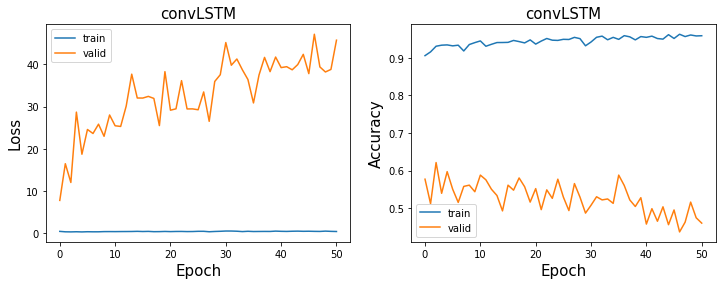

convLSTM(
  (convLSTM): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(110, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (dropout): Dropout2d(p=0.1, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=48000, out_features=1, bias=True)
)
0
Train loss for epoch 0: 6.1752495765686035
Val loss for epoch 0: 23.91542625427246
Train loss for epoch 1: 3.1035168170928955
Val loss for epoch 1: 35.317344665527344
Train loss for epoch 2: 2.9914205074310303
Val loss for epoch 2: 40.65450668334961
Train loss for epoch 3: 3.153276205062866
Val loss for epoch 3: 46.7214241027832
Train loss for epoch 4: 2.8196163177490234
Val loss for epoch 4: 39.51278305053711
Train loss for epoch 5: 3.089062213897705
Val loss for epoch 5: 47.54494857788086
Train loss for epoch 6: 2.6804943084716797
Val loss for epoch 6: 41.84688949584961
Train loss for epoch 7: 2.3977222442626953
Val loss for epoch 7: 35.599910736083984
Train loss for epoch 8: 2.61662

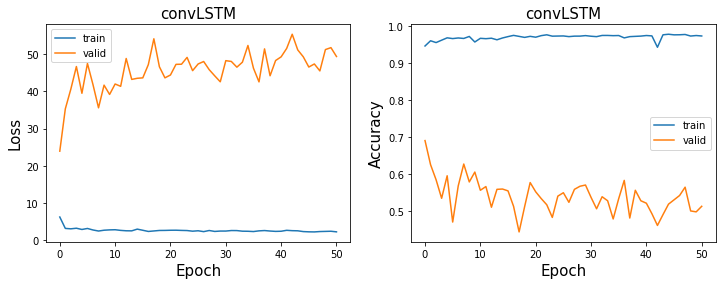

convLSTM(
  (convLSTM): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(110, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (dropout): Dropout2d(p=0.3, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=48000, out_features=1, bias=True)
)
0
Train loss for epoch 0: 5.922841548919678
Val loss for epoch 0: 33.931270599365234
Train loss for epoch 1: 3.3111319541931152
Val loss for epoch 1: 38.591064453125
2
Train loss for epoch 2: 2.9184274673461914
Val loss for epoch 2: 33.16322326660156
Train loss for epoch 3: 2.969953775405884
Val loss for epoch 3: 43.81414794921875
Train loss for epoch 4: 3.322736978530884
Val loss for epoch 4: 41.92112350463867
Train loss for epoch 5: 3.228775978088379
Val loss for epoch 5: 46.31748580932617
Train loss for epoch 6: 3.490555763244629
Val loss for epoch 6: 44.82143783569336
Train loss for epoch 7: 3.151898145675659
Val loss for epoch 7: 43.0635871887207
Train loss for epoch 8: 3.1892769336

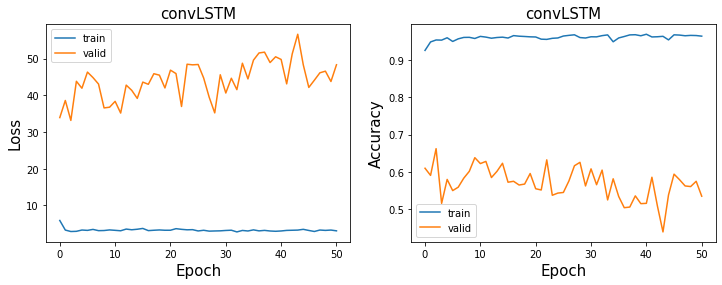

convLSTM(
  (convLSTM): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(110, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (dropout): Dropout2d(p=0.5, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=48000, out_features=1, bias=True)
)
0
Train loss for epoch 0: 2.599668502807617
Val loss for epoch 0: 42.47721862792969
1
Train loss for epoch 1: 2.453435182571411
Val loss for epoch 1: 34.16952133178711
Train loss for epoch 2: 2.4064362049102783
Val loss for epoch 2: 39.038448333740234
Train loss for epoch 3: 2.7800028324127197
Val loss for epoch 3: 44.676753997802734
Train loss for epoch 4: 2.8948655128479004
Val loss for epoch 4: 36.15976333618164
Train loss for epoch 5: 3.066923141479492
Val loss for epoch 5: 43.42631149291992
Train loss for epoch 6: 2.8384721279144287
Val loss for epoch 6: 48.27128219604492
Train loss for epoch 7: 3.0832555294036865
Val loss for epoch 7: 46.5207633972168
Train loss for epoch 8: 3.1705

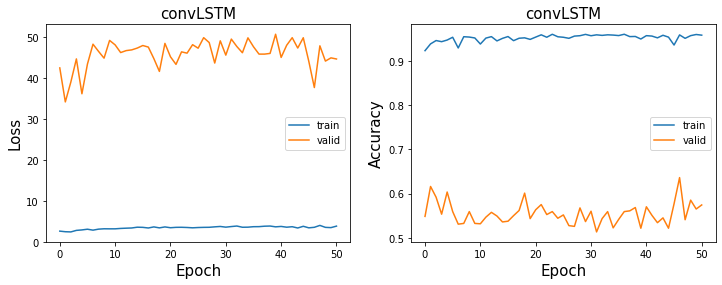

convLSTM(
  (convLSTM): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(118, 224, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (dropout): Dropout2d(p=0.1, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=56000, out_features=1, bias=True)
)
0
Train loss for epoch 0: 9.929845809936523
Val loss for epoch 0: 36.604652404785156
Train loss for epoch 1: 5.278356075286865
Val loss for epoch 1: 40.90302658081055
Train loss for epoch 2: 4.395873546600342
Val loss for epoch 2: 48.99502182006836
Train loss for epoch 3: 4.116871356964111
Val loss for epoch 3: 38.4781608581543
Train loss for epoch 4: 3.8213419914245605
Val loss for epoch 4: 44.11198043823242
Train loss for epoch 5: 3.6493566036224365
Val loss for epoch 5: 47.18793869018555
6
Train loss for epoch 6: 3.674534797668457
Val loss for epoch 6: 35.06930923461914
7
Train loss for epoch 7: 3.5403006076812744
Val loss for epoch 7: 31.37469482421875
Train loss for epoch 8: 3.48157

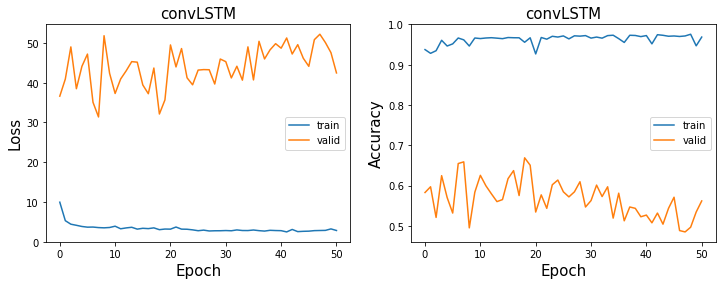

convLSTM(
  (convLSTM): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(118, 224, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (dropout): Dropout2d(p=0.3, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=56000, out_features=1, bias=True)
)
0
Train loss for epoch 0: 11.098238945007324
Val loss for epoch 0: 32.66844940185547
Train loss for epoch 1: 6.4057393074035645
Val loss for epoch 1: 37.74147033691406
Train loss for epoch 2: 5.629413604736328
Val loss for epoch 2: 36.46639633178711
Train loss for epoch 3: 5.23353910446167
Val loss for epoch 3: 40.099693298339844
Train loss for epoch 4: 5.056060314178467
Val loss for epoch 4: 40.119361877441406
Train loss for epoch 5: 4.7450151443481445
Val loss for epoch 5: 35.22715377807617
Train loss for epoch 6: 4.379411220550537
Val loss for epoch 6: 41.0503044128418
Train loss for epoch 7: 4.199746608734131
Val loss for epoch 7: 44.660587310791016
Train loss for epoch 8: 4.08086776

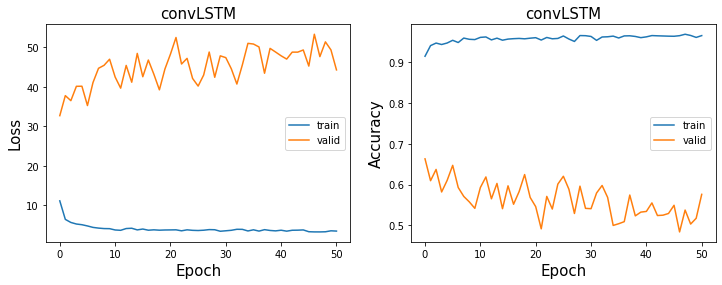

convLSTM(
  (convLSTM): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(118, 224, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (dropout): Dropout2d(p=0.5, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=56000, out_features=1, bias=True)
)
0
Train loss for epoch 0: 5.359662055969238
Val loss for epoch 0: 36.59359359741211
Train loss for epoch 1: 3.712124824523926
Val loss for epoch 1: 40.819847106933594
Train loss for epoch 2: 3.689565896987915
Val loss for epoch 2: 46.56439971923828
Train loss for epoch 3: 3.8108198642730713
Val loss for epoch 3: 44.22053909301758
Train loss for epoch 4: 3.758657932281494
Val loss for epoch 4: 47.26248550415039
Train loss for epoch 5: 3.67720627784729
Val loss for epoch 5: 46.05796432495117
Train loss for epoch 6: 3.7603695392608643
Val loss for epoch 6: 46.92832565307617
Train loss for epoch 7: 3.966198444366455
Val loss for epoch 7: 46.03395080566406
Train loss for epoch 8: 3.8448202610

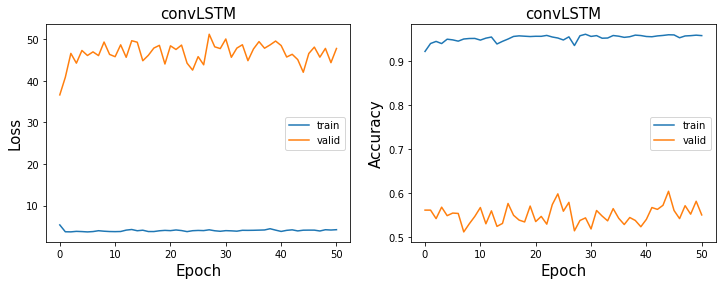

In [37]:
for i in hidden_dim:
    for d in dropout:
        model = convLSTM(input_dim = 62, hidden_dim = i, dropout = d).to(device)
        print(model)
        optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
        criterion = nn.BCELoss() # BCE loss
        train_losses, train_accs, val_losses, val_accs, parameter_history = [], [], [], [],[]

        for epoch in range(num_epochs):
            train_loss, train_acc, parameter_history = train(model, optimizer, criterion, train_loader,  device='cuda')
            val_loss, val_acc = evaluate(model, optimizer, criterion, val_loader, device='cuda')
            train_losses.append(train_loss)
            train_accs.append(train_acc)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            if epoch == 0:
                torch.save(model.state_dict(), '{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_TLEN{}_DO{}_HD{}_EPOCH{}_balanced.pt'.format(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow,T_length, d, i,epoch))
            if val_loss <= min(val_losses):
                best_epoch = epoch
                print(epoch)
                print('Train loss for epoch {}: {}'.format(epoch, train_loss))
                print('Val loss for epoch {}: {}'.format(epoch, val_loss))
                torch.save(model.state_dict(), '{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_TLEN{}_DO{}_HD{}_EPOCH{}_balanced.pt'.format(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow,T_length,d, i,epoch))
        #     elif verbose:
            else:
                print('Train loss for epoch {}: {}'.format(epoch, train_loss))
                print('Val loss for epoch {}: {}'.format(epoch, val_loss))

        #     if epoch == num_epochs-1:
        #         torch.save(model.state_dict(), '{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_EPOCH{}.pt'.format(model_saving_path, model_type, CH, loss_type, reg_type, alpha, timewindow, epoch))
        train_result_filename =  '{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_TLEN{}_DO{}_HD{}_EPOCH{}_balanced_trainresult.pt'.format(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow,T_length, d, i,epoch)
        train_result = {'model_type': model_type, 'train_losses' : train_losses, 'val_losses' : val_losses, 'train_accs': train_accs, 'val_accs': val_accs}
        pickle.dump( train_result, open( train_result_filename, "wb" ) )
        plot_loss_acc(train_losses, val_losses, train_accs, val_accs, model_type)

In [40]:
def plot_train_result_file(model_saving_path, model_type, num_channel, loss_type, reg_type, alpha, timewindow, T_length, dropout, hidden, best_epoch):
    fb = '{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_TLEN{}_DO{}_HD{}_EPOCH50_balanced_trainresult.pt'.format(model_saving_path, model_type, num_channel, loss_type, reg_type, alpha, timewindow, T_length, dropout, hidden)
    file = open(fb,'rb')
    train_result = pickle.load(file)
    train_losses = train_result['train_losses']
    val_losses = train_result['val_losses']
    train_accs = train_result['train_accs']
    val_accs = train_result['val_accs']
    model_type = train_result['model_type']
    print('best epoch training accuracy: ', train_accs[best_epoch])
    plot_loss_acc(train_losses, val_losses, train_accs, val_accs, model_type)
    

### Balanced result

In [41]:
results = []
for h in hidden_dim:
    for d in dropout:
        model_convLSTM = os.listdir(model_saving_path)

        best_result = 0
        reg_alpha = 'REG'+reg_type+str(alpha)+'_'
        dropout_type = 'DO'+str(d)
        hidden_type = 'HD'+str(h)
        t_len = 'TLEN'+str(T_length)
        for i, s in enumerate(model_convLSTM):
            if 'convLSTM_CHall_' in s and reg_alpha in s and dropout_type in s and 'trainresult' not in s and hidden_type in s and t_len in s and 'valcm' not in s and 'testcm' not in s and 'balanced' in s:
                model_name = model_convLSTM[i].split('_')
                epoch_name = [ind for ind,item in enumerate(np.array(model_name)) if "EPOCH" in item]
                res = [int(i) for i in model_name[epoch_name[0]] if i.isdigit()]
                if len(res) > 1:
                    epoch_result = res[0]*10+res[1]
                else:
                    epoch_result = res[0]
                if epoch_result>best_result and epoch_result != 50:
                    best_result = epoch_result

        results.append([h,d,best_result])

results = pd.DataFrame(np.array(results), columns=['hidden','dropout', 'epoch'])
best_results = results.groupby(['hidden','dropout']).max('epoch')
print(best_results)


                epoch
hidden dropout       
10.0   0.1        0.0
       0.3        0.0
       0.5        0.0
15.0   0.1        0.0
       0.3        0.0
       0.5        0.0
48.0   0.1        0.0
       0.3        2.0
       0.5        1.0
56.0   0.1        7.0
       0.3        0.0
       0.5        0.0


/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN10_DO0.1_HD10_EPOCH0_balanced.pt
best epoch training accuracy:  0.9532116320295704


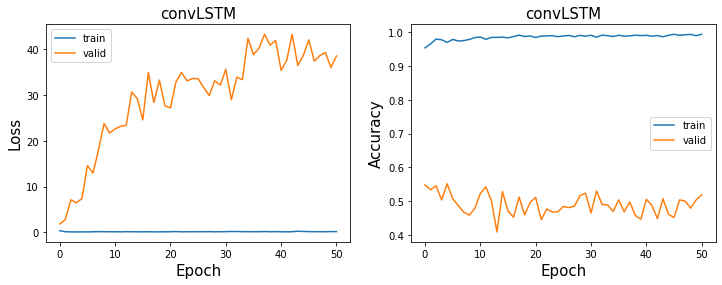

<ipython-input-14-894d578093d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = torch.tensor(outputs).to(device)


validation loss:1.7734984159469604 accuracy:0.5719063545150501
test loss:0.6848081350326538 accuracy:0.8051493305870236
0.8403708
/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN10_DO0.1_HD10_balanced_valcm.pt


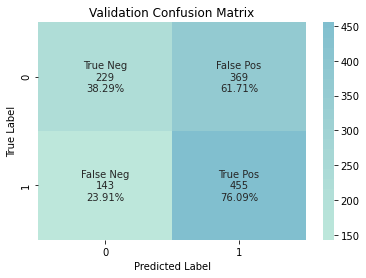

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN10_DO0.1_HD10_balanced_testcm.pt


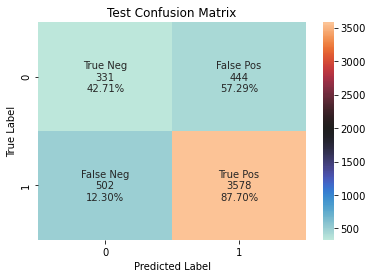

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN10_DO0.3_HD10_EPOCH0_balanced.pt
best epoch training accuracy:  0.933485459963037


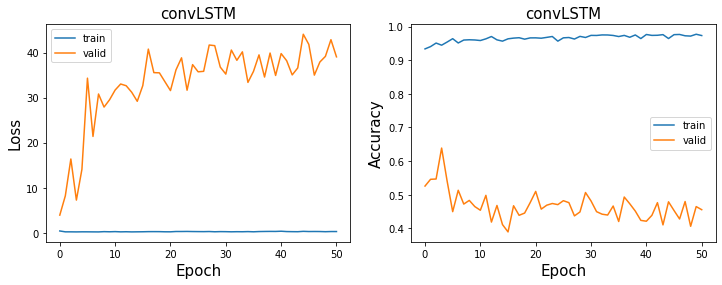

validation loss:3.5463829040527344 accuracy:0.5576923076923077
test loss:1.7596375942230225 accuracy:0.7466529351184346
0.8403708
/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN10_DO0.3_HD10_balanced_valcm.pt


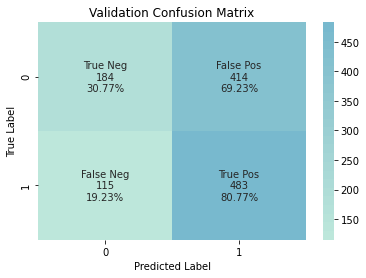

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN10_DO0.3_HD10_balanced_testcm.pt


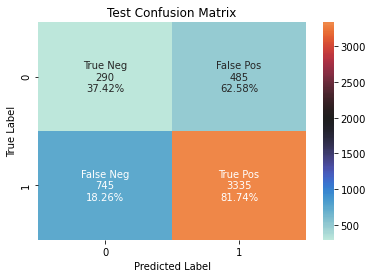

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN10_DO0.5_HD10_EPOCH0_balanced.pt
best epoch training accuracy:  0.9111567910081847


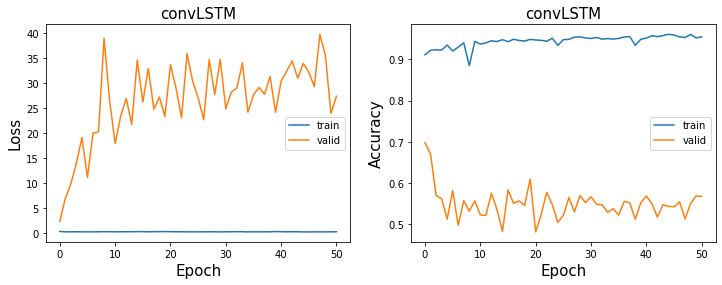

validation loss:2.3490147590637207 accuracy:0.7081939799331104
test loss:0.5579890012741089 accuracy:0.8710607621009269
0.8403708
/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN10_DO0.5_HD10_balanced_valcm.pt


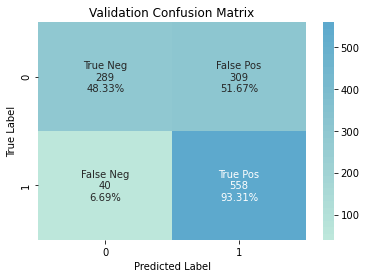

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN10_DO0.5_HD10_balanced_testcm.pt


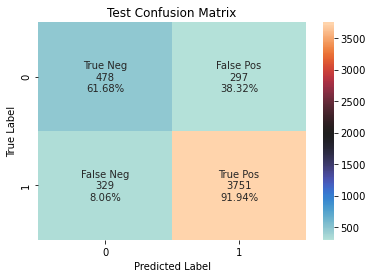

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN10_DO0.1_HD15_EPOCH0_balanced.pt
best epoch training accuracy:  0.9537396748764757


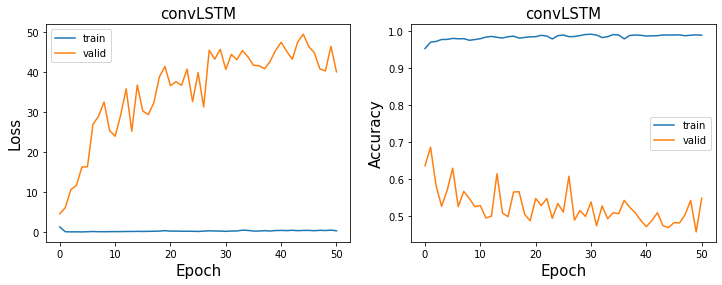

validation loss:4.6096391677856445 accuracy:0.6479933110367893
test loss:0.8072413206100464 accuracy:0.8584963954685891
0.8403708
/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN10_DO0.1_HD15_balanced_valcm.pt


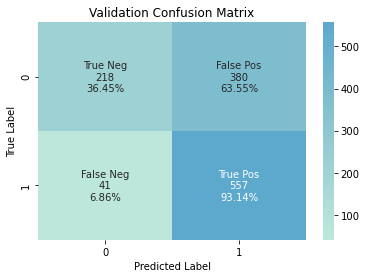

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN10_DO0.1_HD15_balanced_testcm.pt


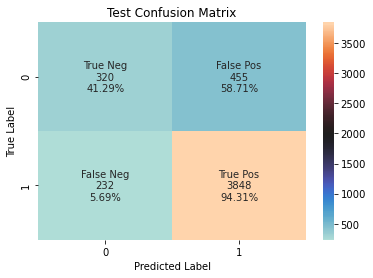

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN10_DO0.3_HD15_EPOCH0_balanced.pt
best epoch training accuracy:  0.9437445781314827


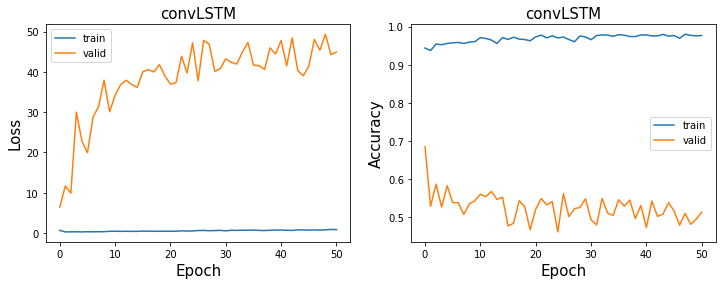

validation loss:6.334296703338623 accuracy:0.6939799331103679
test loss:0.8448807597160339 accuracy:0.8650875386199794
0.8403708
/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN10_DO0.3_HD15_balanced_valcm.pt


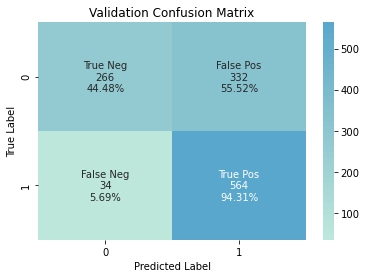

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN10_DO0.3_HD15_balanced_testcm.pt


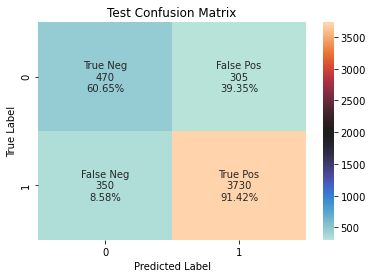

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN10_DO0.5_HD15_EPOCH0_balanced.pt
best epoch training accuracy:  0.9060649492701693


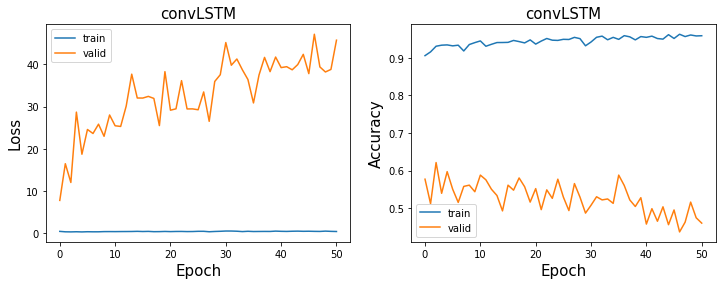

validation loss:7.970376491546631 accuracy:0.5877926421404682
test loss:0.9436586499214172 accuracy:0.8508753861997941
0.8403708
/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN10_DO0.5_HD15_balanced_valcm.pt


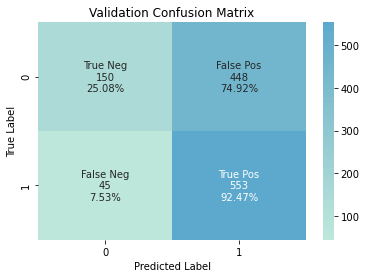

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN10_DO0.5_HD15_balanced_testcm.pt


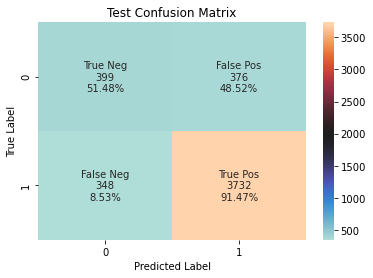

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN10_DO0.1_HD48_EPOCH0_balanced.pt
best epoch training accuracy:  0.9469882699053295


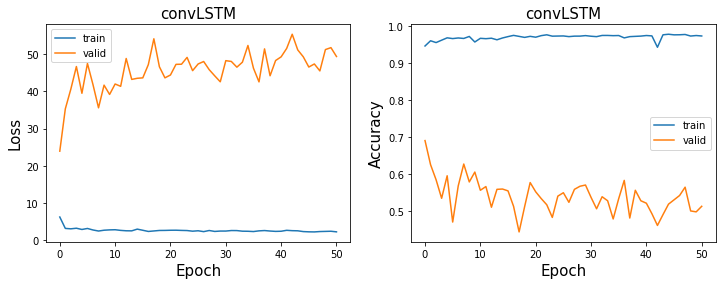

validation loss:21.67937469482422 accuracy:0.7090301003344481
test loss:5.931621551513672 accuracy:0.8953656024716787
0.8403708
/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN10_DO0.1_HD48_balanced_valcm.pt


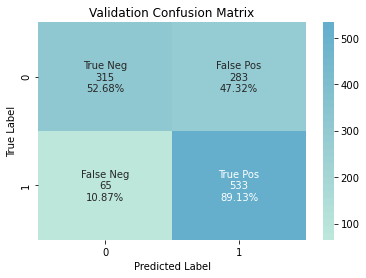

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN10_DO0.1_HD48_balanced_testcm.pt


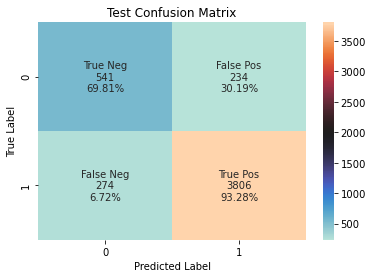

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN10_DO0.3_HD48_EPOCH2_balanced.pt
best epoch training accuracy:  0.9547769018971826


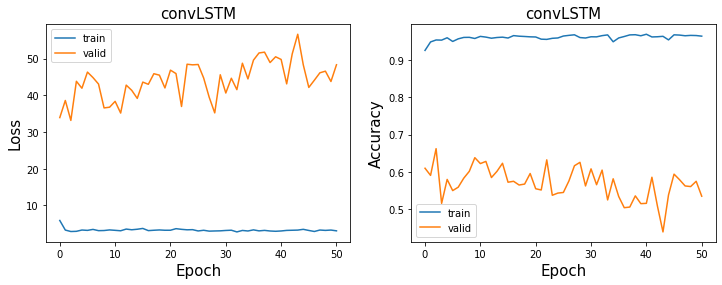

validation loss:32.191768646240234 accuracy:0.6580267558528428
test loss:9.393454551696777 accuracy:0.8850669412976313
0.8403708
/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN10_DO0.3_HD48_balanced_valcm.pt


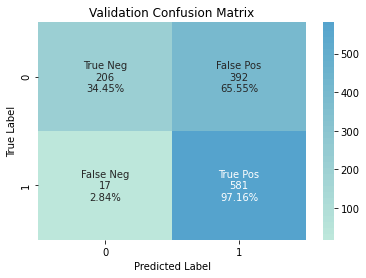

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN10_DO0.3_HD48_balanced_testcm.pt


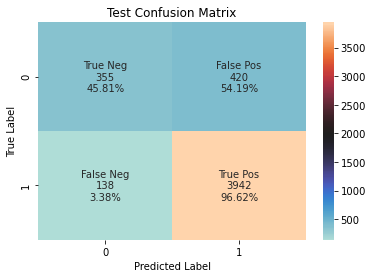

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN10_DO0.5_HD48_EPOCH1_balanced.pt
best epoch training accuracy:  0.9388978991438163


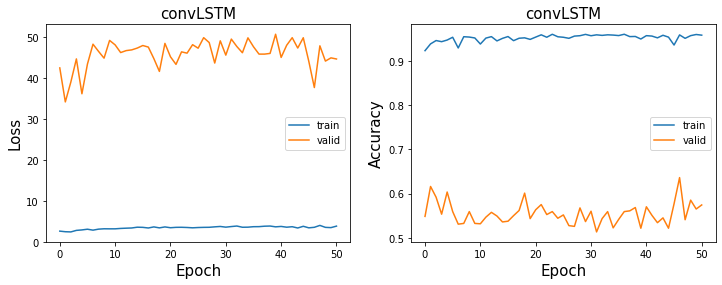

validation loss:33.030426025390625 accuracy:0.6287625418060201
test loss:9.10269832611084 accuracy:0.8830072090628218
0.8403708
/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN10_DO0.5_HD48_balanced_valcm.pt


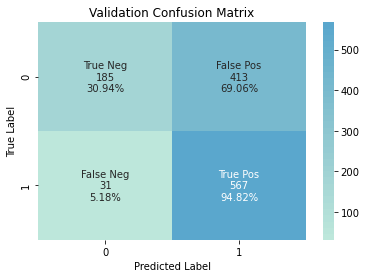

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN10_DO0.5_HD48_balanced_testcm.pt


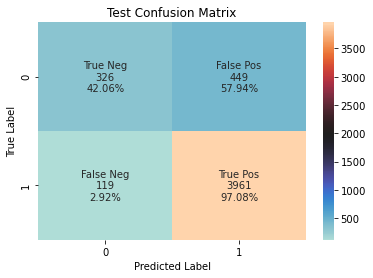

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN10_DO0.1_HD56_EPOCH7_balanced.pt
best epoch training accuracy:  0.9617357522724701


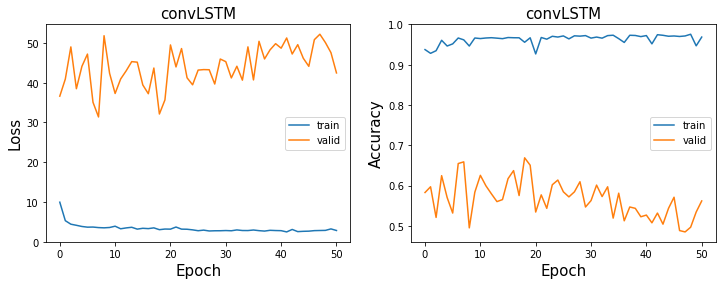

validation loss:29.194625854492188 accuracy:0.6739130434782609
test loss:9.77223014831543 accuracy:0.8834191555097838
0.8403708
/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN10_DO0.1_HD56_balanced_valcm.pt


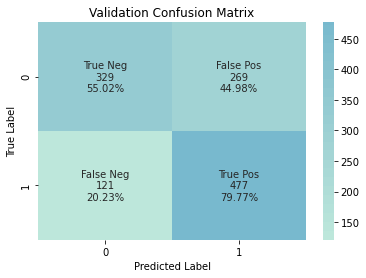

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN10_DO0.1_HD56_balanced_testcm.pt


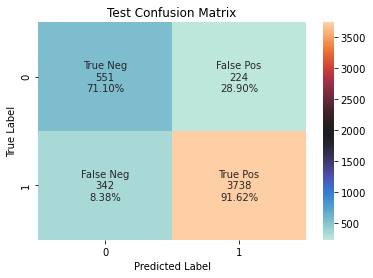

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN10_DO0.3_HD56_EPOCH0_balanced.pt
best epoch training accuracy:  0.9142684720703051


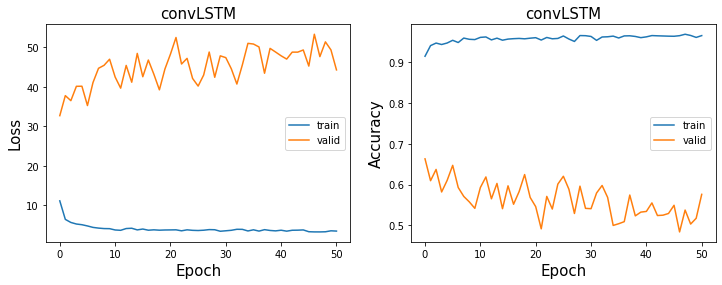

validation loss:33.558860778808594 accuracy:0.6672240802675585
test loss:10.146819114685059 accuracy:0.8844490216271884
0.8403708
/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN10_DO0.3_HD56_balanced_valcm.pt


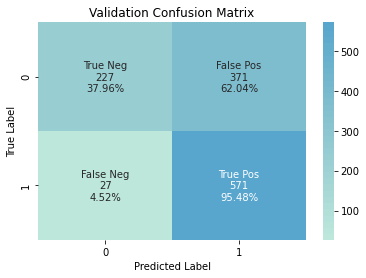

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN10_DO0.3_HD56_balanced_testcm.pt


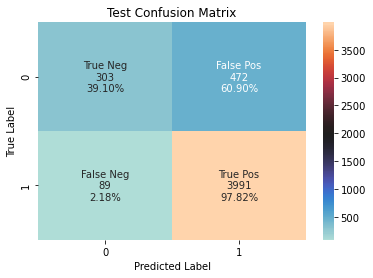

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN10_DO0.5_HD56_EPOCH0_balanced.pt
best epoch training accuracy:  0.9209821596952439


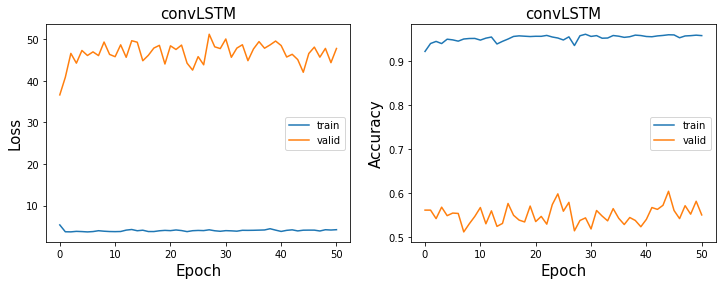

validation loss:36.03877639770508 accuracy:0.568561872909699
test loss:10.062636375427246 accuracy:0.8240988671472709
0.8403708
/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN10_DO0.5_HD56_balanced_valcm.pt


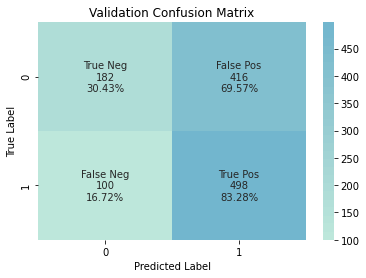

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN10_DO0.5_HD56_balanced_testcm.pt


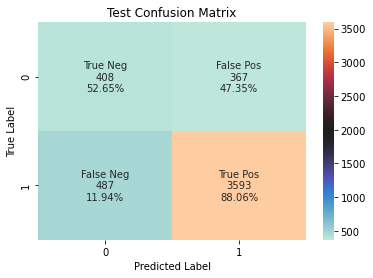

In [42]:
for i,(index,row) in enumerate(best_results.iterrows()):

    best_epoch = int(row)
    hidden = int(index[0])
    dropout = index[1]
    alpha = 0
    
    
    # load best model
    model = convLSTM(input_dim = 62, hidden_dim = hidden).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    model.load_state_dict(torch.load('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_TLEN{}_DO{}_HD{}_EPOCH{}_balanced.pt'.format(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow, T_length, dropout, hidden,best_epoch)))
    
    print('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_TLEN{}_DO{}_HD{}_EPOCH{}_balanced.pt'.format(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow,T_length, dropout, hidden,best_epoch))

    ## Print training accuracy
    plot_train_result_file(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow, T_length, dropout, hidden, best_epoch)
    
    ## Calculate validation accuracy and validation loss
    val_loss, val_acc, val_preds, val_labels = evaluate(model, optimizer, criterion, val_loader, device='cuda', collect_result = True)
    print('validation loss:{} accuracy:{}'.format(val_loss, val_acc))
    
    ## Calculate test accuracy and test loss
    test_loss, test_acc, test_preds, test_labels = evaluate(model, optimizer, criterion, test_loader, device='cuda', collect_result = True)
    print('test loss:{} accuracy:{}'.format(test_loss, test_acc))
    print(np.mean(np.concatenate(test_labels)))
    
    ## Confusion matrix-validation
    predictions_val = np.concatenate(val_preds)
    labels_val = np.concatenate(val_labels)
    
    val_cm_filename = '{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_TLEN{}_DO{}_HD{}_balanced_valcm.pt'.format(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow, T_length, dropout,hidden)
    print(val_cm_filename)
    val_cm_result = {'predictions_val': predictions_val, 'labels_val' : labels_val}

    pickle.dump( val_cm_result, open( val_cm_filename, "wb" ) )
    
    
    df_val = pd.DataFrame({'predictions': predictions_val, 'labels': labels_val})

    cm_val = confusion_matrix(labels_val, predictions_val)
    ax = plt.axes()
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cm_val.flatten()]

    TNR = int(group_counts[0]) / (int(group_counts[0])+int(group_counts[1]))
    FPR = 1 - TNR
    TPR = int(group_counts[3]) / (int(group_counts[3])+int(group_counts[2]))
    FNR = 1-TPR
    group_percentages =[TNR, FPR, FNR, TPR]

    group_percentages = ["{0:.2%}".format(value) for value in
                         group_percentages]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sn.heatmap(cm_val, annot=labels, fmt='', center = 2000)
    ax.set_title('Validation Confusion Matrix')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    plt.show()
    
    ## Confusion matrix-test
    predictions_test = np.concatenate(test_preds)
    labels_test = np.concatenate(test_labels)

    test_cm_filename = '{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_TLEN{}_DO{}_HD{}_balanced_testcm.pt'.format(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow, T_length, dropout,hidden)
    print(test_cm_filename)
    test_cm_result = {'predictions_test': predictions_test, 'labels_val' : labels_test}

    pickle.dump( test_cm_result, open( test_cm_filename, "wb" ) )

    df_test = pd.DataFrame({'predictions': predictions_test, 'labels': labels_test})

    cm_test = confusion_matrix(labels_test, predictions_test)
    ax = plt.axes()
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cm_test.flatten()]

    TNR = int(group_counts[0]) / (int(group_counts[0])+int(group_counts[1]))
    FPR = 1 - TNR
    TPR = int(group_counts[3]) / (int(group_counts[3])+int(group_counts[2]))
    FNR = 1-TPR
    group_percentages =[TNR, FPR, FNR, TPR]

    group_percentages = ["{0:.2%}".format(value) for value in
                         group_percentages]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sn.heatmap(cm_test, annot=labels, fmt='', center = 2000)
    ax.set_title('Test Confusion Matrix')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    plt.show()
    


### Unbalanced result

In [40]:
results = []
for h in hidden_dim:
    for d in dropout:
        model_convLSTM = os.listdir(model_saving_path)

        best_result = 0
        reg_alpha = 'REG'+reg_type+str(alpha)+'_'
        dropout_type = 'DO'+str(d)
        hidden_type = 'HD'+str(h)
        t_len = 'TLEN'+str(T_length)
        for i, s in enumerate(model_convLSTM):
            if 'convLSTM_CHall_' in s and reg_alpha in s and dropout_type in s and 'trainresult' not in s and hidden_type in s and t_len in s and 'valcm' not in s and 'testcm' not in s and 'balanced' not in s:
                model_name = model_convLSTM[i].split('_')
                epoch_name = [ind for ind,item in enumerate(np.array(model_name)) if "EPOCH" in item]
                res = [int(i) for i in model_name[epoch_name[0]] if i.isdigit()]
                if len(res) > 1:
                    epoch_result = res[0]*10+res[1]
                else:
                    epoch_result = res[0]
                if epoch_result>best_result and epoch_result != 50:
                    best_result = epoch_result

        results.append([h,d,best_result])

results = pd.DataFrame(np.array(results), columns=['hidden','dropout', 'epoch'])
best_results = results.groupby(['hidden','dropout']).max('epoch')
print(best_results)


                epoch
hidden dropout       
10.0   0.1        0.0
       0.3        0.0
       0.5        0.0
15.0   0.1        0.0
       0.3        0.0
       0.5        0.0
48.0   0.1        5.0
       0.3        0.0
       0.5        0.0
56.0   0.1        1.0
       0.3        0.0
       0.5        0.0


In [42]:
def plot_train_result_file(model_saving_path, model_type, num_channel, loss_type, reg_type, alpha, timewindow, T_length, dropout, hidden, best_epoch):
    fb = '{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_TLEN{}_DO{}_HD{}_EPOCH50_trainresult.pt'.format(model_saving_path, model_type, num_channel, loss_type, reg_type, alpha, timewindow, T_length, dropout, hidden)
    file = open(fb,'rb')
    train_result = pickle.load(file)
    train_losses = train_result['train_losses']
    val_losses = train_result['val_losses']
    train_accs = train_result['train_accs']
    val_accs = train_result['val_accs']
    model_type = train_result['model_type']
    print('best epoch training accuracy: ', train_accs[best_epoch])
    plot_loss_acc(train_losses, val_losses, train_accs, val_accs, model_type)
    

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN10_DO0.1_HD10_EPOCH0.pt
best epoch training accuracy:  0.9585486365179346


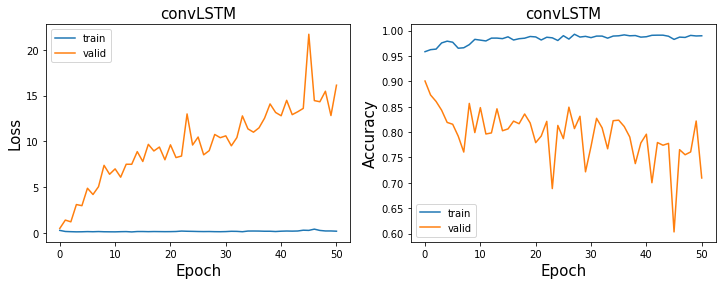

<ipython-input-14-894d578093d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = torch.tensor(outputs).to(device)


validation loss:0.3213043808937073 accuracy:0.935127674258109
test loss:0.23332422971725464 accuracy:0.930363159865219
0.89479595
/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN10_DO0.1_HD10_valcm.pt


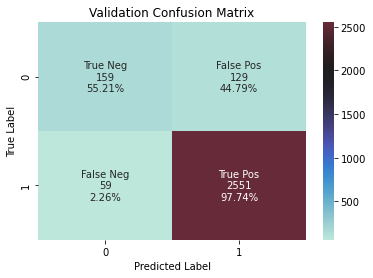

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN10_DO0.1_HD10_testcm.pt


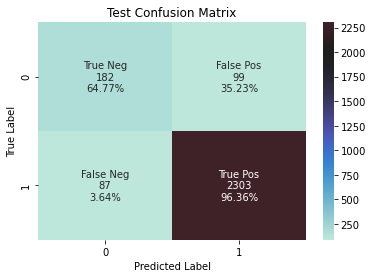

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN10_DO0.3_HD10_EPOCH0.pt
best epoch training accuracy:  0.9331271451740656


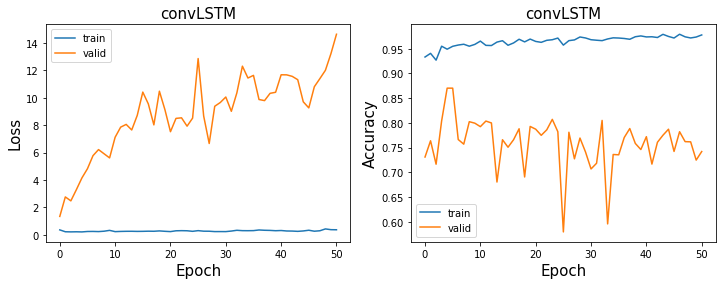

validation loss:2.4635510444641113 accuracy:0.6984126984126984
test loss:2.5733799934387207 accuracy:0.8060651441407712
0.89479595
/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN10_DO0.3_HD10_valcm.pt


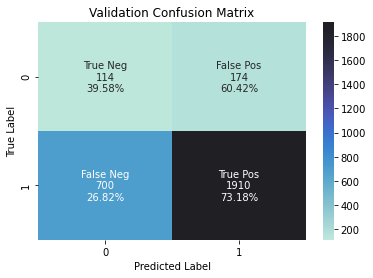

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN10_DO0.3_HD10_testcm.pt


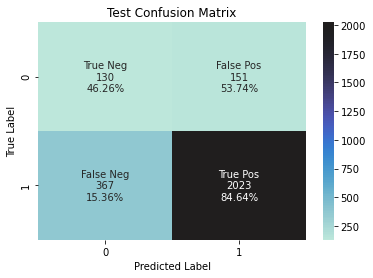

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN10_DO0.5_HD10_EPOCH0.pt
best epoch training accuracy:  0.9074416324067439


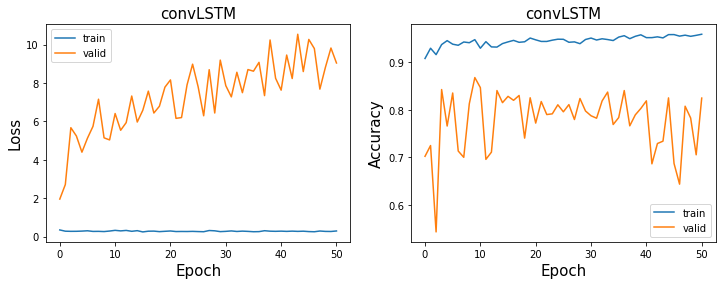

validation loss:2.333721160888672 accuracy:0.6825396825396826
test loss:0.7610352635383606 accuracy:0.8494945713216024
0.89479595
/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN10_DO0.5_HD10_valcm.pt


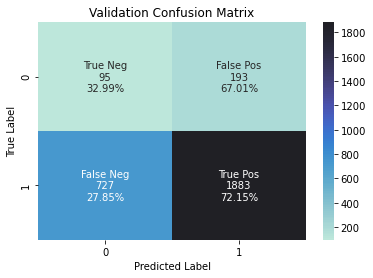

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN10_DO0.5_HD10_testcm.pt


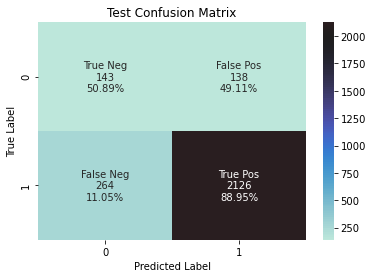

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN10_DO0.1_HD15_EPOCH0.pt
best epoch training accuracy:  0.9575868441896428


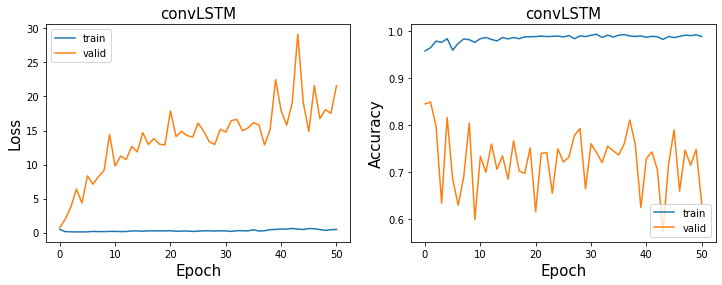

validation loss:1.1444952487945557 accuracy:0.7829537612146308
test loss:1.3142043352127075 accuracy:0.8004492699363535
0.89479595
/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN10_DO0.1_HD15_valcm.pt


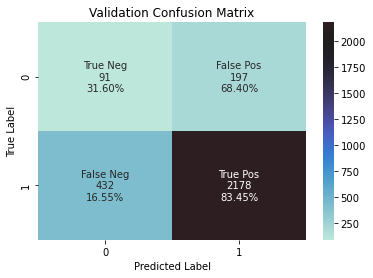

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN10_DO0.1_HD15_testcm.pt


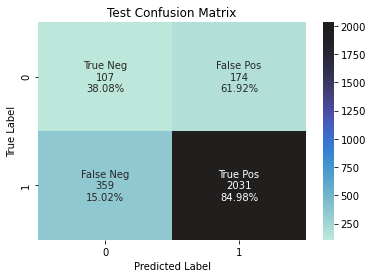

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN10_DO0.3_HD15_EPOCH0.pt
best epoch training accuracy:  0.9216233545807717


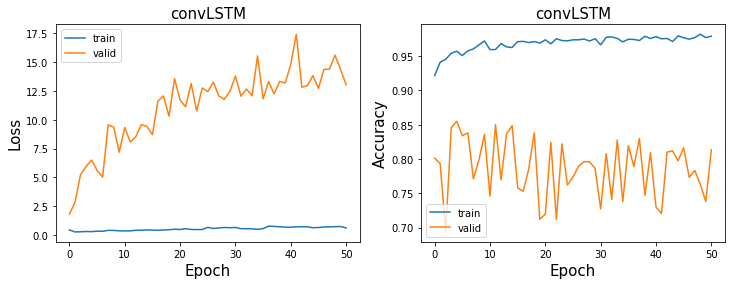

validation loss:2.3457443714141846 accuracy:0.8143547273982057
test loss:1.497675895690918 accuracy:0.8191688506177461
0.89479595
/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN10_DO0.3_HD15_valcm.pt


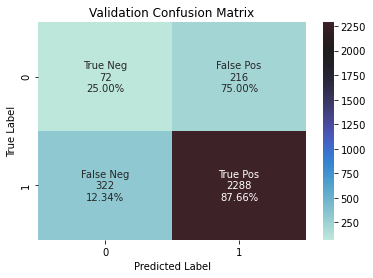

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN10_DO0.3_HD15_testcm.pt


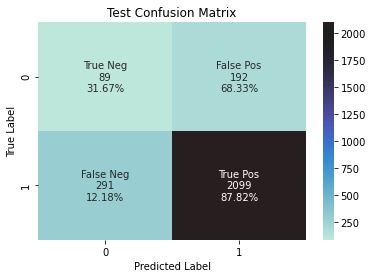

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN10_DO0.5_HD15_EPOCH0.pt
best epoch training accuracy:  0.913646135857881


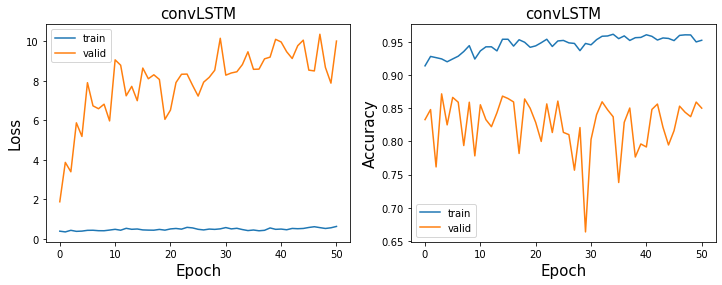

validation loss:1.9699006080627441 accuracy:0.9054520358868184
test loss:1.7795822620391846 accuracy:0.8390116061400225
0.89479595
/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN10_DO0.5_HD15_valcm.pt


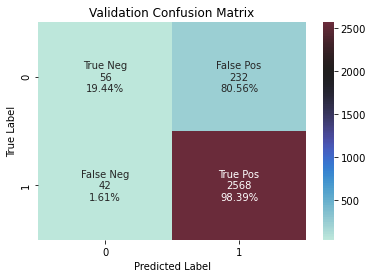

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN10_DO0.5_HD15_testcm.pt


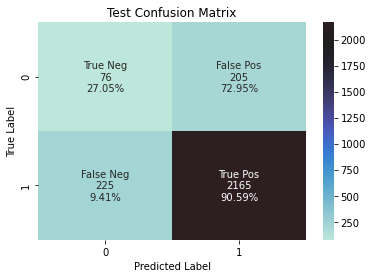

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN10_DO0.1_HD48_EPOCH5.pt
best epoch training accuracy:  0.9624335231773092


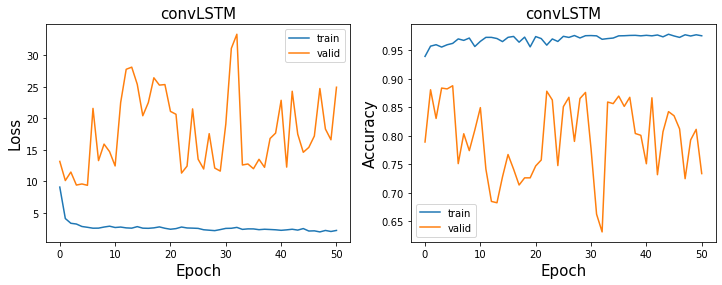

validation loss:8.578389167785645 accuracy:0.9051069703243616
test loss:12.440715789794922 accuracy:0.8637214526394609
0.89479595
/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN10_DO0.1_HD48_valcm.pt


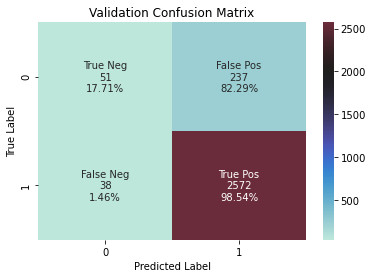

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN10_DO0.1_HD48_testcm.pt


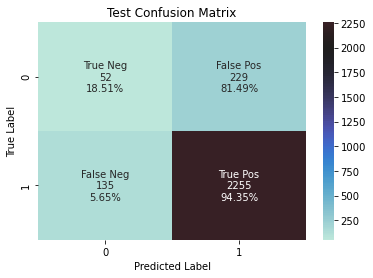

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN10_DO0.3_HD48_EPOCH0.pt
best epoch training accuracy:  0.9395390940293441


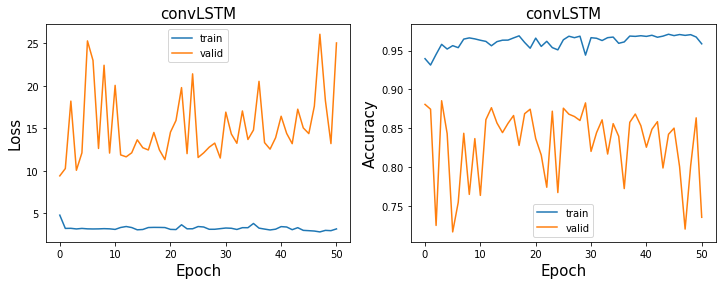

validation loss:7.330060958862305 accuracy:0.9106280193236715
test loss:6.107574462890625 accuracy:0.9067764882066641
0.89479595
/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN10_DO0.3_HD48_valcm.pt


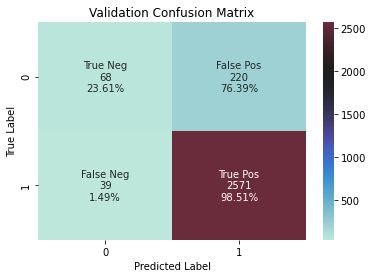

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN10_DO0.3_HD48_testcm.pt


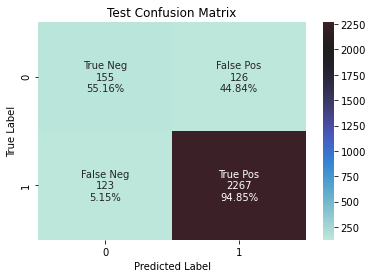

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN10_DO0.5_HD48_EPOCH0.pt
best epoch training accuracy:  0.9178139026138121


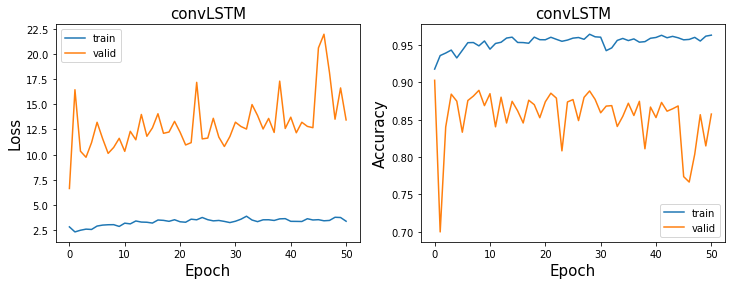

validation loss:7.123067378997803 accuracy:0.9147688060731539
test loss:7.67318868637085 accuracy:0.9041557469112692
0.89479595
/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN10_DO0.5_HD48_valcm.pt


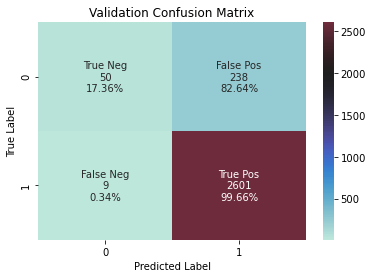

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN10_DO0.5_HD48_testcm.pt


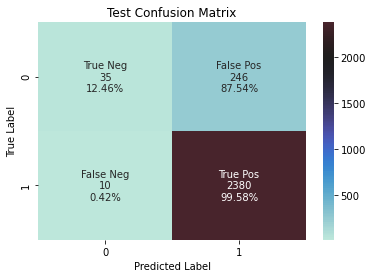

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN10_DO0.1_HD56_EPOCH1.pt
best epoch training accuracy:  0.950646852487459


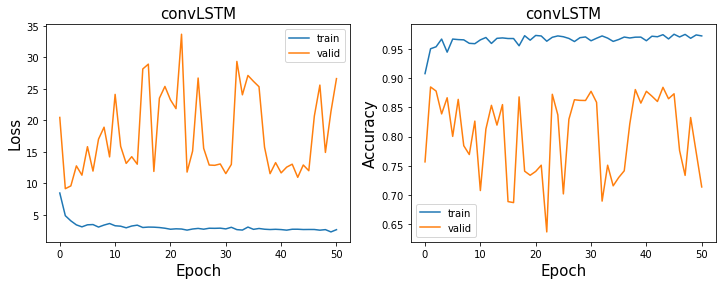

validation loss:8.890419006347656 accuracy:0.8881987577639752
test loss:11.61584186553955 accuracy:0.8640958442530887
0.89479595
/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN10_DO0.1_HD56_valcm.pt


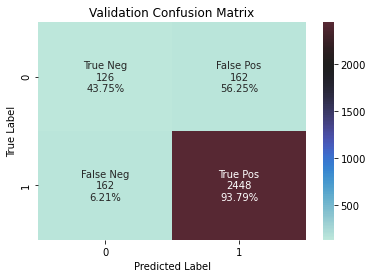

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN10_DO0.1_HD56_testcm.pt


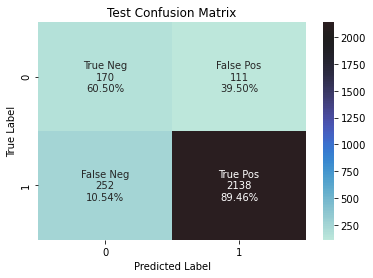

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN10_DO0.3_HD56_EPOCH0.pt
best epoch training accuracy:  0.9145136348206541


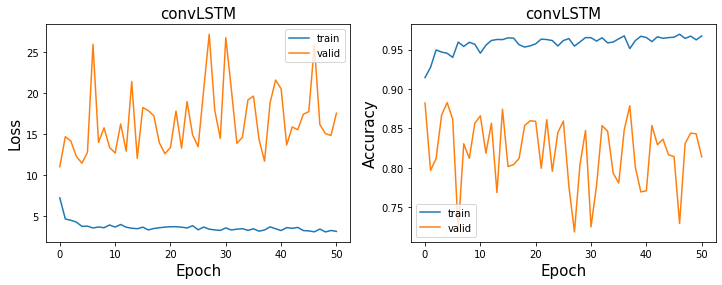

validation loss:9.272382736206055 accuracy:0.9033816425120773
test loss:12.144562721252441 accuracy:0.8655934107076001
0.89479595
/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN10_DO0.3_HD56_valcm.pt


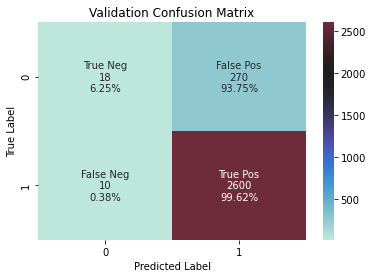

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN10_DO0.3_HD56_testcm.pt


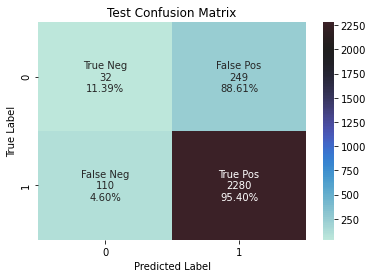

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN10_DO0.5_HD56_EPOCH0.pt
best epoch training accuracy:  0.9236978086221853


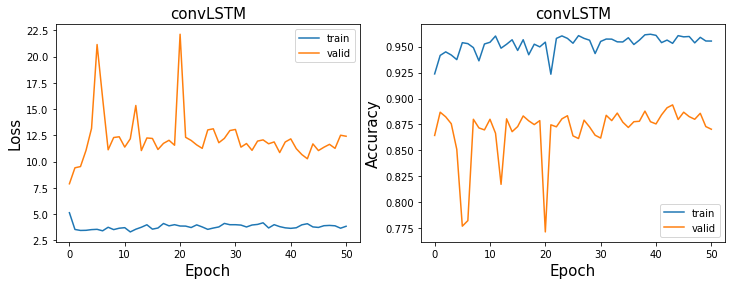

validation loss:7.106043338775635 accuracy:0.8926846100759144
test loss:9.43715763092041 accuracy:0.8592287532759266
0.89479595
/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN10_DO0.5_HD56_valcm.pt


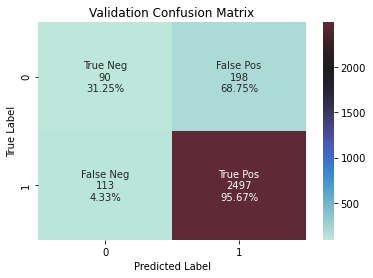

/home/bijanadmin/Desktop/Goose_and_Jester_data/data_Goose_all_Jester_all_2/convLSTM_models/convLSTM_CHall_LOSSbce_REGnone0_TW10_TLEN10_DO0.5_HD56_testcm.pt


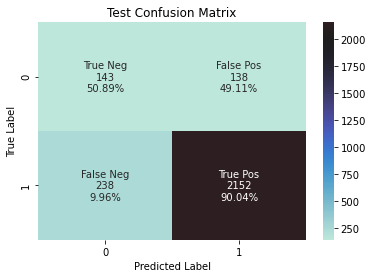

In [43]:
for i,(index,row) in enumerate(best_results.iterrows()):

    best_epoch = int(row)
    hidden = int(index[0])
    dropout = index[1]
    alpha = 0
    
    
    # load best model
    model = convLSTM(input_dim = 62, hidden_dim = hidden).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    model.load_state_dict(torch.load('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_TLEN{}_DO{}_HD{}_EPOCH{}.pt'.format(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow, T_length, dropout, hidden,best_epoch)))
    
    print('{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_TLEN{}_DO{}_HD{}_EPOCH{}.pt'.format(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow,T_length, dropout, hidden,best_epoch))

    ## Print training result
    plot_train_result_file(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow, T_length, dropout, hidden, best_epoch)
    
    ## Calculate validation accuracy and validation loss
    val_loss, val_acc, val_preds, val_labels = evaluate(model, optimizer, criterion, val_loader, device='cuda', collect_result = True)
    print('validation loss:{} accuracy:{}'.format(val_loss, val_acc))
    
    ## Calculate test accuracy and test loss
    test_loss, test_acc, test_preds, test_labels = evaluate(model, optimizer, criterion, test_loader, device='cuda', collect_result = True)
    print('test loss:{} accuracy:{}'.format(test_loss, test_acc))
    print(np.mean(np.concatenate(test_labels)))
    
    ## Confusion matrix-validation
    predictions_val = np.concatenate(val_preds)
    labels_val = np.concatenate(val_labels)
    
    val_cm_filename = '{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_TLEN{}_DO{}_HD{}_valcm.pt'.format(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow, T_length, dropout,hidden)
    print(val_cm_filename)
    val_cm_result = {'predictions_val': predictions_val, 'labels_val' : labels_val}

    pickle.dump( val_cm_result, open( val_cm_filename, "wb" ) )
    
    
    df_val = pd.DataFrame({'predictions': predictions_val, 'labels': labels_val})

    cm_val = confusion_matrix(labels_val, predictions_val)
    ax = plt.axes()
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cm_val.flatten()]

    TNR = int(group_counts[0]) / (int(group_counts[0])+int(group_counts[1]))
    FPR = 1 - TNR
    TPR = int(group_counts[3]) / (int(group_counts[3])+int(group_counts[2]))
    FNR = 1-TPR
    group_percentages =[TNR, FPR, FNR, TPR]

    group_percentages = ["{0:.2%}".format(value) for value in
                         group_percentages]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sn.heatmap(cm_val, annot=labels, fmt='', center = 2000)
    ax.set_title('Validation Confusion Matrix')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    plt.show()
    
    ## Confusion matrix-test
    predictions_test = np.concatenate(test_preds)
    labels_test = np.concatenate(test_labels)

    test_cm_filename = '{}/{}_CH{}_LOSS{}_REG{}{}_TW{}_TLEN{}_DO{}_HD{}_testcm.pt'.format(model_saving_path, model_type, ch, loss_type, reg_type, alpha, timewindow, T_length, dropout,hidden)
    print(test_cm_filename)
    test_cm_result = {'predictions_test': predictions_test, 'labels_val' : labels_test}

    pickle.dump( test_cm_result, open( test_cm_filename, "wb" ) )

    df_test = pd.DataFrame({'predictions': predictions_test, 'labels': labels_test})

    cm_test = confusion_matrix(labels_test, predictions_test)
    ax = plt.axes()
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cm_test.flatten()]

    TNR = int(group_counts[0]) / (int(group_counts[0])+int(group_counts[1]))
    FPR = 1 - TNR
    TPR = int(group_counts[3]) / (int(group_counts[3])+int(group_counts[2]))
    FNR = 1-TPR
    group_percentages =[TNR, FPR, FNR, TPR]

    group_percentages = ["{0:.2%}".format(value) for value in
                         group_percentages]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sn.heatmap(cm_test, annot=labels, fmt='', center = 2000)
    ax.set_title('Test Confusion Matrix')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    plt.show()
    
